In [1]:
import numpy as np
import pandas as pd
import os
import argparse
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from capstone_project.preprocessing import generate_dataloaders, load_data, split_data
from capstone_project.models.embedding_network import EmbeddingNetwork
from capstone_project.models.classification_network import ClassificationNetwork
from capstone_project.utils import *

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
PROJECT_DIR = '/home/kyt237/learning_visual_embeddings/'
DATA_DIR,  PLOTS_DIR, LOGGING_DIR = 'data', 'plots', 'logs'
CHECKPOINTS_DIR = 'checkpoints'
DATASET = 'mnist_test_seq.npy'
TEST_SIZE, VAL_SIZE = 0.2, 0.2

BATCH_SIZE = 64    # input batch size for training
N_EPOCHS = 100     # number of epochs to train
LR = 1e-4          # learning rate
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_PASSES_FOR_GENERATION = 1   # number of passes through data for pair generation
NUM_FRAMES_IN_STACK = 2         # number of (total) frames to concatenate for each video
NUM_PAIRS_PER_EXAMPLE = 5        # number of pairs to generate for given video and time difference
TIME_BUCKETS = [[0], [1], [2], [3,4], range(5,11,1)]

RS = 20150101 # Random state

In [3]:
import torch
import torch.nn as nn


def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=stride, padding=padding, bias=bias)


# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, input):
        residual = input
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.bn2(output)
        if self.downsample:
            residual = self.downsample(input)
        output += residual
        output = self.relu(output)
        return output


class EmbeddingNetwork(nn.Module):
    def __init__(self, in_dim, in_channels, hidden_size, out_dim, block=ResidualBlock, num_blocks=3):
        super(EmbeddingNetwork, self).__init__()
        self.in_dim = in_dim
        self.in_channels = in_channels

        # Conv-ReLU layers with batch-norm and downsampling
#         self.conv1 = conv3x3(in_channels, 32)
        self.conv1 = conv3x3(in_channels, 32, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = conv3x3(32, 64)
        self.conv2 = conv3x3(32, 64, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = conv3x3(64, 64)
        self.conv3 = conv3x3(64, 64, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers
        self.residual_layers = self._make_layer(block, 64, 64, num_blocks)

        # Automatically get dimension of FC layer by using dummy input
        fc1_input_size = self._get_fc_input_size()
        #print(fc1_input_size)

        # Fully connected layers
        self.fc1 = nn.Linear(fc1_input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, out_dim)

        # Initialize weights
        self._init_weights()

    def forward(self, input):
        # Reshape input to batch_size x in_channels x height x width
        input = input.view(-1, self.in_channels, self.in_dim, self.in_dim)

        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu(output)

        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu(output)
#         output = self.pool(output) # NOTE: Use pool in _get_fc_input_size if using it here

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu(output)
#         output = self.pool(output) # NOTE: Use pool in _get_fc_input_size if using it here

        # output = self.residual_layers(output)

        output = output.view(output.size(0), -1)
        output = self.fc1(output)
        output = self.fc2(output)
        output_n = torch.norm(output, p=2, dim=1, keepdim=True)
        output = output.div(output_n.expand_as(output))
        return output

    def _make_layer(self, block, in_channels, out_channels, num_blocks, stride=1, downsample=None):
        if (not downsample) and ((stride != 1) or (in_channels != out_channels)):
            downsample = nn.Sequential(conv3x3(in_channels, out_channels, stride=stride), nn.BatchNorm2d(out_channels))

        layers = [block(in_channels, out_channels, stride, downsample)]
        for i in range(num_blocks-1):
            # For residual blocks, in_channels = out_channels
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.uniform_(m.bias)

    def _get_fc_input_size(self):
        layers = nn.Sequential(self.conv1,
                            self.bn1,
                            self.relu,
                            self.conv2,
                            self.bn2,
                            self.relu,
#                             self.pool,
                            self.conv3,
                            self.bn3,
                            self.relu,
#                             self.pool,
                            self.residual_layers
                )

        with torch.no_grad():
            dummy_input = torch.zeros([1, self.in_channels, self.in_dim, self.in_dim]).float()
            dummy_output = layers(dummy_input)
            fc_size = dummy_output.flatten(0).shape[0]

        return fc_size

In [4]:
DATASET = 'moving_bars_20_121.npy'
data = load_data(PROJECT_DIR, DATA_DIR, DATASET)
train_data = split_data(data, VAL_SIZE, TEST_SIZE, PROJECT_DIR, DATA_DIR)['train']
val_data = split_data(data, VAL_SIZE, TEST_SIZE, PROJECT_DIR, DATA_DIR)['val']

In [5]:
img_dim = data.shape[-1]
in_dim = img_dim
in_dim, in_channels, out_dim = img_dim, NUM_FRAMES_IN_STACK, 1024
embedding_hidden_size, classification_hidden_size = 1024, 1024
num_outputs = len(TIME_BUCKETS)

In [6]:
class EmbeddingDataset(Dataset):
    def __init__(self, X, num_frames_in_stack, transforms=None):
        self.X = X
        self.transforms = transforms
        self.num_frames_in_stack = num_frames_in_stack
        self.seq_len = X.shape[1]

    def __getitem__(self, index):
        video = self.X[index]
        stacked_frames = []
        
        for frame in range(self.num_frames_in_stack-1, self.seq_len):
            frame_numbers = np.array(range(frame-self.num_frames_in_stack+1, frame+1))
            frames = video[frame_numbers]
            if self.transforms:
                frames = self.transforms(frames)
            stacked_frames.append(frames)
            
        return torch.from_numpy(np.array(stacked_frames)) # torch.from_numpy uses same memory

    def __len__(self):
        return len(self.X)

In [7]:
def get_embeddings(embedding_network, dataloader, device):
    all_embeddings = np.array([])
    all_videos = np.array([])
    embedding_network.eval()
    with torch.no_grad():
        for batch_idx, all_stacked_frames in enumerate(dataloader):
            # Reshape (64,19,2,121,121) -> (19,64,2,121,121)
            all_stacked_frames = all_stacked_frames.numpy().swapaxes(0, 1)
            all_stacked_frames = torch.from_numpy(all_stacked_frames).to(DEVICE).float()
            embeddings = []
            videos = np.array([])
            for stacked_frames in all_stacked_frames:
                embedding_output = embedding_network(stacked_frames).detach().cpu().numpy()
                embeddings.append(embedding_output)
                
                frames = stacked_frames.detach().cpu().numpy().swapaxes(0, 1) # (2,64,121,121)
                last_frame = np.array([frames[-1]])
                videos = np.vstack((videos, last_frame)) if videos.size else last_frame
            embeddings = np.array(embeddings).swapaxes(0, 1)
            all_embeddings = np.vstack((all_embeddings, embeddings)) if all_embeddings.size else embeddings
            
            videos = videos.swapaxes(0, 1)
            all_videos = np.vstack((all_videos, videos)) if all_videos.size else np.array(videos)
    return all_embeddings, all_videos

In [8]:
embedding_network = EmbeddingNetwork(in_dim, in_channels, embedding_hidden_size, out_dim).to(DEVICE)
classification_network = ClassificationNetwork(out_dim, classification_hidden_size, num_outputs).to(DEVICE)

16384


In [33]:
criterion_train = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(list(embedding_network.parameters()) + list(classification_network.parameters()), lr=LR)

In [34]:
embedding_network, classification_network, optimizer, train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history = \
    load_checkpoint(embedding_network, classification_network, optimizer, DEVICE, 10, DATASET, NUM_FRAMES_IN_STACK, NUM_PAIRS_PER_EXAMPLE, PROJECT_DIR, CHECKPOINTS_DIR)

TypeError: load_checkpoint() takes 7 positional arguments but 10 were given

In [9]:
train_embedding_dataset = EmbeddingDataset(train_data, NUM_FRAMES_IN_STACK)
val_embedding_dataset = EmbeddingDataset(val_data, NUM_FRAMES_IN_STACK)

In [10]:
train_dataloader = DataLoader(train_embedding_dataset, batch_size=64, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_embedding_dataset, batch_size=64, shuffle=False, num_workers=4)

In [11]:
train_embeddings_bars, train_videos_bars = get_embeddings(embedding_network, train_dataloader, DEVICE)
val_embeddings_bars, val_videos_bars = get_embeddings(embedding_network, val_dataloader, DEVICE)

In [12]:
embeddings_bars.shape

(146, 19, 1024)

In [15]:
val_videos_bars.shape

(48, 19, 121, 121)

In [12]:
train_embeddings_bars = train_embeddings_bars.reshape((-1,1024))
val_embeddings_bars = val_embeddings_bars.reshape((-1,1024))

In [14]:
val_embeddings_bars.shape

(912, 1024)

In [16]:
train_videos_bars = train_videos_bars.reshape((-1,121,121))
val_videos_bars = val_videos_bars.reshape((-1,121,121))

In [17]:
val_videos_bars.shape

(912, 121, 121)

In [18]:
class DecoderDataset(Dataset):
    def __init__(self, X_embed, target_img, transforms=None):
        self.X_embed = X_embed
        self.target_img = target_img

    def __getitem__(self, index):
        return torch.from_numpy(self.X_embed[index]), torch.from_numpy(self.target_img[index])

    def __len__(self):
        return len(self.X_embed)

In [19]:
class DecoderNetwork(nn.Module):
    def __init__(self, emb_size,hidden_size):
        super(DecoderNetwork, self).__init__()
        self.emb_size,self.hidden_size = emb_size,hidden_size
        # Deconv layers
        self.deconv1 = nn.ConvTranspose2d(in_channels=64,out_channels=64,stride=2,padding=1,kernel_size=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(in_channels=64,out_channels=32,stride=2,padding=1,kernel_size=3,bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.deconv3 = nn.ConvTranspose2d(in_channels=32,out_channels=1,stride=2,padding=1,kernel_size=3,bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(emb_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,64*16*16)
        # Initialize weights
        self._init_weights()

    def forward(self, input):
        output = self.fc1(input)
        output = self.fc2(output)
        output = output.view(output.size(0),64,16,16)
        output = self.deconv1(output)
        output = self.bn1(output)
        output = self.relu(output)

        output = self.deconv2(output)
        output = self.bn2(output)
        output = self.relu(output)

        output = self.deconv3(output)
        #output = self.tanh(output)
        #trying to use a BCE loss and hence returning the outputs using a sigmoid
        output = self.sigmoid(output)
        return output.squeeze()

    def _init_weights(self):
        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                m.weight.data.normal_(0.0, 0.02)
            elif classname.find('BatchNorm') != -1:
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)


In [20]:
train_decoder_dataset = DecoderDataset(train_embeddings_bars,train_videos_bars)
train_decoder_dataloader = DataLoader(train_decoder_dataset, batch_size=64, shuffle=False)
val_decoder_dataset = DecoderDataset(val_embeddings_bars,val_videos_bars)
val_decoder_dataloader = DataLoader(val_decoder_dataset, batch_size=64, shuffle=False)

In [21]:
def train(decoder_network, dataloader, criterion, optimizer, device, epoch):
    loss_train = 0.
    for batch_idx, (x_embed, target_img) in enumerate(dataloader):
        x_embed, target_img = x_embed.to(device).float(), target_img.to(device).float()
        decoder_network.train()

        optimizer.zero_grad()

        gen_img = decoder_network(x_embed)
        #assert (gen_img.view(-1,121*121) >= 0. & gen_img.view(-1,121*121) <= 1.).all()
        #assert (target_img.view(-1,121*121) >= 0. & target_img.view(-1,121*121) <= 1.).all()


        loss = criterion(gen_img.view(-1,121*121), target_img.view(-1,target_img.size(1)*target_img.size(1)))
        loss.backward()
        optimizer.step()
        #print(len(dataloader.dataset))
        # Accurately compute loss, because of different batch size
        loss_train += loss.item() * len(x_embed) / len(dataloader.dataset)

        if (batch_idx+1) % (len(dataloader.dataset)//(20*target_img.shape[0])) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx+1) * target_img.shape[0], len(dataloader.dataset),
                100. * (batch_idx+1) / len(dataloader), loss.item()))

    optimizer.zero_grad()
    return loss_train,gen_img.detach().cpu().numpy()

def test(embedding_network, dataloader, criterion, device):
    decoder_network.eval()
    loss_test = 0.
    with torch.no_grad():
        for batch_idx, (x_embed, target_img) in enumerate(dataloader):
            x_embed, target_img = x_embed.to(device).float(), target_img.to(device).float()
            gen_img = decoder_network(x_embed)
            loss = criterion(gen_img.view(-1,gen_img.size(1)*gen_img.size(1)), target_img.view(-1,target_img.size(1)*target_img.size(1)))

            # Accurately compute loss, because of different batch size
            loss_test += loss.item() / len(dataloader.dataset)
            
    return loss_test,gen_img.detach().cpu().numpy()


In [22]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [23]:
#DEVICE = 'cpu'

In [25]:
N_EPOCHS = 1000

In [31]:
len(train_embeddings_bars)

2774

In [26]:
criterion = nn.BCELoss(reduction='sum')
criterion_test = nn.BCELoss(reduction='sum')
decoder_network = DecoderNetwork(emb_size=train_embeddings_bars.shape[1],hidden_size=1024).to(DEVICE)
optimizer = optim.Adam(decoder_network.parameters(), lr=LR)

for epoch in range(N_EPOCHS):
    train_loss,gen_img_temp_train = train(decoder_network,train_decoder_dataloader,criterion,optimizer,DEVICE,epoch)
    #val_loss,gen_img_temp_val = test(decoder_network,val_decoder_dataloader,criterion_test,DEVICE)
    print('TRAIN Epoch: {}\tAverage loss: {:.4f}'.format(epoch, train_loss))
    print('VAL Epoch: {}\tAverage loss: {:.4f}'.format(epoch, val_loss))


    

Train Epoch: 0 [128/2774 (5%)]	Loss: 652938.937500
Train Epoch: 0 [256/2774 (9%)]	Loss: 647903.187500
Train Epoch: 0 [384/2774 (14%)]	Loss: 643739.562500
Train Epoch: 0 [512/2774 (18%)]	Loss: 639969.812500
Train Epoch: 0 [640/2774 (23%)]	Loss: 636475.937500
Train Epoch: 0 [768/2774 (27%)]	Loss: 633114.875000
Train Epoch: 0 [896/2774 (32%)]	Loss: 629890.625000
Train Epoch: 0 [1024/2774 (36%)]	Loss: 626786.687500
Train Epoch: 0 [1152/2774 (41%)]	Loss: 623752.812500
Train Epoch: 0 [1280/2774 (45%)]	Loss: 620797.812500
Train Epoch: 0 [1408/2774 (50%)]	Loss: 617907.000000
Train Epoch: 0 [1536/2774 (55%)]	Loss: 615034.187500
Train Epoch: 0 [1664/2774 (59%)]	Loss: 612192.125000
Train Epoch: 0 [1792/2774 (64%)]	Loss: 609412.750000
Train Epoch: 0 [1920/2774 (68%)]	Loss: 606627.437500
Train Epoch: 0 [2048/2774 (73%)]	Loss: 603868.125000
Train Epoch: 0 [2176/2774 (77%)]	Loss: 601132.187500
Train Epoch: 0 [2304/2774 (82%)]	Loss: 598391.250000
Train Epoch: 0 [2432/2774 (86%)]	Loss: 595693.750000
Tr

TRAIN Epoch: 6	Average loss: 322711.1771
VAL Epoch: 6	Average loss: 4794.5985
Train Epoch: 7 [128/2774 (5%)]	Loss: 306920.281250
Train Epoch: 7 [256/2774 (9%)]	Loss: 305709.750000
Train Epoch: 7 [384/2774 (14%)]	Loss: 304409.312500
Train Epoch: 7 [512/2774 (18%)]	Loss: 303020.593750
Train Epoch: 7 [640/2774 (23%)]	Loss: 301712.250000
Train Epoch: 7 [768/2774 (27%)]	Loss: 300390.375000
Train Epoch: 7 [896/2774 (32%)]	Loss: 299046.125000
Train Epoch: 7 [1024/2774 (36%)]	Loss: 297801.843750
Train Epoch: 7 [1152/2774 (41%)]	Loss: 296520.906250
Train Epoch: 7 [1280/2774 (45%)]	Loss: 295430.187500
Train Epoch: 7 [1408/2774 (50%)]	Loss: 293806.250000
Train Epoch: 7 [1536/2774 (55%)]	Loss: 292570.843750
Train Epoch: 7 [1664/2774 (59%)]	Loss: 291256.343750
Train Epoch: 7 [1792/2774 (64%)]	Loss: 290103.437500
Train Epoch: 7 [1920/2774 (68%)]	Loss: 288878.406250
Train Epoch: 7 [2048/2774 (73%)]	Loss: 287624.937500
Train Epoch: 7 [2176/2774 (77%)]	Loss: 286130.531250
Train Epoch: 7 [2304/2774 (82%

TRAIN Epoch: 13	Average loss: 178619.6334
VAL Epoch: 13	Average loss: 2702.4438
Train Epoch: 14 [128/2774 (5%)]	Loss: 172636.968750
Train Epoch: 14 [256/2774 (9%)]	Loss: 172164.031250
Train Epoch: 14 [384/2774 (14%)]	Loss: 171756.562500
Train Epoch: 14 [512/2774 (18%)]	Loss: 171089.031250
Train Epoch: 14 [640/2774 (23%)]	Loss: 170625.218750
Train Epoch: 14 [768/2774 (27%)]	Loss: 170081.250000
Train Epoch: 14 [896/2774 (32%)]	Loss: 169570.687500
Train Epoch: 14 [1024/2774 (36%)]	Loss: 169027.015625
Train Epoch: 14 [1152/2774 (41%)]	Loss: 168557.062500
Train Epoch: 14 [1280/2774 (45%)]	Loss: 168476.406250
Train Epoch: 14 [1408/2774 (50%)]	Loss: 167329.687500
Train Epoch: 14 [1536/2774 (55%)]	Loss: 166892.937500
Train Epoch: 14 [1664/2774 (59%)]	Loss: 166337.453125
Train Epoch: 14 [1792/2774 (64%)]	Loss: 165991.640625
Train Epoch: 14 [1920/2774 (68%)]	Loss: 165584.015625
Train Epoch: 14 [2048/2774 (73%)]	Loss: 165018.812500
Train Epoch: 14 [2176/2774 (77%)]	Loss: 164178.093750
Train Epoch

TRAIN Epoch: 20	Average loss: 116786.8474
VAL Epoch: 20	Average loss: 1787.9377
Train Epoch: 21 [128/2774 (5%)]	Loss: 114014.820312
Train Epoch: 21 [256/2774 (9%)]	Loss: 113706.226562
Train Epoch: 21 [384/2774 (14%)]	Loss: 113829.351562
Train Epoch: 21 [512/2774 (18%)]	Loss: 113266.656250
Train Epoch: 21 [640/2774 (23%)]	Loss: 113117.046875
Train Epoch: 21 [768/2774 (27%)]	Loss: 112855.546875
Train Epoch: 21 [896/2774 (32%)]	Loss: 112575.773438
Train Epoch: 21 [1024/2774 (36%)]	Loss: 112239.687500
Train Epoch: 21 [1152/2774 (41%)]	Loss: 112065.781250
Train Epoch: 21 [1280/2774 (45%)]	Loss: 112366.890625
Train Epoch: 21 [1408/2774 (50%)]	Loss: 111383.953125
Train Epoch: 21 [1536/2774 (55%)]	Loss: 111213.640625
Train Epoch: 21 [1664/2774 (59%)]	Loss: 111009.742188
Train Epoch: 21 [1792/2774 (64%)]	Loss: 110855.906250
Train Epoch: 21 [1920/2774 (68%)]	Loss: 110809.375000
Train Epoch: 21 [2048/2774 (73%)]	Loss: 110435.070312
Train Epoch: 21 [2176/2774 (77%)]	Loss: 109791.093750
Train Epoch

Train Epoch: 27 [2688/2774 (95%)]	Loss: 84838.757812
TRAIN Epoch: 27	Average loss: 85652.4452
VAL Epoch: 27	Average loss: 1321.0351
Train Epoch: 28 [128/2774 (5%)]	Loss: 84202.781250
Train Epoch: 28 [256/2774 (9%)]	Loss: 83845.593750
Train Epoch: 28 [384/2774 (14%)]	Loss: 84505.062500
Train Epoch: 28 [512/2774 (18%)]	Loss: 83874.210938
Train Epoch: 28 [640/2774 (23%)]	Loss: 83665.203125
Train Epoch: 28 [768/2774 (27%)]	Loss: 83808.882812
Train Epoch: 28 [896/2774 (32%)]	Loss: 83204.601562
Train Epoch: 28 [1024/2774 (36%)]	Loss: 83066.281250
Train Epoch: 28 [1152/2774 (41%)]	Loss: 83045.421875
Train Epoch: 28 [1280/2774 (45%)]	Loss: 83402.562500
Train Epoch: 28 [1408/2774 (50%)]	Loss: 82550.648438
Train Epoch: 28 [1536/2774 (55%)]	Loss: 82490.851562
Train Epoch: 28 [1664/2774 (59%)]	Loss: 81982.515625
Train Epoch: 28 [1792/2774 (64%)]	Loss: 82487.656250
Train Epoch: 28 [1920/2774 (68%)]	Loss: 83065.867188
Train Epoch: 28 [2048/2774 (73%)]	Loss: 82744.882812
Train Epoch: 28 [2176/2774 (7

Train Epoch: 34 [2688/2774 (95%)]	Loss: 66191.671875
TRAIN Epoch: 34	Average loss: 67146.5677
VAL Epoch: 34	Average loss: 1171.3266
Train Epoch: 35 [128/2774 (5%)]	Loss: 66231.609375
Train Epoch: 35 [256/2774 (9%)]	Loss: 66849.507812
Train Epoch: 35 [384/2774 (14%)]	Loss: 66006.234375
Train Epoch: 35 [512/2774 (18%)]	Loss: 65304.699219
Train Epoch: 35 [640/2774 (23%)]	Loss: 65633.343750
Train Epoch: 35 [768/2774 (27%)]	Loss: 65042.718750
Train Epoch: 35 [896/2774 (32%)]	Loss: 65247.835938
Train Epoch: 35 [1024/2774 (36%)]	Loss: 65005.210938
Train Epoch: 35 [1152/2774 (41%)]	Loss: 65839.093750
Train Epoch: 35 [1280/2774 (45%)]	Loss: 65144.382812
Train Epoch: 35 [1408/2774 (50%)]	Loss: 64315.121094
Train Epoch: 35 [1536/2774 (55%)]	Loss: 64515.632812
Train Epoch: 35 [1664/2774 (59%)]	Loss: 64284.281250
Train Epoch: 35 [1792/2774 (64%)]	Loss: 65050.238281
Train Epoch: 35 [1920/2774 (68%)]	Loss: 64770.085938
Train Epoch: 35 [2048/2774 (73%)]	Loss: 65220.769531
Train Epoch: 35 [2176/2774 (7

TRAIN Epoch: 41	Average loss: 52999.8749
VAL Epoch: 41	Average loss: 853.9381
Train Epoch: 42 [128/2774 (5%)]	Loss: 53105.804688
Train Epoch: 42 [256/2774 (9%)]	Loss: 52510.644531
Train Epoch: 42 [384/2774 (14%)]	Loss: 52597.156250
Train Epoch: 42 [512/2774 (18%)]	Loss: 51920.957031
Train Epoch: 42 [640/2774 (23%)]	Loss: 51849.964844
Train Epoch: 42 [768/2774 (27%)]	Loss: 51789.968750
Train Epoch: 42 [896/2774 (32%)]	Loss: 51957.445312
Train Epoch: 42 [1024/2774 (36%)]	Loss: 51580.574219
Train Epoch: 42 [1152/2774 (41%)]	Loss: 52364.562500
Train Epoch: 42 [1280/2774 (45%)]	Loss: 51444.562500
Train Epoch: 42 [1408/2774 (50%)]	Loss: 51285.925781
Train Epoch: 42 [1536/2774 (55%)]	Loss: 51710.257812
Train Epoch: 42 [1664/2774 (59%)]	Loss: 51244.914062
Train Epoch: 42 [1792/2774 (64%)]	Loss: 51676.046875
Train Epoch: 42 [1920/2774 (68%)]	Loss: 50913.613281
Train Epoch: 42 [2048/2774 (73%)]	Loss: 51084.683594
Train Epoch: 42 [2176/2774 (77%)]	Loss: 50556.312500
Train Epoch: 42 [2304/2774 (82

TRAIN Epoch: 48	Average loss: 43146.6336
VAL Epoch: 48	Average loss: 694.6388
Train Epoch: 49 [128/2774 (5%)]	Loss: 43816.945312
Train Epoch: 49 [256/2774 (9%)]	Loss: 43509.773438
Train Epoch: 49 [384/2774 (14%)]	Loss: 43186.804688
Train Epoch: 49 [512/2774 (18%)]	Loss: 42954.398438
Train Epoch: 49 [640/2774 (23%)]	Loss: 43317.910156
Train Epoch: 49 [768/2774 (27%)]	Loss: 43222.832031
Train Epoch: 49 [896/2774 (32%)]	Loss: 42752.781250
Train Epoch: 49 [1024/2774 (36%)]	Loss: 42185.269531
Train Epoch: 49 [1152/2774 (41%)]	Loss: 43197.085938
Train Epoch: 49 [1280/2774 (45%)]	Loss: 42357.128906
Train Epoch: 49 [1408/2774 (50%)]	Loss: 42299.671875
Train Epoch: 49 [1536/2774 (55%)]	Loss: 42835.675781
Train Epoch: 49 [1664/2774 (59%)]	Loss: 43223.933594
Train Epoch: 49 [1792/2774 (64%)]	Loss: 43194.042969
Train Epoch: 49 [1920/2774 (68%)]	Loss: 42644.039062
Train Epoch: 49 [2048/2774 (73%)]	Loss: 42620.300781
Train Epoch: 49 [2176/2774 (77%)]	Loss: 42021.777344
Train Epoch: 49 [2304/2774 (82

TRAIN Epoch: 55	Average loss: 36734.0521
VAL Epoch: 55	Average loss: 594.4489
Train Epoch: 56 [128/2774 (5%)]	Loss: 36514.492188
Train Epoch: 56 [256/2774 (9%)]	Loss: 37617.835938
Train Epoch: 56 [384/2774 (14%)]	Loss: 36156.429688
Train Epoch: 56 [512/2774 (18%)]	Loss: 35778.039062
Train Epoch: 56 [640/2774 (23%)]	Loss: 36179.234375
Train Epoch: 56 [768/2774 (27%)]	Loss: 36125.945312
Train Epoch: 56 [896/2774 (32%)]	Loss: 35628.496094
Train Epoch: 56 [1024/2774 (36%)]	Loss: 35408.503906
Train Epoch: 56 [1152/2774 (41%)]	Loss: 36429.429688
Train Epoch: 56 [1280/2774 (45%)]	Loss: 35797.578125
Train Epoch: 56 [1408/2774 (50%)]	Loss: 35675.683594
Train Epoch: 56 [1536/2774 (55%)]	Loss: 36318.976562
Train Epoch: 56 [1664/2774 (59%)]	Loss: 37056.132812
Train Epoch: 56 [1792/2774 (64%)]	Loss: 36956.816406
Train Epoch: 56 [1920/2774 (68%)]	Loss: 36576.398438
Train Epoch: 56 [2048/2774 (73%)]	Loss: 36021.246094
Train Epoch: 56 [2176/2774 (77%)]	Loss: 35181.640625
Train Epoch: 56 [2304/2774 (82

TRAIN Epoch: 62	Average loss: 32054.7284
VAL Epoch: 62	Average loss: 503.6798
Train Epoch: 63 [128/2774 (5%)]	Loss: 32278.753906
Train Epoch: 63 [256/2774 (9%)]	Loss: 33387.027344
Train Epoch: 63 [384/2774 (14%)]	Loss: 32199.257812
Train Epoch: 63 [512/2774 (18%)]	Loss: 32214.386719
Train Epoch: 63 [640/2774 (23%)]	Loss: 32539.695312
Train Epoch: 63 [768/2774 (27%)]	Loss: 32472.787109
Train Epoch: 63 [896/2774 (32%)]	Loss: 31554.992188
Train Epoch: 63 [1024/2774 (36%)]	Loss: 31777.666016
Train Epoch: 63 [1152/2774 (41%)]	Loss: 32347.794922
Train Epoch: 63 [1280/2774 (45%)]	Loss: 31938.257812
Train Epoch: 63 [1408/2774 (50%)]	Loss: 31823.269531
Train Epoch: 63 [1536/2774 (55%)]	Loss: 31484.785156
Train Epoch: 63 [1664/2774 (59%)]	Loss: 31644.529297
Train Epoch: 63 [1792/2774 (64%)]	Loss: 31558.824219
Train Epoch: 63 [1920/2774 (68%)]	Loss: 31624.578125
Train Epoch: 63 [2048/2774 (73%)]	Loss: 32115.382812
Train Epoch: 63 [2176/2774 (77%)]	Loss: 31582.097656
Train Epoch: 63 [2304/2774 (82

Train Epoch: 70 [256/2774 (9%)]	Loss: 30687.275391
Train Epoch: 70 [384/2774 (14%)]	Loss: 28691.316406
Train Epoch: 70 [512/2774 (18%)]	Loss: 28715.152344
Train Epoch: 70 [640/2774 (23%)]	Loss: 28140.308594
Train Epoch: 70 [768/2774 (27%)]	Loss: 28590.105469
Train Epoch: 70 [896/2774 (32%)]	Loss: 28001.226562
Train Epoch: 70 [1024/2774 (36%)]	Loss: 27849.453125
Train Epoch: 70 [1152/2774 (41%)]	Loss: 28246.324219
Train Epoch: 70 [1280/2774 (45%)]	Loss: 27932.824219
Train Epoch: 70 [1408/2774 (50%)]	Loss: 28324.048828
Train Epoch: 70 [1536/2774 (55%)]	Loss: 28500.503906
Train Epoch: 70 [1664/2774 (59%)]	Loss: 27674.320312
Train Epoch: 70 [1792/2774 (64%)]	Loss: 27934.130859
Train Epoch: 70 [1920/2774 (68%)]	Loss: 27745.361328
Train Epoch: 70 [2048/2774 (73%)]	Loss: 27831.283203
Train Epoch: 70 [2176/2774 (77%)]	Loss: 27084.945312
Train Epoch: 70 [2304/2774 (82%)]	Loss: 27689.562500
Train Epoch: 70 [2432/2774 (86%)]	Loss: 27247.449219
Train Epoch: 70 [2560/2774 (91%)]	Loss: 27127.839844


Train Epoch: 77 [896/2774 (32%)]	Loss: 25484.832031
Train Epoch: 77 [1024/2774 (36%)]	Loss: 25738.578125
Train Epoch: 77 [1152/2774 (41%)]	Loss: 25707.125000
Train Epoch: 77 [1280/2774 (45%)]	Loss: 25680.365234
Train Epoch: 77 [1408/2774 (50%)]	Loss: 26136.011719
Train Epoch: 77 [1536/2774 (55%)]	Loss: 26053.451172
Train Epoch: 77 [1664/2774 (59%)]	Loss: 26039.789062
Train Epoch: 77 [1792/2774 (64%)]	Loss: 26112.988281
Train Epoch: 77 [1920/2774 (68%)]	Loss: 25057.056641
Train Epoch: 77 [2048/2774 (73%)]	Loss: 25392.984375
Train Epoch: 77 [2176/2774 (77%)]	Loss: 24682.720703
Train Epoch: 77 [2304/2774 (82%)]	Loss: 24418.378906
Train Epoch: 77 [2432/2774 (86%)]	Loss: 24904.000000
Train Epoch: 77 [2560/2774 (91%)]	Loss: 24430.640625
Train Epoch: 77 [2688/2774 (95%)]	Loss: 24366.468750
TRAIN Epoch: 77	Average loss: 25295.5936
VAL Epoch: 77	Average loss: 390.6910
Train Epoch: 78 [128/2774 (5%)]	Loss: 24394.904297
Train Epoch: 78 [256/2774 (9%)]	Loss: 25278.128906
Train Epoch: 78 [384/2774 

Train Epoch: 84 [768/2774 (27%)]	Loss: 24058.132812
Train Epoch: 84 [896/2774 (32%)]	Loss: 23477.179688
Train Epoch: 84 [1024/2774 (36%)]	Loss: 24363.519531
Train Epoch: 84 [1152/2774 (41%)]	Loss: 24131.837891
Train Epoch: 84 [1280/2774 (45%)]	Loss: 23042.273438
Train Epoch: 84 [1408/2774 (50%)]	Loss: 23439.576172
Train Epoch: 84 [1536/2774 (55%)]	Loss: 22931.753906
Train Epoch: 84 [1664/2774 (59%)]	Loss: 22760.261719
Train Epoch: 84 [1792/2774 (64%)]	Loss: 23370.283203
Train Epoch: 84 [1920/2774 (68%)]	Loss: 23070.978516
Train Epoch: 84 [2048/2774 (73%)]	Loss: 23251.554688
Train Epoch: 84 [2176/2774 (77%)]	Loss: 23144.746094
Train Epoch: 84 [2304/2774 (82%)]	Loss: 22938.097656
Train Epoch: 84 [2432/2774 (86%)]	Loss: 23226.330078
Train Epoch: 84 [2560/2774 (91%)]	Loss: 22257.458984
Train Epoch: 84 [2688/2774 (95%)]	Loss: 22874.175781
TRAIN Epoch: 84	Average loss: 23411.2731
VAL Epoch: 84	Average loss: 383.2078
Train Epoch: 85 [128/2774 (5%)]	Loss: 22587.382812
Train Epoch: 85 [256/2774

Train Epoch: 91 [1152/2774 (41%)]	Loss: 22636.736328
Train Epoch: 91 [1280/2774 (45%)]	Loss: 21227.660156
Train Epoch: 91 [1408/2774 (50%)]	Loss: 21640.195312
Train Epoch: 91 [1536/2774 (55%)]	Loss: 21469.705078
Train Epoch: 91 [1664/2774 (59%)]	Loss: 20686.722656
Train Epoch: 91 [1792/2774 (64%)]	Loss: 20908.226562
Train Epoch: 91 [1920/2774 (68%)]	Loss: 21056.921875
Train Epoch: 91 [2048/2774 (73%)]	Loss: 21386.687500
Train Epoch: 91 [2176/2774 (77%)]	Loss: 20742.833984
Train Epoch: 91 [2304/2774 (82%)]	Loss: 20203.003906
Train Epoch: 91 [2432/2774 (86%)]	Loss: 20896.523438
Train Epoch: 91 [2560/2774 (91%)]	Loss: 20843.894531
Train Epoch: 91 [2688/2774 (95%)]	Loss: 20463.171875
TRAIN Epoch: 91	Average loss: 21145.7240
VAL Epoch: 91	Average loss: 336.6476
Train Epoch: 92 [128/2774 (5%)]	Loss: 20982.828125
Train Epoch: 92 [256/2774 (9%)]	Loss: 21528.007812
Train Epoch: 92 [384/2774 (14%)]	Loss: 21237.595703
Train Epoch: 92 [512/2774 (18%)]	Loss: 22016.486328
Train Epoch: 92 [640/2774 (

Train Epoch: 98 [1664/2774 (59%)]	Loss: 20196.267578
Train Epoch: 98 [1792/2774 (64%)]	Loss: 19405.146484
Train Epoch: 98 [1920/2774 (68%)]	Loss: 20970.191406
Train Epoch: 98 [2048/2774 (73%)]	Loss: 19550.931641
Train Epoch: 98 [2176/2774 (77%)]	Loss: 19630.210938
Train Epoch: 98 [2304/2774 (82%)]	Loss: 19337.115234
Train Epoch: 98 [2432/2774 (86%)]	Loss: 19981.453125
Train Epoch: 98 [2560/2774 (91%)]	Loss: 19022.656250
Train Epoch: 98 [2688/2774 (95%)]	Loss: 19639.109375
TRAIN Epoch: 98	Average loss: 19981.2947
VAL Epoch: 98	Average loss: 315.9847
Train Epoch: 99 [128/2774 (5%)]	Loss: 18929.605469
Train Epoch: 99 [256/2774 (9%)]	Loss: 20837.326172
Train Epoch: 99 [384/2774 (14%)]	Loss: 19275.980469
Train Epoch: 99 [512/2774 (18%)]	Loss: 20946.447266
Train Epoch: 99 [640/2774 (23%)]	Loss: 19343.261719
Train Epoch: 99 [768/2774 (27%)]	Loss: 20446.792969
Train Epoch: 99 [896/2774 (32%)]	Loss: 19647.253906
Train Epoch: 99 [1024/2774 (36%)]	Loss: 19581.312500
Train Epoch: 99 [1152/2774 (41

Train Epoch: 105 [2048/2774 (73%)]	Loss: 20482.843750
Train Epoch: 105 [2176/2774 (77%)]	Loss: 19435.474609
Train Epoch: 105 [2304/2774 (82%)]	Loss: 19564.841797
Train Epoch: 105 [2432/2774 (86%)]	Loss: 18973.585938
Train Epoch: 105 [2560/2774 (91%)]	Loss: 19816.300781
Train Epoch: 105 [2688/2774 (95%)]	Loss: 19772.013672
TRAIN Epoch: 105	Average loss: 20126.5797
VAL Epoch: 105	Average loss: 332.6687
Train Epoch: 106 [128/2774 (5%)]	Loss: 19190.408203
Train Epoch: 106 [256/2774 (9%)]	Loss: 20069.726562
Train Epoch: 106 [384/2774 (14%)]	Loss: 18921.277344
Train Epoch: 106 [512/2774 (18%)]	Loss: 20356.867188
Train Epoch: 106 [640/2774 (23%)]	Loss: 18920.269531
Train Epoch: 106 [768/2774 (27%)]	Loss: 19202.771484
Train Epoch: 106 [896/2774 (32%)]	Loss: 18876.083984
Train Epoch: 106 [1024/2774 (36%)]	Loss: 18752.853516
Train Epoch: 106 [1152/2774 (41%)]	Loss: 18218.703125
Train Epoch: 106 [1280/2774 (45%)]	Loss: 19002.367188
Train Epoch: 106 [1408/2774 (50%)]	Loss: 19655.671875
Train Epoch

Train Epoch: 112 [1792/2774 (64%)]	Loss: 21026.615234
Train Epoch: 112 [1920/2774 (68%)]	Loss: 20804.966797
Train Epoch: 112 [2048/2774 (73%)]	Loss: 20904.503906
Train Epoch: 112 [2176/2774 (77%)]	Loss: 20039.718750
Train Epoch: 112 [2304/2774 (82%)]	Loss: 18667.373047
Train Epoch: 112 [2432/2774 (86%)]	Loss: 19850.681641
Train Epoch: 112 [2560/2774 (91%)]	Loss: 17755.095703
Train Epoch: 112 [2688/2774 (95%)]	Loss: 17746.009766
TRAIN Epoch: 112	Average loss: 19140.9961
VAL Epoch: 112	Average loss: 285.6492
Train Epoch: 113 [128/2774 (5%)]	Loss: 17315.433594
Train Epoch: 113 [256/2774 (9%)]	Loss: 18266.416016
Train Epoch: 113 [384/2774 (14%)]	Loss: 17155.544922
Train Epoch: 113 [512/2774 (18%)]	Loss: 18714.806641
Train Epoch: 113 [640/2774 (23%)]	Loss: 17621.744141
Train Epoch: 113 [768/2774 (27%)]	Loss: 18384.677734
Train Epoch: 113 [896/2774 (32%)]	Loss: 17807.839844
Train Epoch: 113 [1024/2774 (36%)]	Loss: 17276.554688
Train Epoch: 113 [1152/2774 (41%)]	Loss: 16994.638672
Train Epoch

Train Epoch: 119 [1280/2774 (45%)]	Loss: 18632.664062
Train Epoch: 119 [1408/2774 (50%)]	Loss: 18287.199219
Train Epoch: 119 [1536/2774 (55%)]	Loss: 17722.316406
Train Epoch: 119 [1664/2774 (59%)]	Loss: 16945.880859
Train Epoch: 119 [1792/2774 (64%)]	Loss: 17889.087891
Train Epoch: 119 [1920/2774 (68%)]	Loss: 18041.544922
Train Epoch: 119 [2048/2774 (73%)]	Loss: 17438.347656
Train Epoch: 119 [2176/2774 (77%)]	Loss: 18770.013672
Train Epoch: 119 [2304/2774 (82%)]	Loss: 16824.419922
Train Epoch: 119 [2432/2774 (86%)]	Loss: 17794.074219
Train Epoch: 119 [2560/2774 (91%)]	Loss: 16651.355469
Train Epoch: 119 [2688/2774 (95%)]	Loss: 18566.675781
TRAIN Epoch: 119	Average loss: 17810.0372
VAL Epoch: 119	Average loss: 324.1272
Train Epoch: 120 [128/2774 (5%)]	Loss: 16590.326172
Train Epoch: 120 [256/2774 (9%)]	Loss: 19558.042969
Train Epoch: 120 [384/2774 (14%)]	Loss: 15896.781250
Train Epoch: 120 [512/2774 (18%)]	Loss: 18422.875000
Train Epoch: 120 [640/2774 (23%)]	Loss: 18943.548828
Train Epo

Train Epoch: 126 [1280/2774 (45%)]	Loss: 18025.720703
Train Epoch: 126 [1408/2774 (50%)]	Loss: 17723.416016
Train Epoch: 126 [1536/2774 (55%)]	Loss: 17159.064453
Train Epoch: 126 [1664/2774 (59%)]	Loss: 17190.089844
Train Epoch: 126 [1792/2774 (64%)]	Loss: 18401.365234
Train Epoch: 126 [1920/2774 (68%)]	Loss: 17035.806641
Train Epoch: 126 [2048/2774 (73%)]	Loss: 17061.427734
Train Epoch: 126 [2176/2774 (77%)]	Loss: 16278.793945
Train Epoch: 126 [2304/2774 (82%)]	Loss: 15782.554688
Train Epoch: 126 [2432/2774 (86%)]	Loss: 16539.843750
Train Epoch: 126 [2560/2774 (91%)]	Loss: 16554.687500
Train Epoch: 126 [2688/2774 (95%)]	Loss: 15413.484375
TRAIN Epoch: 126	Average loss: 17846.2308
VAL Epoch: 126	Average loss: 267.9431
Train Epoch: 127 [128/2774 (5%)]	Loss: 17224.849609
Train Epoch: 127 [256/2774 (9%)]	Loss: 17266.718750
Train Epoch: 127 [384/2774 (14%)]	Loss: 17093.042969
Train Epoch: 127 [512/2774 (18%)]	Loss: 16643.992188
Train Epoch: 127 [640/2774 (23%)]	Loss: 16358.537109
Train Epo

Train Epoch: 133 [896/2774 (32%)]	Loss: 16100.111328
Train Epoch: 133 [1024/2774 (36%)]	Loss: 16469.898438
Train Epoch: 133 [1152/2774 (41%)]	Loss: 17155.500000
Train Epoch: 133 [1280/2774 (45%)]	Loss: 15529.830078
Train Epoch: 133 [1408/2774 (50%)]	Loss: 16983.488281
Train Epoch: 133 [1536/2774 (55%)]	Loss: 16700.958984
Train Epoch: 133 [1664/2774 (59%)]	Loss: 16213.830078
Train Epoch: 133 [1792/2774 (64%)]	Loss: 19093.005859
Train Epoch: 133 [1920/2774 (68%)]	Loss: 17966.478516
Train Epoch: 133 [2048/2774 (73%)]	Loss: 17727.117188
Train Epoch: 133 [2176/2774 (77%)]	Loss: 16713.988281
Train Epoch: 133 [2304/2774 (82%)]	Loss: 16153.177734
Train Epoch: 133 [2432/2774 (86%)]	Loss: 16906.878906
Train Epoch: 133 [2560/2774 (91%)]	Loss: 16353.942383
Train Epoch: 133 [2688/2774 (95%)]	Loss: 16857.384766
TRAIN Epoch: 133	Average loss: 17086.1089
VAL Epoch: 133	Average loss: 276.5934
Train Epoch: 134 [128/2774 (5%)]	Loss: 17238.009766
Train Epoch: 134 [256/2774 (9%)]	Loss: 17402.089844
Train E

Train Epoch: 140 [1152/2774 (41%)]	Loss: 19178.542969
Train Epoch: 140 [1280/2774 (45%)]	Loss: 17290.513672
Train Epoch: 140 [1408/2774 (50%)]	Loss: 16965.417969
Train Epoch: 140 [1536/2774 (55%)]	Loss: 16256.209961
Train Epoch: 140 [1664/2774 (59%)]	Loss: 17624.078125
Train Epoch: 140 [1792/2774 (64%)]	Loss: 17683.177734
Train Epoch: 140 [1920/2774 (68%)]	Loss: 17446.623047
Train Epoch: 140 [2048/2774 (73%)]	Loss: 18166.380859
Train Epoch: 140 [2176/2774 (77%)]	Loss: 16178.013672
Train Epoch: 140 [2304/2774 (82%)]	Loss: 16580.080078
Train Epoch: 140 [2432/2774 (86%)]	Loss: 16457.779297
Train Epoch: 140 [2560/2774 (91%)]	Loss: 14823.957031
Train Epoch: 140 [2688/2774 (95%)]	Loss: 15348.624023
TRAIN Epoch: 140	Average loss: 17078.1745
VAL Epoch: 140	Average loss: 254.8721
Train Epoch: 141 [128/2774 (5%)]	Loss: 15175.127930
Train Epoch: 141 [256/2774 (9%)]	Loss: 16165.374023
Train Epoch: 141 [384/2774 (14%)]	Loss: 15225.698242
Train Epoch: 141 [512/2774 (18%)]	Loss: 16280.395508
Train Ep

Train Epoch: 147 [896/2774 (32%)]	Loss: 13680.623047
Train Epoch: 147 [1024/2774 (36%)]	Loss: 14811.408203
Train Epoch: 147 [1152/2774 (41%)]	Loss: 14965.372070
Train Epoch: 147 [1280/2774 (45%)]	Loss: 13438.716797
Train Epoch: 147 [1408/2774 (50%)]	Loss: 13663.623047
Train Epoch: 147 [1536/2774 (55%)]	Loss: 13900.661133
Train Epoch: 147 [1664/2774 (59%)]	Loss: 13002.185547
Train Epoch: 147 [1792/2774 (64%)]	Loss: 14080.853516
Train Epoch: 147 [1920/2774 (68%)]	Loss: 14822.959961
Train Epoch: 147 [2048/2774 (73%)]	Loss: 13896.651367
Train Epoch: 147 [2176/2774 (77%)]	Loss: 14628.803711
Train Epoch: 147 [2304/2774 (82%)]	Loss: 13552.756836
Train Epoch: 147 [2432/2774 (86%)]	Loss: 14425.609375
Train Epoch: 147 [2560/2774 (91%)]	Loss: 14305.778320
Train Epoch: 147 [2688/2774 (95%)]	Loss: 13657.437500
TRAIN Epoch: 147	Average loss: 14079.5507
VAL Epoch: 147	Average loss: 227.4795
Train Epoch: 148 [128/2774 (5%)]	Loss: 14967.811523
Train Epoch: 148 [256/2774 (9%)]	Loss: 14445.428711
Train E

Train Epoch: 154 [1024/2774 (36%)]	Loss: 12719.263672
Train Epoch: 154 [1152/2774 (41%)]	Loss: 13519.061523
Train Epoch: 154 [1280/2774 (45%)]	Loss: 12396.192383
Train Epoch: 154 [1408/2774 (50%)]	Loss: 14431.358398
Train Epoch: 154 [1536/2774 (55%)]	Loss: 13443.713867
Train Epoch: 154 [1664/2774 (59%)]	Loss: 15961.107422
Train Epoch: 154 [1792/2774 (64%)]	Loss: 13916.471680
Train Epoch: 154 [1920/2774 (68%)]	Loss: 15305.916016
Train Epoch: 154 [2048/2774 (73%)]	Loss: 13583.721680
Train Epoch: 154 [2176/2774 (77%)]	Loss: 13562.523438
Train Epoch: 154 [2304/2774 (82%)]	Loss: 13117.792969
Train Epoch: 154 [2432/2774 (86%)]	Loss: 13345.123047
Train Epoch: 154 [2560/2774 (91%)]	Loss: 12944.884766
Train Epoch: 154 [2688/2774 (95%)]	Loss: 12907.177734
TRAIN Epoch: 154	Average loss: 13385.1266
VAL Epoch: 154	Average loss: 211.5837
Train Epoch: 155 [128/2774 (5%)]	Loss: 12143.684570
Train Epoch: 155 [256/2774 (9%)]	Loss: 14717.695312
Train Epoch: 155 [384/2774 (14%)]	Loss: 12824.317383
Train E

Train Epoch: 161 [896/2774 (32%)]	Loss: 12908.607422
Train Epoch: 161 [1024/2774 (36%)]	Loss: 12491.428711
Train Epoch: 161 [1152/2774 (41%)]	Loss: 13357.829102
Train Epoch: 161 [1280/2774 (45%)]	Loss: 12362.505859
Train Epoch: 161 [1408/2774 (50%)]	Loss: 12539.968750
Train Epoch: 161 [1536/2774 (55%)]	Loss: 13085.867188
Train Epoch: 161 [1664/2774 (59%)]	Loss: 11661.907227
Train Epoch: 161 [1792/2774 (64%)]	Loss: 12094.488281
Train Epoch: 161 [1920/2774 (68%)]	Loss: 13162.632812
Train Epoch: 161 [2048/2774 (73%)]	Loss: 12576.398438
Train Epoch: 161 [2176/2774 (77%)]	Loss: 13614.489258
Train Epoch: 161 [2304/2774 (82%)]	Loss: 12131.328125
Train Epoch: 161 [2432/2774 (86%)]	Loss: 12439.101562
Train Epoch: 161 [2560/2774 (91%)]	Loss: 11386.519531
Train Epoch: 161 [2688/2774 (95%)]	Loss: 11708.046875
TRAIN Epoch: 161	Average loss: 12537.8105
VAL Epoch: 161	Average loss: 198.3982
Train Epoch: 162 [128/2774 (5%)]	Loss: 11795.156250
Train Epoch: 162 [256/2774 (9%)]	Loss: 12927.151367
Train E

Train Epoch: 168 [1152/2774 (41%)]	Loss: 12256.981445
Train Epoch: 168 [1280/2774 (45%)]	Loss: 11200.246094
Train Epoch: 168 [1408/2774 (50%)]	Loss: 13044.732422
Train Epoch: 168 [1536/2774 (55%)]	Loss: 11304.799805
Train Epoch: 168 [1664/2774 (59%)]	Loss: 11672.897461
Train Epoch: 168 [1792/2774 (64%)]	Loss: 13036.260742
Train Epoch: 168 [1920/2774 (68%)]	Loss: 13446.306641
Train Epoch: 168 [2048/2774 (73%)]	Loss: 13078.739258
Train Epoch: 168 [2176/2774 (77%)]	Loss: 13154.631836
Train Epoch: 168 [2304/2774 (82%)]	Loss: 11621.626953
Train Epoch: 168 [2432/2774 (86%)]	Loss: 12626.998047
Train Epoch: 168 [2560/2774 (91%)]	Loss: 11408.109375
Train Epoch: 168 [2688/2774 (95%)]	Loss: 12899.625977
TRAIN Epoch: 168	Average loss: 12751.3352
VAL Epoch: 168	Average loss: 203.8606
Train Epoch: 169 [128/2774 (5%)]	Loss: 11786.581055
Train Epoch: 169 [256/2774 (9%)]	Loss: 11991.819336
Train Epoch: 169 [384/2774 (14%)]	Loss: 12578.784180
Train Epoch: 169 [512/2774 (18%)]	Loss: 13868.339844
Train Ep

Train Epoch: 175 [896/2774 (32%)]	Loss: 14897.511719
Train Epoch: 175 [1024/2774 (36%)]	Loss: 14020.786133
Train Epoch: 175 [1152/2774 (41%)]	Loss: 13636.861328
Train Epoch: 175 [1280/2774 (45%)]	Loss: 12318.725586
Train Epoch: 175 [1408/2774 (50%)]	Loss: 14117.810547
Train Epoch: 175 [1536/2774 (55%)]	Loss: 11064.250977
Train Epoch: 175 [1664/2774 (59%)]	Loss: 13432.887695
Train Epoch: 175 [1792/2774 (64%)]	Loss: 14750.236328
Train Epoch: 175 [1920/2774 (68%)]	Loss: 17369.246094
Train Epoch: 175 [2048/2774 (73%)]	Loss: 16251.113281
Train Epoch: 175 [2176/2774 (77%)]	Loss: 13355.575195
Train Epoch: 175 [2304/2774 (82%)]	Loss: 12785.794922
Train Epoch: 175 [2432/2774 (86%)]	Loss: 14994.215820
Train Epoch: 175 [2560/2774 (91%)]	Loss: 14084.212891
Train Epoch: 175 [2688/2774 (95%)]	Loss: 11815.674805
TRAIN Epoch: 175	Average loss: 14219.6141
VAL Epoch: 175	Average loss: 222.8626
Train Epoch: 176 [128/2774 (5%)]	Loss: 15154.359375
Train Epoch: 176 [256/2774 (9%)]	Loss: 15092.498047
Train E

Train Epoch: 182 [1152/2774 (41%)]	Loss: 11230.175781
Train Epoch: 182 [1280/2774 (45%)]	Loss: 9929.287109
Train Epoch: 182 [1408/2774 (50%)]	Loss: 10476.298828
Train Epoch: 182 [1536/2774 (55%)]	Loss: 9918.163086
Train Epoch: 182 [1664/2774 (59%)]	Loss: 9775.097656
Train Epoch: 182 [1792/2774 (64%)]	Loss: 10313.007812
Train Epoch: 182 [1920/2774 (68%)]	Loss: 10403.652344
Train Epoch: 182 [2048/2774 (73%)]	Loss: 11294.459961
Train Epoch: 182 [2176/2774 (77%)]	Loss: 9034.425781
Train Epoch: 182 [2304/2774 (82%)]	Loss: 9602.018555
Train Epoch: 182 [2432/2774 (86%)]	Loss: 10380.580078
Train Epoch: 182 [2560/2774 (91%)]	Loss: 9575.314453
Train Epoch: 182 [2688/2774 (95%)]	Loss: 9662.961914
TRAIN Epoch: 182	Average loss: 11211.6726
VAL Epoch: 182	Average loss: 196.5404
Train Epoch: 183 [128/2774 (5%)]	Loss: 10703.244141
Train Epoch: 183 [256/2774 (9%)]	Loss: 12053.507812
Train Epoch: 183 [384/2774 (14%)]	Loss: 12428.376953
Train Epoch: 183 [512/2774 (18%)]	Loss: 16714.554688
Train Epoch: 18

Train Epoch: 189 [896/2774 (32%)]	Loss: 9665.322266
Train Epoch: 189 [1024/2774 (36%)]	Loss: 8058.646484
Train Epoch: 189 [1152/2774 (41%)]	Loss: 8560.400391
Train Epoch: 189 [1280/2774 (45%)]	Loss: 6868.383789
Train Epoch: 189 [1408/2774 (50%)]	Loss: 8232.432617
Train Epoch: 189 [1536/2774 (55%)]	Loss: 7745.097656
Train Epoch: 189 [1664/2774 (59%)]	Loss: 6255.950195
Train Epoch: 189 [1792/2774 (64%)]	Loss: 7459.096191
Train Epoch: 189 [1920/2774 (68%)]	Loss: 7365.352539
Train Epoch: 189 [2048/2774 (73%)]	Loss: 9221.882812
Train Epoch: 189 [2176/2774 (77%)]	Loss: 8729.961914
Train Epoch: 189 [2304/2774 (82%)]	Loss: 8307.371094
Train Epoch: 189 [2432/2774 (86%)]	Loss: 7876.916504
Train Epoch: 189 [2560/2774 (91%)]	Loss: 7162.552734
Train Epoch: 189 [2688/2774 (95%)]	Loss: 7543.360840
TRAIN Epoch: 189	Average loss: 8225.8568
VAL Epoch: 189	Average loss: 134.6542
Train Epoch: 190 [128/2774 (5%)]	Loss: 8546.823242
Train Epoch: 190 [256/2774 (9%)]	Loss: 8168.278809
Train Epoch: 190 [384/277

Train Epoch: 196 [1152/2774 (41%)]	Loss: 7476.115234
Train Epoch: 196 [1280/2774 (45%)]	Loss: 5935.868652
Train Epoch: 196 [1408/2774 (50%)]	Loss: 8797.122070
Train Epoch: 196 [1536/2774 (55%)]	Loss: 6763.187500
Train Epoch: 196 [1664/2774 (59%)]	Loss: 8379.517578
Train Epoch: 196 [1792/2774 (64%)]	Loss: 7942.727051
Train Epoch: 196 [1920/2774 (68%)]	Loss: 9075.789062
Train Epoch: 196 [2048/2774 (73%)]	Loss: 7925.818848
Train Epoch: 196 [2176/2774 (77%)]	Loss: 7622.149902
Train Epoch: 196 [2304/2774 (82%)]	Loss: 8201.112305
Train Epoch: 196 [2432/2774 (86%)]	Loss: 6441.655762
Train Epoch: 196 [2560/2774 (91%)]	Loss: 6594.534668
Train Epoch: 196 [2688/2774 (95%)]	Loss: 7135.455078
TRAIN Epoch: 196	Average loss: 7852.0160
VAL Epoch: 196	Average loss: 123.0973
Train Epoch: 197 [128/2774 (5%)]	Loss: 7855.000488
Train Epoch: 197 [256/2774 (9%)]	Loss: 6035.968262
Train Epoch: 197 [384/2774 (14%)]	Loss: 7405.884766
Train Epoch: 197 [512/2774 (18%)]	Loss: 9038.623047
Train Epoch: 197 [640/2774

Train Epoch: 203 [896/2774 (32%)]	Loss: 6863.803711
Train Epoch: 203 [1024/2774 (36%)]	Loss: 7563.731934
Train Epoch: 203 [1152/2774 (41%)]	Loss: 7440.701660
Train Epoch: 203 [1280/2774 (45%)]	Loss: 5923.338867
Train Epoch: 203 [1408/2774 (50%)]	Loss: 8905.219727
Train Epoch: 203 [1536/2774 (55%)]	Loss: 7798.430664
Train Epoch: 203 [1664/2774 (59%)]	Loss: 7320.651367
Train Epoch: 203 [1792/2774 (64%)]	Loss: 8380.955078
Train Epoch: 203 [1920/2774 (68%)]	Loss: 9907.721680
Train Epoch: 203 [2048/2774 (73%)]	Loss: 9337.316406
Train Epoch: 203 [2176/2774 (77%)]	Loss: 8457.892578
Train Epoch: 203 [2304/2774 (82%)]	Loss: 7479.786133
Train Epoch: 203 [2432/2774 (86%)]	Loss: 6366.065430
Train Epoch: 203 [2560/2774 (91%)]	Loss: 7342.798828
Train Epoch: 203 [2688/2774 (95%)]	Loss: 7169.945312
TRAIN Epoch: 203	Average loss: 7731.9121
VAL Epoch: 203	Average loss: 159.7492
Train Epoch: 204 [128/2774 (5%)]	Loss: 6206.060547
Train Epoch: 204 [256/2774 (9%)]	Loss: 6918.612305
Train Epoch: 204 [384/277

Train Epoch: 210 [1152/2774 (41%)]	Loss: 6041.264648
Train Epoch: 210 [1280/2774 (45%)]	Loss: 6082.014648
Train Epoch: 210 [1408/2774 (50%)]	Loss: 9564.714844
Train Epoch: 210 [1536/2774 (55%)]	Loss: 6641.152344
Train Epoch: 210 [1664/2774 (59%)]	Loss: 7784.475586
Train Epoch: 210 [1792/2774 (64%)]	Loss: 9531.303711
Train Epoch: 210 [1920/2774 (68%)]	Loss: 8103.855469
Train Epoch: 210 [2048/2774 (73%)]	Loss: 8232.845703
Train Epoch: 210 [2176/2774 (77%)]	Loss: 7642.528320
Train Epoch: 210 [2304/2774 (82%)]	Loss: 7681.438965
Train Epoch: 210 [2432/2774 (86%)]	Loss: 7034.981445
Train Epoch: 210 [2560/2774 (91%)]	Loss: 5030.705078
Train Epoch: 210 [2688/2774 (95%)]	Loss: 7318.010742
TRAIN Epoch: 210	Average loss: 7416.5045
VAL Epoch: 210	Average loss: 109.7108
Train Epoch: 211 [128/2774 (5%)]	Loss: 6936.284180
Train Epoch: 211 [256/2774 (9%)]	Loss: 6366.929688
Train Epoch: 211 [384/2774 (14%)]	Loss: 9027.412109
Train Epoch: 211 [512/2774 (18%)]	Loss: 7310.906250
Train Epoch: 211 [640/2774

Train Epoch: 217 [1792/2774 (64%)]	Loss: 9423.809570
Train Epoch: 217 [1920/2774 (68%)]	Loss: 4802.492676
Train Epoch: 217 [2048/2774 (73%)]	Loss: 7043.844727
Train Epoch: 217 [2176/2774 (77%)]	Loss: 6420.854492
Train Epoch: 217 [2304/2774 (82%)]	Loss: 4381.677734
Train Epoch: 217 [2432/2774 (86%)]	Loss: 5871.166992
Train Epoch: 217 [2560/2774 (91%)]	Loss: 4809.725586
Train Epoch: 217 [2688/2774 (95%)]	Loss: 5483.811035
TRAIN Epoch: 217	Average loss: 4865.8569
VAL Epoch: 217	Average loss: 99.4387
Train Epoch: 218 [128/2774 (5%)]	Loss: 5032.295898
Train Epoch: 218 [256/2774 (9%)]	Loss: 6283.502441
Train Epoch: 218 [384/2774 (14%)]	Loss: 6548.755371
Train Epoch: 218 [512/2774 (18%)]	Loss: 7349.943848
Train Epoch: 218 [640/2774 (23%)]	Loss: 7750.698730
Train Epoch: 218 [768/2774 (27%)]	Loss: 5950.761719
Train Epoch: 218 [896/2774 (32%)]	Loss: 4475.773438
Train Epoch: 218 [1024/2774 (36%)]	Loss: 6137.488281
Train Epoch: 218 [1152/2774 (41%)]	Loss: 4791.304688
Train Epoch: 218 [1280/2774 (4

Train Epoch: 224 [2432/2774 (86%)]	Loss: 5538.499512
Train Epoch: 224 [2560/2774 (91%)]	Loss: 4236.342773
Train Epoch: 224 [2688/2774 (95%)]	Loss: 6182.669922
TRAIN Epoch: 224	Average loss: 6239.6380
VAL Epoch: 224	Average loss: 89.1303
Train Epoch: 225 [128/2774 (5%)]	Loss: 5355.504883
Train Epoch: 225 [256/2774 (9%)]	Loss: 4341.593262
Train Epoch: 225 [384/2774 (14%)]	Loss: 5381.074707
Train Epoch: 225 [512/2774 (18%)]	Loss: 5465.297852
Train Epoch: 225 [640/2774 (23%)]	Loss: 4439.539062
Train Epoch: 225 [768/2774 (27%)]	Loss: 7399.510742
Train Epoch: 225 [896/2774 (32%)]	Loss: 5519.319824
Train Epoch: 225 [1024/2774 (36%)]	Loss: 7206.292969
Train Epoch: 225 [1152/2774 (41%)]	Loss: 4909.761719
Train Epoch: 225 [1280/2774 (45%)]	Loss: 5294.381348
Train Epoch: 225 [1408/2774 (50%)]	Loss: 6700.571289
Train Epoch: 225 [1536/2774 (55%)]	Loss: 5353.312988
Train Epoch: 225 [1664/2774 (59%)]	Loss: 4869.154785
Train Epoch: 225 [1792/2774 (64%)]	Loss: 9559.771484
Train Epoch: 225 [1920/2774 (6

TRAIN Epoch: 231	Average loss: 4628.3670
VAL Epoch: 231	Average loss: 101.3098
Train Epoch: 232 [128/2774 (5%)]	Loss: 7917.417969
Train Epoch: 232 [256/2774 (9%)]	Loss: 5221.679199
Train Epoch: 232 [384/2774 (14%)]	Loss: 9246.213867
Train Epoch: 232 [512/2774 (18%)]	Loss: 7745.899902
Train Epoch: 232 [640/2774 (23%)]	Loss: 4274.473633
Train Epoch: 232 [768/2774 (27%)]	Loss: 5668.414062
Train Epoch: 232 [896/2774 (32%)]	Loss: 4877.363281
Train Epoch: 232 [1024/2774 (36%)]	Loss: 5297.401367
Train Epoch: 232 [1152/2774 (41%)]	Loss: 4161.566406
Train Epoch: 232 [1280/2774 (45%)]	Loss: 3678.993652
Train Epoch: 232 [1408/2774 (50%)]	Loss: 4551.408203
Train Epoch: 232 [1536/2774 (55%)]	Loss: 4010.339600
Train Epoch: 232 [1664/2774 (59%)]	Loss: 3751.178955
Train Epoch: 232 [1792/2774 (64%)]	Loss: 3503.353027
Train Epoch: 232 [1920/2774 (68%)]	Loss: 4122.291016
Train Epoch: 232 [2048/2774 (73%)]	Loss: 3541.562988
Train Epoch: 232 [2176/2774 (77%)]	Loss: 3535.276855
Train Epoch: 232 [2304/2774 (

Train Epoch: 239 [128/2774 (5%)]	Loss: 6795.846680
Train Epoch: 239 [256/2774 (9%)]	Loss: 7408.839355
Train Epoch: 239 [384/2774 (14%)]	Loss: 5836.714355
Train Epoch: 239 [512/2774 (18%)]	Loss: 8896.727539
Train Epoch: 239 [640/2774 (23%)]	Loss: 7239.773926
Train Epoch: 239 [768/2774 (27%)]	Loss: 6183.961914
Train Epoch: 239 [896/2774 (32%)]	Loss: 6790.896484
Train Epoch: 239 [1024/2774 (36%)]	Loss: 5686.718750
Train Epoch: 239 [1152/2774 (41%)]	Loss: 5201.089844
Train Epoch: 239 [1280/2774 (45%)]	Loss: 5126.690430
Train Epoch: 239 [1408/2774 (50%)]	Loss: 5400.349609
Train Epoch: 239 [1536/2774 (55%)]	Loss: 6669.913574
Train Epoch: 239 [1664/2774 (59%)]	Loss: 4152.238281
Train Epoch: 239 [1792/2774 (64%)]	Loss: 7075.688965
Train Epoch: 239 [1920/2774 (68%)]	Loss: 7243.546875
Train Epoch: 239 [2048/2774 (73%)]	Loss: 6645.824219
Train Epoch: 239 [2176/2774 (77%)]	Loss: 9300.089844
Train Epoch: 239 [2304/2774 (82%)]	Loss: 6205.253906
Train Epoch: 239 [2432/2774 (86%)]	Loss: 7159.841309
Tr

TRAIN Epoch: 245	Average loss: 2868.8107
VAL Epoch: 245	Average loss: 45.0744
Train Epoch: 246 [128/2774 (5%)]	Loss: 2986.895020
Train Epoch: 246 [256/2774 (9%)]	Loss: 2863.614746
Train Epoch: 246 [384/2774 (14%)]	Loss: 2913.057617
Train Epoch: 246 [512/2774 (18%)]	Loss: 2947.375488
Train Epoch: 246 [640/2774 (23%)]	Loss: 2937.510254
Train Epoch: 246 [768/2774 (27%)]	Loss: 2942.402588
Train Epoch: 246 [896/2774 (32%)]	Loss: 2845.221680
Train Epoch: 246 [1024/2774 (36%)]	Loss: 2948.798340
Train Epoch: 246 [1152/2774 (41%)]	Loss: 2841.543213
Train Epoch: 246 [1280/2774 (45%)]	Loss: 2685.859863
Train Epoch: 246 [1408/2774 (50%)]	Loss: 3020.775146
Train Epoch: 246 [1536/2774 (55%)]	Loss: 2930.010010
Train Epoch: 246 [1664/2774 (59%)]	Loss: 2921.072021
Train Epoch: 246 [1792/2774 (64%)]	Loss: 2855.464355
Train Epoch: 246 [1920/2774 (68%)]	Loss: 2768.114746
Train Epoch: 246 [2048/2774 (73%)]	Loss: 2850.214844
Train Epoch: 246 [2176/2774 (77%)]	Loss: 3008.302979
Train Epoch: 246 [2304/2774 (8

Train Epoch: 253 [128/2774 (5%)]	Loss: 2947.335449
Train Epoch: 253 [256/2774 (9%)]	Loss: 2808.536621
Train Epoch: 253 [384/2774 (14%)]	Loss: 2869.593750
Train Epoch: 253 [512/2774 (18%)]	Loss: 2892.570068
Train Epoch: 253 [640/2774 (23%)]	Loss: 2887.774902
Train Epoch: 253 [768/2774 (27%)]	Loss: 2887.252930
Train Epoch: 253 [896/2774 (32%)]	Loss: 2796.572754
Train Epoch: 253 [1024/2774 (36%)]	Loss: 2891.644043
Train Epoch: 253 [1152/2774 (41%)]	Loss: 2794.213379
Train Epoch: 253 [1280/2774 (45%)]	Loss: 2636.706787
Train Epoch: 253 [1408/2774 (50%)]	Loss: 2969.955811
Train Epoch: 253 [1536/2774 (55%)]	Loss: 2880.985840
Train Epoch: 253 [1664/2774 (59%)]	Loss: 2875.917480
Train Epoch: 253 [1792/2774 (64%)]	Loss: 2805.004395
Train Epoch: 253 [1920/2774 (68%)]	Loss: 2717.944336
Train Epoch: 253 [2048/2774 (73%)]	Loss: 2800.838623
Train Epoch: 253 [2176/2774 (77%)]	Loss: 2963.384521
Train Epoch: 253 [2304/2774 (82%)]	Loss: 2885.154785
Train Epoch: 253 [2432/2774 (86%)]	Loss: 2797.567383
Tr

TRAIN Epoch: 259	Average loss: 2785.4784
VAL Epoch: 259	Average loss: 43.8335
Train Epoch: 260 [128/2774 (5%)]	Loss: 2927.027588
Train Epoch: 260 [256/2774 (9%)]	Loss: 2781.490234
Train Epoch: 260 [384/2774 (14%)]	Loss: 2849.956055
Train Epoch: 260 [512/2774 (18%)]	Loss: 2861.891113
Train Epoch: 260 [640/2774 (23%)]	Loss: 2860.870850
Train Epoch: 260 [768/2774 (27%)]	Loss: 2861.679443
Train Epoch: 260 [896/2774 (32%)]	Loss: 2772.147949
Train Epoch: 260 [1024/2774 (36%)]	Loss: 2863.369141
Train Epoch: 260 [1152/2774 (41%)]	Loss: 2770.590088
Train Epoch: 260 [1280/2774 (45%)]	Loss: 2611.486328
Train Epoch: 260 [1408/2774 (50%)]	Loss: 2942.296143
Train Epoch: 260 [1536/2774 (55%)]	Loss: 2854.664062
Train Epoch: 260 [1664/2774 (59%)]	Loss: 2853.090332
Train Epoch: 260 [1792/2774 (64%)]	Loss: 2778.193848
Train Epoch: 260 [1920/2774 (68%)]	Loss: 2691.305664
Train Epoch: 260 [2048/2774 (73%)]	Loss: 2773.996826
Train Epoch: 260 [2176/2774 (77%)]	Loss: 2938.401611
Train Epoch: 260 [2304/2774 (8

Train Epoch: 267 [256/2774 (9%)]	Loss: 2761.069336
Train Epoch: 267 [384/2774 (14%)]	Loss: 2832.615234
Train Epoch: 267 [512/2774 (18%)]	Loss: 2845.078125
Train Epoch: 267 [640/2774 (23%)]	Loss: 2841.947266
Train Epoch: 267 [768/2774 (27%)]	Loss: 2842.626221
Train Epoch: 267 [896/2774 (32%)]	Loss: 2756.094482
Train Epoch: 267 [1024/2774 (36%)]	Loss: 2847.245605
Train Epoch: 267 [1152/2774 (41%)]	Loss: 2754.416992
Train Epoch: 267 [1280/2774 (45%)]	Loss: 2592.628662
Train Epoch: 267 [1408/2774 (50%)]	Loss: 2926.763184
Train Epoch: 267 [1536/2774 (55%)]	Loss: 2839.938232
Train Epoch: 267 [1664/2774 (59%)]	Loss: 2838.107178
Train Epoch: 267 [1792/2774 (64%)]	Loss: 2762.748291
Train Epoch: 267 [1920/2774 (68%)]	Loss: 2678.709473
Train Epoch: 267 [2048/2774 (73%)]	Loss: 2757.964844
Train Epoch: 267 [2176/2774 (77%)]	Loss: 2924.872070
Train Epoch: 267 [2304/2774 (82%)]	Loss: 2844.024658
Train Epoch: 267 [2432/2774 (86%)]	Loss: 2757.887207
Train Epoch: 267 [2560/2774 (91%)]	Loss: 2670.936279


Train Epoch: 274 [896/2774 (32%)]	Loss: 2743.319092
Train Epoch: 274 [1024/2774 (36%)]	Loss: 2830.340088
Train Epoch: 274 [1152/2774 (41%)]	Loss: 2740.700439
Train Epoch: 274 [1280/2774 (45%)]	Loss: 2578.158203
Train Epoch: 274 [1408/2774 (50%)]	Loss: 2911.404297
Train Epoch: 274 [1536/2774 (55%)]	Loss: 2825.395020
Train Epoch: 274 [1664/2774 (59%)]	Loss: 2825.270508
Train Epoch: 274 [1792/2774 (64%)]	Loss: 2746.266846
Train Epoch: 274 [1920/2774 (68%)]	Loss: 2659.299316
Train Epoch: 274 [2048/2774 (73%)]	Loss: 2743.758057
Train Epoch: 274 [2176/2774 (77%)]	Loss: 2909.552246
Train Epoch: 274 [2304/2774 (82%)]	Loss: 2829.160645
Train Epoch: 274 [2432/2774 (86%)]	Loss: 2743.079834
Train Epoch: 274 [2560/2774 (91%)]	Loss: 2654.598145
Train Epoch: 274 [2688/2774 (95%)]	Loss: 2907.518066
TRAIN Epoch: 274	Average loss: 2751.7784
VAL Epoch: 274	Average loss: 43.3421
Train Epoch: 275 [128/2774 (5%)]	Loss: 2901.240234
Train Epoch: 275 [256/2774 (9%)]	Loss: 2749.645752
Train Epoch: 275 [384/2774

Train Epoch: 281 [1152/2774 (41%)]	Loss: 9154.895508
Train Epoch: 281 [1280/2774 (45%)]	Loss: 7545.197266
Train Epoch: 281 [1408/2774 (50%)]	Loss: 12923.537109
Train Epoch: 281 [1536/2774 (55%)]	Loss: 9058.829102
Train Epoch: 281 [1664/2774 (59%)]	Loss: 8969.202148
Train Epoch: 281 [1792/2774 (64%)]	Loss: 7283.297852
Train Epoch: 281 [1920/2774 (68%)]	Loss: 11109.634766
Train Epoch: 281 [2048/2774 (73%)]	Loss: 10252.159180
Train Epoch: 281 [2176/2774 (77%)]	Loss: 10011.787109
Train Epoch: 281 [2304/2774 (82%)]	Loss: 9506.375977
Train Epoch: 281 [2432/2774 (86%)]	Loss: 9995.191406
Train Epoch: 281 [2560/2774 (91%)]	Loss: 9766.591797
Train Epoch: 281 [2688/2774 (95%)]	Loss: 8946.272461
TRAIN Epoch: 281	Average loss: 10104.4742
VAL Epoch: 281	Average loss: 206.3209
Train Epoch: 282 [128/2774 (5%)]	Loss: 10638.386719
Train Epoch: 282 [256/2774 (9%)]	Loss: 9993.935547
Train Epoch: 282 [384/2774 (14%)]	Loss: 11496.341797
Train Epoch: 282 [512/2774 (18%)]	Loss: 11684.545898
Train Epoch: 282 [

Train Epoch: 288 [896/2774 (32%)]	Loss: 4894.125000
Train Epoch: 288 [1024/2774 (36%)]	Loss: 4026.247559
Train Epoch: 288 [1152/2774 (41%)]	Loss: 5208.374512
Train Epoch: 288 [1280/2774 (45%)]	Loss: 3373.208008
Train Epoch: 288 [1408/2774 (50%)]	Loss: 4918.587402
Train Epoch: 288 [1536/2774 (55%)]	Loss: 4056.757324
Train Epoch: 288 [1664/2774 (59%)]	Loss: 3661.656982
Train Epoch: 288 [1792/2774 (64%)]	Loss: 5659.390625
Train Epoch: 288 [1920/2774 (68%)]	Loss: 4765.481445
Train Epoch: 288 [2048/2774 (73%)]	Loss: 4058.492188
Train Epoch: 288 [2176/2774 (77%)]	Loss: 4388.235352
Train Epoch: 288 [2304/2774 (82%)]	Loss: 4170.673828
Train Epoch: 288 [2432/2774 (86%)]	Loss: 3726.650635
Train Epoch: 288 [2560/2774 (91%)]	Loss: 4042.269531
Train Epoch: 288 [2688/2774 (95%)]	Loss: 3858.072266
TRAIN Epoch: 288	Average loss: 4610.3896
VAL Epoch: 288	Average loss: 64.9734
Train Epoch: 289 [128/2774 (5%)]	Loss: 3757.163086
Train Epoch: 289 [256/2774 (9%)]	Loss: 3362.343750
Train Epoch: 289 [384/2774

Train Epoch: 295 [1408/2774 (50%)]	Loss: 3836.344727
Train Epoch: 295 [1536/2774 (55%)]	Loss: 3246.385254
Train Epoch: 295 [1664/2774 (59%)]	Loss: 3162.038818
Train Epoch: 295 [1792/2774 (64%)]	Loss: 3703.715088
Train Epoch: 295 [1920/2774 (68%)]	Loss: 2901.112793
Train Epoch: 295 [2048/2774 (73%)]	Loss: 3273.460693
Train Epoch: 295 [2176/2774 (77%)]	Loss: 3118.329102
Train Epoch: 295 [2304/2774 (82%)]	Loss: 3157.816406
Train Epoch: 295 [2432/2774 (86%)]	Loss: 3116.230469
Train Epoch: 295 [2560/2774 (91%)]	Loss: 3674.166992
Train Epoch: 295 [2688/2774 (95%)]	Loss: 3148.023682
TRAIN Epoch: 295	Average loss: 3262.2584
VAL Epoch: 295	Average loss: 78.2734
Train Epoch: 296 [128/2774 (5%)]	Loss: 3245.018311
Train Epoch: 296 [256/2774 (9%)]	Loss: 3066.147461
Train Epoch: 296 [384/2774 (14%)]	Loss: 3168.019531
Train Epoch: 296 [512/2774 (18%)]	Loss: 4742.646484
Train Epoch: 296 [640/2774 (23%)]	Loss: 3437.148438
Train Epoch: 296 [768/2774 (27%)]	Loss: 3505.396729
Train Epoch: 296 [896/2774 (3

Train Epoch: 302 [1792/2774 (64%)]	Loss: 2977.200439
Train Epoch: 302 [1920/2774 (68%)]	Loss: 2875.826172
Train Epoch: 302 [2048/2774 (73%)]	Loss: 2963.670898
Train Epoch: 302 [2176/2774 (77%)]	Loss: 3101.306641
Train Epoch: 302 [2304/2774 (82%)]	Loss: 3051.168945
Train Epoch: 302 [2432/2774 (86%)]	Loss: 2870.862305
Train Epoch: 302 [2560/2774 (91%)]	Loss: 2807.312012
Train Epoch: 302 [2688/2774 (95%)]	Loss: 3165.985840
TRAIN Epoch: 302	Average loss: 3046.1554
VAL Epoch: 302	Average loss: 45.6303
Train Epoch: 303 [128/2774 (5%)]	Loss: 3003.930664
Train Epoch: 303 [256/2774 (9%)]	Loss: 2886.135742
Train Epoch: 303 [384/2774 (14%)]	Loss: 2935.864746
Train Epoch: 303 [512/2774 (18%)]	Loss: 2969.580811
Train Epoch: 303 [640/2774 (23%)]	Loss: 2898.029785
Train Epoch: 303 [768/2774 (27%)]	Loss: 2930.736328
Train Epoch: 303 [896/2774 (32%)]	Loss: 2805.136475
Train Epoch: 303 [1024/2774 (36%)]	Loss: 2905.416504
Train Epoch: 303 [1152/2774 (41%)]	Loss: 2785.884766
Train Epoch: 303 [1280/2774 (4

Train Epoch: 309 [2176/2774 (77%)]	Loss: 2897.602783
Train Epoch: 309 [2304/2774 (82%)]	Loss: 2816.884766
Train Epoch: 309 [2432/2774 (86%)]	Loss: 2733.051758
Train Epoch: 309 [2560/2774 (91%)]	Loss: 2643.173828
Train Epoch: 309 [2688/2774 (95%)]	Loss: 2897.981934
TRAIN Epoch: 309	Average loss: 2742.1325
VAL Epoch: 309	Average loss: 43.1594
Train Epoch: 310 [128/2774 (5%)]	Loss: 2890.574951
Train Epoch: 310 [256/2774 (9%)]	Loss: 2739.447998
Train Epoch: 310 [384/2774 (14%)]	Loss: 2808.193115
Train Epoch: 310 [512/2774 (18%)]	Loss: 2817.123535
Train Epoch: 310 [640/2774 (23%)]	Loss: 2816.422363
Train Epoch: 310 [768/2774 (27%)]	Loss: 2819.317139
Train Epoch: 310 [896/2774 (32%)]	Loss: 2729.258545
Train Epoch: 310 [1024/2774 (36%)]	Loss: 2820.742432
Train Epoch: 310 [1152/2774 (41%)]	Loss: 2727.772949
Train Epoch: 310 [1280/2774 (45%)]	Loss: 2563.076172
Train Epoch: 310 [1408/2774 (50%)]	Loss: 2897.874268
Train Epoch: 310 [1536/2774 (55%)]	Loss: 2813.812256
Train Epoch: 310 [1664/2774 (5

Train Epoch: 316 [2560/2774 (91%)]	Loss: 2631.649414
Train Epoch: 316 [2688/2774 (95%)]	Loss: 2885.777832
TRAIN Epoch: 316	Average loss: 2728.6365
VAL Epoch: 316	Average loss: 42.9516
Train Epoch: 317 [128/2774 (5%)]	Loss: 2880.029053
Train Epoch: 317 [256/2774 (9%)]	Loss: 2724.444824
Train Epoch: 317 [384/2774 (14%)]	Loss: 2797.349121
Train Epoch: 317 [512/2774 (18%)]	Loss: 2804.224854
Train Epoch: 317 [640/2774 (23%)]	Loss: 2802.876465
Train Epoch: 317 [768/2774 (27%)]	Loss: 2805.334961
Train Epoch: 317 [896/2774 (32%)]	Loss: 2717.501221
Train Epoch: 317 [1024/2774 (36%)]	Loss: 2806.335205
Train Epoch: 317 [1152/2774 (41%)]	Loss: 2716.103271
Train Epoch: 317 [1280/2774 (45%)]	Loss: 2551.093506
Train Epoch: 317 [1408/2774 (50%)]	Loss: 2886.209961
Train Epoch: 317 [1536/2774 (55%)]	Loss: 2801.712402
Train Epoch: 317 [1664/2774 (59%)]	Loss: 2803.700195
Train Epoch: 317 [1792/2774 (64%)]	Loss: 2719.872314
Train Epoch: 317 [1920/2774 (68%)]	Loss: 2635.581787
Train Epoch: 317 [2048/2774 (7

TRAIN Epoch: 323	Average loss: 2720.9829
VAL Epoch: 323	Average loss: 42.8364
Train Epoch: 324 [128/2774 (5%)]	Loss: 2873.911865
Train Epoch: 324 [256/2774 (9%)]	Loss: 2715.229980
Train Epoch: 324 [384/2774 (14%)]	Loss: 2791.463379
Train Epoch: 324 [512/2774 (18%)]	Loss: 2796.876465
Train Epoch: 324 [640/2774 (23%)]	Loss: 2795.685791
Train Epoch: 324 [768/2774 (27%)]	Loss: 2797.154053
Train Epoch: 324 [896/2774 (32%)]	Loss: 2710.983398
Train Epoch: 324 [1024/2774 (36%)]	Loss: 2798.141113
Train Epoch: 324 [1152/2774 (41%)]	Loss: 2709.452148
Train Epoch: 324 [1280/2774 (45%)]	Loss: 2544.171143
Train Epoch: 324 [1408/2774 (50%)]	Loss: 2879.059326
Train Epoch: 324 [1536/2774 (55%)]	Loss: 2794.588867
Train Epoch: 324 [1664/2774 (59%)]	Loss: 2795.719971
Train Epoch: 324 [1792/2774 (64%)]	Loss: 2712.561279
Train Epoch: 324 [1920/2774 (68%)]	Loss: 2627.978271
Train Epoch: 324 [2048/2774 (73%)]	Loss: 2711.843750
Train Epoch: 324 [2176/2774 (77%)]	Loss: 2878.749268
Train Epoch: 324 [2304/2774 (8

Train Epoch: 331 [384/2774 (14%)]	Loss: 2791.101074
Train Epoch: 331 [512/2774 (18%)]	Loss: 2797.187744
Train Epoch: 331 [640/2774 (23%)]	Loss: 2794.652832
Train Epoch: 331 [768/2774 (27%)]	Loss: 2798.327637
Train Epoch: 331 [896/2774 (32%)]	Loss: 2716.208008
Train Epoch: 331 [1024/2774 (36%)]	Loss: 2795.854492
Train Epoch: 331 [1152/2774 (41%)]	Loss: 2708.579102
Train Epoch: 331 [1280/2774 (45%)]	Loss: 2544.476562
Train Epoch: 331 [1408/2774 (50%)]	Loss: 2886.988525
Train Epoch: 331 [1536/2774 (55%)]	Loss: 2793.261230
Train Epoch: 331 [1664/2774 (59%)]	Loss: 2797.543945
Train Epoch: 331 [1792/2774 (64%)]	Loss: 2712.704102
Train Epoch: 331 [1920/2774 (68%)]	Loss: 2632.090820
Train Epoch: 331 [2048/2774 (73%)]	Loss: 2715.098877
Train Epoch: 331 [2176/2774 (77%)]	Loss: 2879.434082
Train Epoch: 331 [2304/2774 (82%)]	Loss: 2794.273682
Train Epoch: 331 [2432/2774 (86%)]	Loss: 2711.069824
Train Epoch: 331 [2560/2774 (91%)]	Loss: 2624.045898
Train Epoch: 331 [2688/2774 (95%)]	Loss: 2877.18994

Train Epoch: 338 [896/2774 (32%)]	Loss: 9525.899414
Train Epoch: 338 [1024/2774 (36%)]	Loss: 9605.705078
Train Epoch: 338 [1152/2774 (41%)]	Loss: 11622.192383
Train Epoch: 338 [1280/2774 (45%)]	Loss: 8070.584961
Train Epoch: 338 [1408/2774 (50%)]	Loss: 11772.341797
Train Epoch: 338 [1536/2774 (55%)]	Loss: 10123.436523
Train Epoch: 338 [1664/2774 (59%)]	Loss: 8940.533203
Train Epoch: 338 [1792/2774 (64%)]	Loss: 8723.484375
Train Epoch: 338 [1920/2774 (68%)]	Loss: 8449.817383
Train Epoch: 338 [2048/2774 (73%)]	Loss: 8625.597656
Train Epoch: 338 [2176/2774 (77%)]	Loss: 8356.055664
Train Epoch: 338 [2304/2774 (82%)]	Loss: 8654.957031
Train Epoch: 338 [2432/2774 (86%)]	Loss: 7695.190430
Train Epoch: 338 [2560/2774 (91%)]	Loss: 5073.312012
Train Epoch: 338 [2688/2774 (95%)]	Loss: 6500.010742
TRAIN Epoch: 338	Average loss: 10342.3522
VAL Epoch: 338	Average loss: 123.5952
Train Epoch: 339 [128/2774 (5%)]	Loss: 7797.509766
Train Epoch: 339 [256/2774 (9%)]	Loss: 9077.044922
Train Epoch: 339 [384

Train Epoch: 345 [1280/2774 (45%)]	Loss: 4244.724609
Train Epoch: 345 [1408/2774 (50%)]	Loss: 4056.055664
Train Epoch: 345 [1536/2774 (55%)]	Loss: 5950.030762
Train Epoch: 345 [1664/2774 (59%)]	Loss: 3742.983398
Train Epoch: 345 [1792/2774 (64%)]	Loss: 5041.091797
Train Epoch: 345 [1920/2774 (68%)]	Loss: 3976.311279
Train Epoch: 345 [2048/2774 (73%)]	Loss: 4598.253418
Train Epoch: 345 [2176/2774 (77%)]	Loss: 4278.943848
Train Epoch: 345 [2304/2774 (82%)]	Loss: 4233.724121
Train Epoch: 345 [2432/2774 (86%)]	Loss: 4394.944336
Train Epoch: 345 [2560/2774 (91%)]	Loss: 3277.673828
Train Epoch: 345 [2688/2774 (95%)]	Loss: 3846.396484
TRAIN Epoch: 345	Average loss: 4799.3842
VAL Epoch: 345	Average loss: 54.6148
Train Epoch: 346 [128/2774 (5%)]	Loss: 3440.917969
Train Epoch: 346 [256/2774 (9%)]	Loss: 3424.742676
Train Epoch: 346 [384/2774 (14%)]	Loss: 3302.096436
Train Epoch: 346 [512/2774 (18%)]	Loss: 4006.352295
Train Epoch: 346 [640/2774 (23%)]	Loss: 3164.899658
Train Epoch: 346 [768/2774 (

Train Epoch: 352 [1536/2774 (55%)]	Loss: 2823.836914
Train Epoch: 352 [1664/2774 (59%)]	Loss: 2822.620605
Train Epoch: 352 [1792/2774 (64%)]	Loss: 2742.154297
Train Epoch: 352 [1920/2774 (68%)]	Loss: 2652.498535
Train Epoch: 352 [2048/2774 (73%)]	Loss: 2735.925781
Train Epoch: 352 [2176/2774 (77%)]	Loss: 2897.055420
Train Epoch: 352 [2304/2774 (82%)]	Loss: 2816.461182
Train Epoch: 352 [2432/2774 (86%)]	Loss: 2734.188232
Train Epoch: 352 [2560/2774 (91%)]	Loss: 2642.884277
Train Epoch: 352 [2688/2774 (95%)]	Loss: 2898.044678
TRAIN Epoch: 352	Average loss: 2748.3245
VAL Epoch: 352	Average loss: 43.1746
Train Epoch: 353 [128/2774 (5%)]	Loss: 2889.120850
Train Epoch: 353 [256/2774 (9%)]	Loss: 2743.786377
Train Epoch: 353 [384/2774 (14%)]	Loss: 2805.471191
Train Epoch: 353 [512/2774 (18%)]	Loss: 2814.625977
Train Epoch: 353 [640/2774 (23%)]	Loss: 2815.632080
Train Epoch: 353 [768/2774 (27%)]	Loss: 2819.058105
Train Epoch: 353 [896/2774 (32%)]	Loss: 2724.169189
Train Epoch: 353 [1024/2774 (3

Train Epoch: 359 [2048/2774 (73%)]	Loss: 2710.746582
Train Epoch: 359 [2176/2774 (77%)]	Loss: 2875.788574
Train Epoch: 359 [2304/2774 (82%)]	Loss: 2793.935791
Train Epoch: 359 [2432/2774 (86%)]	Loss: 2710.115723
Train Epoch: 359 [2560/2774 (91%)]	Loss: 2622.600098
Train Epoch: 359 [2688/2774 (95%)]	Loss: 2877.994873
TRAIN Epoch: 359	Average loss: 2719.1561
VAL Epoch: 359	Average loss: 42.8026
Train Epoch: 360 [128/2774 (5%)]	Loss: 2871.761963
Train Epoch: 360 [256/2774 (9%)]	Loss: 2716.433350
Train Epoch: 360 [384/2774 (14%)]	Loss: 2788.667725
Train Epoch: 360 [512/2774 (18%)]	Loss: 2794.096680
Train Epoch: 360 [640/2774 (23%)]	Loss: 2794.246826
Train Epoch: 360 [768/2774 (27%)]	Loss: 2796.537598
Train Epoch: 360 [896/2774 (32%)]	Loss: 2707.655518
Train Epoch: 360 [1024/2774 (36%)]	Loss: 2796.311035
Train Epoch: 360 [1152/2774 (41%)]	Loss: 2707.197754
Train Epoch: 360 [1280/2774 (45%)]	Loss: 2541.907715
Train Epoch: 360 [1408/2774 (50%)]	Loss: 2877.071777
Train Epoch: 360 [1536/2774 (5

Train Epoch: 366 [2560/2774 (91%)]	Loss: 2616.741211
Train Epoch: 366 [2688/2774 (95%)]	Loss: 2870.369385
TRAIN Epoch: 366	Average loss: 2712.0961
VAL Epoch: 366	Average loss: 42.6973
Train Epoch: 367 [128/2774 (5%)]	Loss: 2866.425781
Train Epoch: 367 [256/2774 (9%)]	Loss: 2707.513916
Train Epoch: 367 [384/2774 (14%)]	Loss: 2783.389648
Train Epoch: 367 [512/2774 (18%)]	Loss: 2787.628662
Train Epoch: 367 [640/2774 (23%)]	Loss: 2787.413574
Train Epoch: 367 [768/2774 (27%)]	Loss: 2789.016602
Train Epoch: 367 [896/2774 (32%)]	Loss: 2702.139404
Train Epoch: 367 [1024/2774 (36%)]	Loss: 2788.942383
Train Epoch: 367 [1152/2774 (41%)]	Loss: 2701.168213
Train Epoch: 367 [1280/2774 (45%)]	Loss: 2535.509521
Train Epoch: 367 [1408/2774 (50%)]	Loss: 2870.792480
Train Epoch: 367 [1536/2774 (55%)]	Loss: 2786.817383
Train Epoch: 367 [1664/2774 (59%)]	Loss: 2787.734863
Train Epoch: 367 [1792/2774 (64%)]	Loss: 2704.942871
Train Epoch: 367 [1920/2774 (68%)]	Loss: 2619.057617
Train Epoch: 367 [2048/2774 (7

TRAIN Epoch: 373	Average loss: 2708.0982
VAL Epoch: 373	Average loss: 42.6379
Train Epoch: 374 [128/2774 (5%)]	Loss: 2863.542725
Train Epoch: 374 [256/2774 (9%)]	Loss: 2702.817627
Train Epoch: 374 [384/2774 (14%)]	Loss: 2780.419922
Train Epoch: 374 [512/2774 (18%)]	Loss: 2783.891602
Train Epoch: 374 [640/2774 (23%)]	Loss: 2784.022949
Train Epoch: 374 [768/2774 (27%)]	Loss: 2784.924805
Train Epoch: 374 [896/2774 (32%)]	Loss: 2698.805664
Train Epoch: 374 [1024/2774 (36%)]	Loss: 2785.203613
Train Epoch: 374 [1152/2774 (41%)]	Loss: 2697.797363
Train Epoch: 374 [1280/2774 (45%)]	Loss: 2531.899658
Train Epoch: 374 [1408/2774 (50%)]	Loss: 2867.040527
Train Epoch: 374 [1536/2774 (55%)]	Loss: 2783.096680
Train Epoch: 374 [1664/2774 (59%)]	Loss: 2784.192871
Train Epoch: 374 [1792/2774 (64%)]	Loss: 2700.688477
Train Epoch: 374 [1920/2774 (68%)]	Loss: 2615.114258
Train Epoch: 374 [2048/2774 (73%)]	Loss: 2699.500488
Train Epoch: 374 [2176/2774 (77%)]	Loss: 2865.959473
Train Epoch: 374 [2304/2774 (8

Train Epoch: 381 [384/2774 (14%)]	Loss: 2778.254395
Train Epoch: 381 [512/2774 (18%)]	Loss: 2780.956543
Train Epoch: 381 [640/2774 (23%)]	Loss: 2780.669434
Train Epoch: 381 [768/2774 (27%)]	Loss: 2781.386230
Train Epoch: 381 [896/2774 (32%)]	Loss: 2696.244629
Train Epoch: 381 [1024/2774 (36%)]	Loss: 2781.612305
Train Epoch: 381 [1152/2774 (41%)]	Loss: 2695.224609
Train Epoch: 381 [1280/2774 (45%)]	Loss: 2528.953369
Train Epoch: 381 [1408/2774 (50%)]	Loss: 2864.581299
Train Epoch: 381 [1536/2774 (55%)]	Loss: 2780.263916
Train Epoch: 381 [1664/2774 (59%)]	Loss: 2781.180420
Train Epoch: 381 [1792/2774 (64%)]	Loss: 2697.557129
Train Epoch: 381 [1920/2774 (68%)]	Loss: 2612.481934
Train Epoch: 381 [2048/2774 (73%)]	Loss: 2696.818848
Train Epoch: 381 [2176/2774 (77%)]	Loss: 2864.465576
Train Epoch: 381 [2304/2774 (82%)]	Loss: 2780.874756
Train Epoch: 381 [2432/2774 (86%)]	Loss: 2696.615723
Train Epoch: 381 [2560/2774 (91%)]	Loss: 2611.155273
Train Epoch: 381 [2688/2774 (95%)]	Loss: 2863.15795

Train Epoch: 388 [768/2774 (27%)]	Loss: 2779.487793
Train Epoch: 388 [896/2774 (32%)]	Loss: 2694.646729
Train Epoch: 388 [1024/2774 (36%)]	Loss: 2779.552002
Train Epoch: 388 [1152/2774 (41%)]	Loss: 2693.597656
Train Epoch: 388 [1280/2774 (45%)]	Loss: 2527.216553
Train Epoch: 388 [1408/2774 (50%)]	Loss: 2862.423828
Train Epoch: 388 [1536/2774 (55%)]	Loss: 2778.147461
Train Epoch: 388 [1664/2774 (59%)]	Loss: 2778.762207
Train Epoch: 388 [1792/2774 (64%)]	Loss: 2695.588379
Train Epoch: 388 [1920/2774 (68%)]	Loss: 2610.721680
Train Epoch: 388 [2048/2774 (73%)]	Loss: 2694.998047
Train Epoch: 388 [2176/2774 (77%)]	Loss: 2861.687988
Train Epoch: 388 [2304/2774 (82%)]	Loss: 2778.876709
Train Epoch: 388 [2432/2774 (86%)]	Loss: 2694.681152
Train Epoch: 388 [2560/2774 (91%)]	Loss: 2609.053955
Train Epoch: 388 [2688/2774 (95%)]	Loss: 2861.824951
TRAIN Epoch: 388	Average loss: 2703.1892
VAL Epoch: 388	Average loss: 42.5620
Train Epoch: 389 [128/2774 (5%)]	Loss: 2859.831787
Train Epoch: 389 [256/277

Train Epoch: 395 [1152/2774 (41%)]	Loss: 2692.055176
Train Epoch: 395 [1280/2774 (45%)]	Loss: 2525.491455
Train Epoch: 395 [1408/2774 (50%)]	Loss: 2860.645508
Train Epoch: 395 [1536/2774 (55%)]	Loss: 2776.501709
Train Epoch: 395 [1664/2774 (59%)]	Loss: 2777.296387
Train Epoch: 395 [1792/2774 (64%)]	Loss: 2693.670166
Train Epoch: 395 [1920/2774 (68%)]	Loss: 2608.935547
Train Epoch: 395 [2048/2774 (73%)]	Loss: 2693.159424
Train Epoch: 395 [2176/2774 (77%)]	Loss: 2860.205078
Train Epoch: 395 [2304/2774 (82%)]	Loss: 2777.142090
Train Epoch: 395 [2432/2774 (86%)]	Loss: 2692.937988
Train Epoch: 395 [2560/2774 (91%)]	Loss: 2607.873779
Train Epoch: 395 [2688/2774 (95%)]	Loss: 2861.014648
TRAIN Epoch: 395	Average loss: 2701.5407
VAL Epoch: 395	Average loss: 42.5431
Train Epoch: 396 [128/2774 (5%)]	Loss: 2858.877930
Train Epoch: 396 [256/2774 (9%)]	Loss: 2695.441650
Train Epoch: 396 [384/2774 (14%)]	Loss: 2775.443604
Train Epoch: 396 [512/2774 (18%)]	Loss: 2777.350830
Train Epoch: 396 [640/2774 

Train Epoch: 402 [1664/2774 (59%)]	Loss: 2775.842529
Train Epoch: 402 [1792/2774 (64%)]	Loss: 2692.196289
Train Epoch: 402 [1920/2774 (68%)]	Loss: 2607.685791
Train Epoch: 402 [2048/2774 (73%)]	Loss: 2691.888428
Train Epoch: 402 [2176/2774 (77%)]	Loss: 2859.152588
Train Epoch: 402 [2304/2774 (82%)]	Loss: 2776.086182
Train Epoch: 402 [2432/2774 (86%)]	Loss: 2691.782227
Train Epoch: 402 [2560/2774 (91%)]	Loss: 2606.645020
Train Epoch: 402 [2688/2774 (95%)]	Loss: 2860.477783
TRAIN Epoch: 402	Average loss: 2700.2907
VAL Epoch: 402	Average loss: 42.5398
Train Epoch: 403 [128/2774 (5%)]	Loss: 2857.670410
Train Epoch: 403 [256/2774 (9%)]	Loss: 2694.275635
Train Epoch: 403 [384/2774 (14%)]	Loss: 2783.242432
Train Epoch: 403 [512/2774 (18%)]	Loss: 2777.563477
Train Epoch: 403 [640/2774 (23%)]	Loss: 2778.270996
Train Epoch: 403 [768/2774 (27%)]	Loss: 2779.272949
Train Epoch: 403 [896/2774 (32%)]	Loss: 2693.001709
Train Epoch: 403 [1024/2774 (36%)]	Loss: 2778.134766
Train Epoch: 403 [1152/2774 (4

Train Epoch: 409 [2048/2774 (73%)]	Loss: 2690.924561
Train Epoch: 409 [2176/2774 (77%)]	Loss: 2858.128906
Train Epoch: 409 [2304/2774 (82%)]	Loss: 2774.936279
Train Epoch: 409 [2432/2774 (86%)]	Loss: 2690.757568
Train Epoch: 409 [2560/2774 (91%)]	Loss: 2605.788574
Train Epoch: 409 [2688/2774 (95%)]	Loss: 2858.604492
TRAIN Epoch: 409	Average loss: 2699.5662
VAL Epoch: 409	Average loss: 42.5012
Train Epoch: 410 [128/2774 (5%)]	Loss: 2856.915039
Train Epoch: 410 [256/2774 (9%)]	Loss: 2692.426270
Train Epoch: 410 [384/2774 (14%)]	Loss: 2773.214600
Train Epoch: 410 [512/2774 (18%)]	Loss: 2774.808838
Train Epoch: 410 [640/2774 (23%)]	Loss: 2774.542969
Train Epoch: 410 [768/2774 (27%)]	Loss: 2775.528809
Train Epoch: 410 [896/2774 (32%)]	Loss: 2690.710693
Train Epoch: 410 [1024/2774 (36%)]	Loss: 2774.989502
Train Epoch: 410 [1152/2774 (41%)]	Loss: 2690.138184
Train Epoch: 410 [1280/2774 (45%)]	Loss: 2523.165039
Train Epoch: 410 [1408/2774 (50%)]	Loss: 2858.199463
Train Epoch: 410 [1536/2774 (5

Train Epoch: 416 [2432/2774 (86%)]	Loss: 9635.042969
Train Epoch: 416 [2560/2774 (91%)]	Loss: 6958.924316
Train Epoch: 416 [2688/2774 (95%)]	Loss: 9459.262695
TRAIN Epoch: 416	Average loss: 10751.7545
VAL Epoch: 416	Average loss: 166.1416
Train Epoch: 417 [128/2774 (5%)]	Loss: 8053.123047
Train Epoch: 417 [256/2774 (9%)]	Loss: 15557.814453
Train Epoch: 417 [384/2774 (14%)]	Loss: 12866.233398
Train Epoch: 417 [512/2774 (18%)]	Loss: 22557.947266
Train Epoch: 417 [640/2774 (23%)]	Loss: 17876.636719
Train Epoch: 417 [768/2774 (27%)]	Loss: 24630.259766
Train Epoch: 417 [896/2774 (32%)]	Loss: 20042.804688
Train Epoch: 417 [1024/2774 (36%)]	Loss: 22716.498047
Train Epoch: 417 [1152/2774 (41%)]	Loss: 26152.816406
Train Epoch: 417 [1280/2774 (45%)]	Loss: 18923.134766
Train Epoch: 417 [1408/2774 (50%)]	Loss: 28621.992188
Train Epoch: 417 [1536/2774 (55%)]	Loss: 21858.564453
Train Epoch: 417 [1664/2774 (59%)]	Loss: 25958.617188
Train Epoch: 417 [1792/2774 (64%)]	Loss: 19731.251953
Train Epoch: 41

TRAIN Epoch: 423	Average loss: 7241.5119
VAL Epoch: 423	Average loss: 200.1059
Train Epoch: 424 [128/2774 (5%)]	Loss: 8165.753418
Train Epoch: 424 [256/2774 (9%)]	Loss: 9411.924805
Train Epoch: 424 [384/2774 (14%)]	Loss: 6413.303223
Train Epoch: 424 [512/2774 (18%)]	Loss: 8170.753906
Train Epoch: 424 [640/2774 (23%)]	Loss: 8325.449219
Train Epoch: 424 [768/2774 (27%)]	Loss: 7215.491699
Train Epoch: 424 [896/2774 (32%)]	Loss: 6377.996094
Train Epoch: 424 [1024/2774 (36%)]	Loss: 8725.377930
Train Epoch: 424 [1152/2774 (41%)]	Loss: 6361.135254
Train Epoch: 424 [1280/2774 (45%)]	Loss: 5634.883301
Train Epoch: 424 [1408/2774 (50%)]	Loss: 12618.801758
Train Epoch: 424 [1536/2774 (55%)]	Loss: 7543.229004
Train Epoch: 424 [1664/2774 (59%)]	Loss: 7832.155273
Train Epoch: 424 [1792/2774 (64%)]	Loss: 7310.373047
Train Epoch: 424 [1920/2774 (68%)]	Loss: 14479.635742
Train Epoch: 424 [2048/2774 (73%)]	Loss: 7009.319336
Train Epoch: 424 [2176/2774 (77%)]	Loss: 12375.123047
Train Epoch: 424 [2304/277

Train Epoch: 431 [128/2774 (5%)]	Loss: 2890.895752
Train Epoch: 431 [256/2774 (9%)]	Loss: 2752.102051
Train Epoch: 431 [384/2774 (14%)]	Loss: 2811.593018
Train Epoch: 431 [512/2774 (18%)]	Loss: 2822.511230
Train Epoch: 431 [640/2774 (23%)]	Loss: 2828.263184
Train Epoch: 431 [768/2774 (27%)]	Loss: 2824.736328
Train Epoch: 431 [896/2774 (32%)]	Loss: 2730.926270
Train Epoch: 431 [1024/2774 (36%)]	Loss: 2825.286133
Train Epoch: 431 [1152/2774 (41%)]	Loss: 2728.840576
Train Epoch: 431 [1280/2774 (45%)]	Loss: 2568.652100
Train Epoch: 431 [1408/2774 (50%)]	Loss: 2906.521484
Train Epoch: 431 [1536/2774 (55%)]	Loss: 2816.783203
Train Epoch: 431 [1664/2774 (59%)]	Loss: 2829.468994
Train Epoch: 431 [1792/2774 (64%)]	Loss: 2737.269531
Train Epoch: 431 [1920/2774 (68%)]	Loss: 2649.527588
Train Epoch: 431 [2048/2774 (73%)]	Loss: 2736.197266
Train Epoch: 431 [2176/2774 (77%)]	Loss: 2895.800781
Train Epoch: 431 [2304/2774 (82%)]	Loss: 2814.047119
Train Epoch: 431 [2432/2774 (86%)]	Loss: 2734.011230
Tr

TRAIN Epoch: 437	Average loss: 2722.7055
VAL Epoch: 437	Average loss: 42.8492
Train Epoch: 438 [128/2774 (5%)]	Loss: 2872.424316
Train Epoch: 438 [256/2774 (9%)]	Loss: 2719.384766
Train Epoch: 438 [384/2774 (14%)]	Loss: 2791.052734
Train Epoch: 438 [512/2774 (18%)]	Loss: 2796.432617
Train Epoch: 438 [640/2774 (23%)]	Loss: 2798.887695
Train Epoch: 438 [768/2774 (27%)]	Loss: 2798.459473
Train Epoch: 438 [896/2774 (32%)]	Loss: 2709.520264
Train Epoch: 438 [1024/2774 (36%)]	Loss: 2798.802734
Train Epoch: 438 [1152/2774 (41%)]	Loss: 2708.695068
Train Epoch: 438 [1280/2774 (45%)]	Loss: 2544.878418
Train Epoch: 438 [1408/2774 (50%)]	Loss: 2881.778320
Train Epoch: 438 [1536/2774 (55%)]	Loss: 2794.182861
Train Epoch: 438 [1664/2774 (59%)]	Loss: 2800.629150
Train Epoch: 438 [1792/2774 (64%)]	Loss: 2713.742188
Train Epoch: 438 [1920/2774 (68%)]	Loss: 2627.922607
Train Epoch: 438 [2048/2774 (73%)]	Loss: 2712.814453
Train Epoch: 438 [2176/2774 (77%)]	Loss: 2876.600098
Train Epoch: 438 [2304/2774 (8

Train Epoch: 445 [256/2774 (9%)]	Loss: 2708.885254
Train Epoch: 445 [384/2774 (14%)]	Loss: 2784.102783
Train Epoch: 445 [512/2774 (18%)]	Loss: 2788.479492
Train Epoch: 445 [640/2774 (23%)]	Loss: 2789.647217
Train Epoch: 445 [768/2774 (27%)]	Loss: 2789.443115
Train Epoch: 445 [896/2774 (32%)]	Loss: 2702.501465
Train Epoch: 445 [1024/2774 (36%)]	Loss: 2789.876953
Train Epoch: 445 [1152/2774 (41%)]	Loss: 2701.486572
Train Epoch: 445 [1280/2774 (45%)]	Loss: 2536.737549
Train Epoch: 445 [1408/2774 (50%)]	Loss: 2873.054199
Train Epoch: 445 [1536/2774 (55%)]	Loss: 2786.557617
Train Epoch: 445 [1664/2774 (59%)]	Loss: 2790.645020
Train Epoch: 445 [1792/2774 (64%)]	Loss: 2705.162598
Train Epoch: 445 [1920/2774 (68%)]	Loss: 2620.094971
Train Epoch: 445 [2048/2774 (73%)]	Loss: 2704.830322
Train Epoch: 445 [2176/2774 (77%)]	Loss: 2870.114258
Train Epoch: 445 [2304/2774 (82%)]	Loss: 2787.350098
Train Epoch: 445 [2432/2774 (86%)]	Loss: 2704.397949
Train Epoch: 445 [2560/2774 (91%)]	Loss: 2618.079834


Train Epoch: 452 [896/2774 (32%)]	Loss: 2698.539551
Train Epoch: 452 [1024/2774 (36%)]	Loss: 2785.078125
Train Epoch: 452 [1152/2774 (41%)]	Loss: 2697.709961
Train Epoch: 452 [1280/2774 (45%)]	Loss: 2532.515137
Train Epoch: 452 [1408/2774 (50%)]	Loss: 2868.609863
Train Epoch: 452 [1536/2774 (55%)]	Loss: 2782.593018
Train Epoch: 452 [1664/2774 (59%)]	Loss: 2785.204834
Train Epoch: 452 [1792/2774 (64%)]	Loss: 2700.749756
Train Epoch: 452 [1920/2774 (68%)]	Loss: 2615.924316
Train Epoch: 452 [2048/2774 (73%)]	Loss: 2700.508301
Train Epoch: 452 [2176/2774 (77%)]	Loss: 2866.187744
Train Epoch: 452 [2304/2774 (82%)]	Loss: 2783.199219
Train Epoch: 452 [2432/2774 (86%)]	Loss: 2700.182861
Train Epoch: 452 [2560/2774 (91%)]	Loss: 2613.999756
Train Epoch: 452 [2688/2774 (95%)]	Loss: 2865.578125
TRAIN Epoch: 452	Average loss: 2708.3975
VAL Epoch: 452	Average loss: 42.6397
Train Epoch: 453 [128/2774 (5%)]	Loss: 2862.759277
Train Epoch: 453 [256/2774 (9%)]	Loss: 2702.546143
Train Epoch: 453 [384/2774

Train Epoch: 459 [1024/2774 (36%)]	Loss: 2781.984863
Train Epoch: 459 [1152/2774 (41%)]	Loss: 2695.668213
Train Epoch: 459 [1280/2774 (45%)]	Loss: 2529.219238
Train Epoch: 459 [1408/2774 (50%)]	Loss: 2865.254883
Train Epoch: 459 [1536/2774 (55%)]	Loss: 2779.827637
Train Epoch: 459 [1664/2774 (59%)]	Loss: 2781.725586
Train Epoch: 459 [1792/2774 (64%)]	Loss: 2697.873291
Train Epoch: 459 [1920/2774 (68%)]	Loss: 2613.028320
Train Epoch: 459 [2048/2774 (73%)]	Loss: 2697.343018
Train Epoch: 459 [2176/2774 (77%)]	Loss: 2863.638916
Train Epoch: 459 [2304/2774 (82%)]	Loss: 2780.425293
Train Epoch: 459 [2432/2774 (86%)]	Loss: 2696.881348
Train Epoch: 459 [2560/2774 (91%)]	Loss: 2611.711670
Train Epoch: 459 [2688/2774 (95%)]	Loss: 2862.527588
TRAIN Epoch: 459	Average loss: 2705.4125
VAL Epoch: 459	Average loss: 42.5947
Train Epoch: 460 [128/2774 (5%)]	Loss: 2860.763184
Train Epoch: 460 [256/2774 (9%)]	Loss: 2698.616455
Train Epoch: 460 [384/2774 (14%)]	Loss: 2777.750488
Train Epoch: 460 [512/2774

Train Epoch: 466 [896/2774 (32%)]	Loss: 2695.035889
Train Epoch: 466 [1024/2774 (36%)]	Loss: 2779.744385
Train Epoch: 466 [1152/2774 (41%)]	Loss: 2694.250000
Train Epoch: 466 [1280/2774 (45%)]	Loss: 2528.651611
Train Epoch: 466 [1408/2774 (50%)]	Loss: 2863.419922
Train Epoch: 466 [1536/2774 (55%)]	Loss: 2778.416504
Train Epoch: 466 [1664/2774 (59%)]	Loss: 2780.407715
Train Epoch: 466 [1792/2774 (64%)]	Loss: 2695.727051
Train Epoch: 466 [1920/2774 (68%)]	Loss: 2611.131348
Train Epoch: 466 [2048/2774 (73%)]	Loss: 2695.407227
Train Epoch: 466 [2176/2774 (77%)]	Loss: 2861.915527
Train Epoch: 466 [2304/2774 (82%)]	Loss: 2778.309082
Train Epoch: 466 [2432/2774 (86%)]	Loss: 2695.163086
Train Epoch: 466 [2560/2774 (91%)]	Loss: 2609.893555
Train Epoch: 466 [2688/2774 (95%)]	Loss: 2861.286621
TRAIN Epoch: 466	Average loss: 2704.0134
VAL Epoch: 466	Average loss: 42.5658
Train Epoch: 467 [128/2774 (5%)]	Loss: 2859.349121
Train Epoch: 467 [256/2774 (9%)]	Loss: 2696.970215
Train Epoch: 467 [384/2774

Train Epoch: 473 [1152/2774 (41%)]	Loss: 2692.095703
Train Epoch: 473 [1280/2774 (45%)]	Loss: 2526.062500
Train Epoch: 473 [1408/2774 (50%)]	Loss: 2861.568359
Train Epoch: 473 [1536/2774 (55%)]	Loss: 2776.508057
Train Epoch: 473 [1664/2774 (59%)]	Loss: 2778.611328
Train Epoch: 473 [1792/2774 (64%)]	Loss: 2693.922607
Train Epoch: 473 [1920/2774 (68%)]	Loss: 2609.361084
Train Epoch: 473 [2048/2774 (73%)]	Loss: 2693.631592
Train Epoch: 473 [2176/2774 (77%)]	Loss: 2860.208252
Train Epoch: 473 [2304/2774 (82%)]	Loss: 2777.017334
Train Epoch: 473 [2432/2774 (86%)]	Loss: 2693.338867
Train Epoch: 473 [2560/2774 (91%)]	Loss: 2608.365967
Train Epoch: 473 [2688/2774 (95%)]	Loss: 2859.499512
TRAIN Epoch: 473	Average loss: 2701.9101
VAL Epoch: 473	Average loss: 42.5382
Train Epoch: 474 [128/2774 (5%)]	Loss: 2858.062012
Train Epoch: 474 [256/2774 (9%)]	Loss: 2694.387939
Train Epoch: 474 [384/2774 (14%)]	Loss: 2774.899658
Train Epoch: 474 [512/2774 (18%)]	Loss: 2777.118408
Train Epoch: 474 [640/2774 

Train Epoch: 480 [896/2774 (32%)]	Loss: 14211.032227
Train Epoch: 480 [1024/2774 (36%)]	Loss: 14931.972656
Train Epoch: 480 [1152/2774 (41%)]	Loss: 17323.478516
Train Epoch: 480 [1280/2774 (45%)]	Loss: 11863.715820
Train Epoch: 480 [1408/2774 (50%)]	Loss: 16574.683594
Train Epoch: 480 [1536/2774 (55%)]	Loss: 13071.375000
Train Epoch: 480 [1664/2774 (59%)]	Loss: 11661.548828
Train Epoch: 480 [1792/2774 (64%)]	Loss: 13700.996094
Train Epoch: 480 [1920/2774 (68%)]	Loss: 10033.580078
Train Epoch: 480 [2048/2774 (73%)]	Loss: 12314.873047
Train Epoch: 480 [2176/2774 (77%)]	Loss: 13234.199219
Train Epoch: 480 [2304/2774 (82%)]	Loss: 10485.918945
Train Epoch: 480 [2432/2774 (86%)]	Loss: 10626.785156
Train Epoch: 480 [2560/2774 (91%)]	Loss: 5665.173340
Train Epoch: 480 [2688/2774 (95%)]	Loss: 9510.742188
TRAIN Epoch: 480	Average loss: 13800.8028
VAL Epoch: 480	Average loss: 228.8574
Train Epoch: 481 [128/2774 (5%)]	Loss: 11027.208984
Train Epoch: 481 [256/2774 (9%)]	Loss: 8368.025391
Train Epoc

Train Epoch: 487 [1024/2774 (36%)]	Loss: 7351.988281
Train Epoch: 487 [1152/2774 (41%)]	Loss: 5595.633789
Train Epoch: 487 [1280/2774 (45%)]	Loss: 5044.429688
Train Epoch: 487 [1408/2774 (50%)]	Loss: 5484.224609
Train Epoch: 487 [1536/2774 (55%)]	Loss: 6936.077637
Train Epoch: 487 [1664/2774 (59%)]	Loss: 5243.329102
Train Epoch: 487 [1792/2774 (64%)]	Loss: 5808.609375
Train Epoch: 487 [1920/2774 (68%)]	Loss: 6665.579102
Train Epoch: 487 [2048/2774 (73%)]	Loss: 6368.412109
Train Epoch: 487 [2176/2774 (77%)]	Loss: 6164.887207
Train Epoch: 487 [2304/2774 (82%)]	Loss: 5111.915527
Train Epoch: 487 [2432/2774 (86%)]	Loss: 5601.815918
Train Epoch: 487 [2560/2774 (91%)]	Loss: 3669.568848
Train Epoch: 487 [2688/2774 (95%)]	Loss: 5283.388672
TRAIN Epoch: 487	Average loss: 6252.4799
VAL Epoch: 487	Average loss: 72.7795
Train Epoch: 488 [128/2774 (5%)]	Loss: 3978.143555
Train Epoch: 488 [256/2774 (9%)]	Loss: 4221.852051
Train Epoch: 488 [384/2774 (14%)]	Loss: 4296.487793
Train Epoch: 488 [512/2774

Train Epoch: 494 [896/2774 (32%)]	Loss: 3801.607666
Train Epoch: 494 [1024/2774 (36%)]	Loss: 4639.541992
Train Epoch: 494 [1152/2774 (41%)]	Loss: 5469.552734
Train Epoch: 494 [1280/2774 (45%)]	Loss: 4806.652344
Train Epoch: 494 [1408/2774 (50%)]	Loss: 4004.447266
Train Epoch: 494 [1536/2774 (55%)]	Loss: 4511.587402
Train Epoch: 494 [1664/2774 (59%)]	Loss: 3935.884766
Train Epoch: 494 [1792/2774 (64%)]	Loss: 3227.842529
Train Epoch: 494 [1920/2774 (68%)]	Loss: 3823.311523
Train Epoch: 494 [2048/2774 (73%)]	Loss: 5048.676758
Train Epoch: 494 [2176/2774 (77%)]	Loss: 4714.722656
Train Epoch: 494 [2304/2774 (82%)]	Loss: 3800.686523
Train Epoch: 494 [2432/2774 (86%)]	Loss: 5042.415039
Train Epoch: 494 [2560/2774 (91%)]	Loss: 3838.711182
Train Epoch: 494 [2688/2774 (95%)]	Loss: 4413.652832
TRAIN Epoch: 494	Average loss: 4437.9150
VAL Epoch: 494	Average loss: 71.8601
Train Epoch: 495 [128/2774 (5%)]	Loss: 6673.181152
Train Epoch: 495 [256/2774 (9%)]	Loss: 5245.083496
Train Epoch: 495 [384/2774

Train Epoch: 501 [1024/2774 (36%)]	Loss: 2799.696777
Train Epoch: 501 [1152/2774 (41%)]	Loss: 2711.020264
Train Epoch: 501 [1280/2774 (45%)]	Loss: 2547.682617
Train Epoch: 501 [1408/2774 (50%)]	Loss: 2882.464111
Train Epoch: 501 [1536/2774 (55%)]	Loss: 2794.628174
Train Epoch: 501 [1664/2774 (59%)]	Loss: 2799.289795
Train Epoch: 501 [1792/2774 (64%)]	Loss: 2713.031250
Train Epoch: 501 [1920/2774 (68%)]	Loss: 2628.055664
Train Epoch: 501 [2048/2774 (73%)]	Loss: 2712.431152
Train Epoch: 501 [2176/2774 (77%)]	Loss: 2876.042725
Train Epoch: 501 [2304/2774 (82%)]	Loss: 2793.654541
Train Epoch: 501 [2432/2774 (86%)]	Loss: 2711.483398
Train Epoch: 501 [2560/2774 (91%)]	Loss: 2623.671875
Train Epoch: 501 [2688/2774 (95%)]	Loss: 2875.009766
TRAIN Epoch: 501	Average loss: 2721.4378
VAL Epoch: 501	Average loss: 42.8152
Train Epoch: 502 [128/2774 (5%)]	Loss: 2870.330566
Train Epoch: 502 [256/2774 (9%)]	Loss: 2718.069092
Train Epoch: 502 [384/2774 (14%)]	Loss: 2788.715576
Train Epoch: 502 [512/2774

Train Epoch: 508 [896/2774 (32%)]	Loss: 2698.636719
Train Epoch: 508 [1024/2774 (36%)]	Loss: 2784.943604
Train Epoch: 508 [1152/2774 (41%)]	Loss: 2697.894043
Train Epoch: 508 [1280/2774 (45%)]	Loss: 2532.483398
Train Epoch: 508 [1408/2774 (50%)]	Loss: 2868.440674
Train Epoch: 508 [1536/2774 (55%)]	Loss: 2782.377441
Train Epoch: 508 [1664/2774 (59%)]	Loss: 2784.808105
Train Epoch: 508 [1792/2774 (64%)]	Loss: 2700.313965
Train Epoch: 508 [1920/2774 (68%)]	Loss: 2615.979492
Train Epoch: 508 [2048/2774 (73%)]	Loss: 2699.734375
Train Epoch: 508 [2176/2774 (77%)]	Loss: 2865.495361
Train Epoch: 508 [2304/2774 (82%)]	Loss: 2782.926514
Train Epoch: 508 [2432/2774 (86%)]	Loss: 2699.692139
Train Epoch: 508 [2560/2774 (91%)]	Loss: 2613.350342
Train Epoch: 508 [2688/2774 (95%)]	Loss: 2865.266357
TRAIN Epoch: 508	Average loss: 2708.1221
VAL Epoch: 508	Average loss: 42.6347
Train Epoch: 509 [128/2774 (5%)]	Loss: 2862.372559
Train Epoch: 509 [256/2774 (9%)]	Loss: 2703.211914
Train Epoch: 509 [384/2774

Train Epoch: 515 [1024/2774 (36%)]	Loss: 2780.444092
Train Epoch: 515 [1152/2774 (41%)]	Loss: 2694.276855
Train Epoch: 515 [1280/2774 (45%)]	Loss: 2528.125488
Train Epoch: 515 [1408/2774 (50%)]	Loss: 2864.118896
Train Epoch: 515 [1536/2774 (55%)]	Loss: 2778.550781
Train Epoch: 515 [1664/2774 (59%)]	Loss: 2780.423096
Train Epoch: 515 [1792/2774 (64%)]	Loss: 2696.157959
Train Epoch: 515 [1920/2774 (68%)]	Loss: 2611.953369
Train Epoch: 515 [2048/2774 (73%)]	Loss: 2695.723633
Train Epoch: 515 [2176/2774 (77%)]	Loss: 2861.895752
Train Epoch: 515 [2304/2774 (82%)]	Loss: 2779.131348
Train Epoch: 515 [2432/2774 (86%)]	Loss: 2695.667969
Train Epoch: 515 [2560/2774 (91%)]	Loss: 2609.919434
Train Epoch: 515 [2688/2774 (95%)]	Loss: 2861.897705
TRAIN Epoch: 515	Average loss: 2704.0463
VAL Epoch: 515	Average loss: 42.5736
Train Epoch: 516 [128/2774 (5%)]	Loss: 2859.639893
Train Epoch: 516 [256/2774 (9%)]	Loss: 2698.096680
Train Epoch: 516 [384/2774 (14%)]	Loss: 2776.798584
Train Epoch: 516 [512/2774

Train Epoch: 522 [896/2774 (32%)]	Loss: 2692.760986
Train Epoch: 522 [1024/2774 (36%)]	Loss: 2777.988770
Train Epoch: 522 [1152/2774 (41%)]	Loss: 2692.222412
Train Epoch: 522 [1280/2774 (45%)]	Loss: 2525.846191
Train Epoch: 522 [1408/2774 (50%)]	Loss: 2861.666504
Train Epoch: 522 [1536/2774 (55%)]	Loss: 2776.450439
Train Epoch: 522 [1664/2774 (59%)]	Loss: 2777.750000
Train Epoch: 522 [1792/2774 (64%)]	Loss: 2693.789062
Train Epoch: 522 [1920/2774 (68%)]	Loss: 2609.661377
Train Epoch: 522 [2048/2774 (73%)]	Loss: 2693.453369
Train Epoch: 522 [2176/2774 (77%)]	Loss: 2859.885498
Train Epoch: 522 [2304/2774 (82%)]	Loss: 2777.333984
Train Epoch: 522 [2432/2774 (86%)]	Loss: 2693.353271
Train Epoch: 522 [2560/2774 (91%)]	Loss: 2607.986328
Train Epoch: 522 [2688/2774 (95%)]	Loss: 2859.803711
TRAIN Epoch: 522	Average loss: 2701.7848
VAL Epoch: 522	Average loss: 42.5393
Train Epoch: 523 [128/2774 (5%)]	Loss: 2858.083496
Train Epoch: 523 [256/2774 (9%)]	Loss: 2695.403564
Train Epoch: 523 [384/2774

Train Epoch: 529 [1024/2774 (36%)]	Loss: 2776.524902
Train Epoch: 529 [1152/2774 (41%)]	Loss: 2690.902588
Train Epoch: 529 [1280/2774 (45%)]	Loss: 2524.274902
Train Epoch: 529 [1408/2774 (50%)]	Loss: 2860.063477
Train Epoch: 529 [1536/2774 (55%)]	Loss: 2775.022705
Train Epoch: 529 [1664/2774 (59%)]	Loss: 2776.139893
Train Epoch: 529 [1792/2774 (64%)]	Loss: 2692.253418
Train Epoch: 529 [1920/2774 (68%)]	Loss: 2608.223145
Train Epoch: 529 [2048/2774 (73%)]	Loss: 2691.849121
Train Epoch: 529 [2176/2774 (77%)]	Loss: 2858.728027
Train Epoch: 529 [2304/2774 (82%)]	Loss: 2775.506348
Train Epoch: 529 [2432/2774 (86%)]	Loss: 2691.712402
Train Epoch: 529 [2560/2774 (91%)]	Loss: 2606.750977
Train Epoch: 529 [2688/2774 (95%)]	Loss: 2858.398926
TRAIN Epoch: 529	Average loss: 2700.3258
VAL Epoch: 529	Average loss: 42.5154
Train Epoch: 530 [128/2774 (5%)]	Loss: 2856.900391
Train Epoch: 530 [256/2774 (9%)]	Loss: 2693.369629
Train Epoch: 530 [384/2774 (14%)]	Loss: 2773.697021
Train Epoch: 530 [512/2774

Train Epoch: 536 [1536/2774 (55%)]	Loss: 2773.924805
Train Epoch: 536 [1664/2774 (59%)]	Loss: 2775.120850
Train Epoch: 536 [1792/2774 (64%)]	Loss: 2690.944336
Train Epoch: 536 [1920/2774 (68%)]	Loss: 2606.875488
Train Epoch: 536 [2048/2774 (73%)]	Loss: 2690.717773
Train Epoch: 536 [2176/2774 (77%)]	Loss: 2857.527832
Train Epoch: 536 [2304/2774 (82%)]	Loss: 2774.323730
Train Epoch: 536 [2432/2774 (86%)]	Loss: 2690.523682
Train Epoch: 536 [2560/2774 (91%)]	Loss: 2605.743164
Train Epoch: 536 [2688/2774 (95%)]	Loss: 2857.398926
TRAIN Epoch: 536	Average loss: 2699.0888
VAL Epoch: 536	Average loss: 42.4971
Train Epoch: 537 [128/2774 (5%)]	Loss: 2856.134277
Train Epoch: 537 [256/2774 (9%)]	Loss: 2691.772949
Train Epoch: 537 [384/2774 (14%)]	Loss: 2772.830078
Train Epoch: 537 [512/2774 (18%)]	Loss: 2774.532227
Train Epoch: 537 [640/2774 (23%)]	Loss: 2774.614502
Train Epoch: 537 [768/2774 (27%)]	Loss: 2774.553955
Train Epoch: 537 [896/2774 (32%)]	Loss: 2690.041016
Train Epoch: 537 [1024/2774 (3

Train Epoch: 543 [2048/2774 (73%)]	Loss: 2689.883057
Train Epoch: 543 [2176/2774 (77%)]	Loss: 2857.114502
Train Epoch: 543 [2304/2774 (82%)]	Loss: 2773.721680
Train Epoch: 543 [2432/2774 (86%)]	Loss: 2689.763672
Train Epoch: 543 [2560/2774 (91%)]	Loss: 2605.030518
Train Epoch: 543 [2688/2774 (95%)]	Loss: 2856.687500
TRAIN Epoch: 543	Average loss: 2698.4069
VAL Epoch: 543	Average loss: 42.4848
Train Epoch: 544 [128/2774 (5%)]	Loss: 2855.614014
Train Epoch: 544 [256/2774 (9%)]	Loss: 2691.092529
Train Epoch: 544 [384/2774 (14%)]	Loss: 2772.196289
Train Epoch: 544 [512/2774 (18%)]	Loss: 2773.795898
Train Epoch: 544 [640/2774 (23%)]	Loss: 2773.946289
Train Epoch: 544 [768/2774 (27%)]	Loss: 2773.651855
Train Epoch: 544 [896/2774 (32%)]	Loss: 2689.148682
Train Epoch: 544 [1024/2774 (36%)]	Loss: 2773.894775
Train Epoch: 544 [1152/2774 (41%)]	Loss: 2688.940186
Train Epoch: 544 [1280/2774 (45%)]	Loss: 2521.946289
Train Epoch: 544 [1408/2774 (50%)]	Loss: 2857.608398
Train Epoch: 544 [1536/2774 (5

Train Epoch: 550 [2432/2774 (86%)]	Loss: 2688.865234
Train Epoch: 550 [2560/2774 (91%)]	Loss: 2604.272461
Train Epoch: 550 [2688/2774 (95%)]	Loss: 2855.983887
TRAIN Epoch: 550	Average loss: 2697.4392
VAL Epoch: 550	Average loss: 42.4716
Train Epoch: 551 [128/2774 (5%)]	Loss: 2855.038818
Train Epoch: 551 [256/2774 (9%)]	Loss: 2690.053955
Train Epoch: 551 [384/2774 (14%)]	Loss: 2771.495605
Train Epoch: 551 [512/2774 (18%)]	Loss: 2772.821777
Train Epoch: 551 [640/2774 (23%)]	Loss: 2772.954102
Train Epoch: 551 [768/2774 (27%)]	Loss: 2772.924316
Train Epoch: 551 [896/2774 (32%)]	Loss: 2688.478760
Train Epoch: 551 [1024/2774 (36%)]	Loss: 2772.982666
Train Epoch: 551 [1152/2774 (41%)]	Loss: 2688.159180
Train Epoch: 551 [1280/2774 (45%)]	Loss: 2521.174072
Train Epoch: 551 [1408/2774 (50%)]	Loss: 2856.794189
Train Epoch: 551 [1536/2774 (55%)]	Loss: 2772.342041
Train Epoch: 551 [1664/2774 (59%)]	Loss: 2773.242188
Train Epoch: 551 [1792/2774 (64%)]	Loss: 2689.125732
Train Epoch: 551 [1920/2774 (6

TRAIN Epoch: 557	Average loss: 2696.7825
VAL Epoch: 557	Average loss: 42.4619
Train Epoch: 558 [128/2774 (5%)]	Loss: 2854.561279
Train Epoch: 558 [256/2774 (9%)]	Loss: 2688.990723
Train Epoch: 558 [384/2774 (14%)]	Loss: 2771.050781
Train Epoch: 558 [512/2774 (18%)]	Loss: 2772.183105
Train Epoch: 558 [640/2774 (23%)]	Loss: 2772.217041
Train Epoch: 558 [768/2774 (27%)]	Loss: 2772.176758
Train Epoch: 558 [896/2774 (32%)]	Loss: 2687.857422
Train Epoch: 558 [1024/2774 (36%)]	Loss: 2772.315674
Train Epoch: 558 [1152/2774 (41%)]	Loss: 2687.629639
Train Epoch: 558 [1280/2774 (45%)]	Loss: 2520.652344
Train Epoch: 558 [1408/2774 (50%)]	Loss: 2856.130127
Train Epoch: 558 [1536/2774 (55%)]	Loss: 2771.710693
Train Epoch: 558 [1664/2774 (59%)]	Loss: 2772.179932
Train Epoch: 558 [1792/2774 (64%)]	Loss: 2688.437500
Train Epoch: 558 [1920/2774 (68%)]	Loss: 2604.372559
Train Epoch: 558 [2048/2774 (73%)]	Loss: 2688.199219
Train Epoch: 558 [2176/2774 (77%)]	Loss: 2855.435791
Train Epoch: 558 [2304/2774 (8

Train Epoch: 565 [128/2774 (5%)]	Loss: 2854.197998
Train Epoch: 565 [256/2774 (9%)]	Loss: 2688.364258
Train Epoch: 565 [384/2774 (14%)]	Loss: 2770.625977
Train Epoch: 565 [512/2774 (18%)]	Loss: 2771.615234
Train Epoch: 565 [640/2774 (23%)]	Loss: 2771.821289
Train Epoch: 565 [768/2774 (27%)]	Loss: 2771.713379
Train Epoch: 565 [896/2774 (32%)]	Loss: 2687.581787
Train Epoch: 565 [1024/2774 (36%)]	Loss: 2771.955078
Train Epoch: 565 [1152/2774 (41%)]	Loss: 2688.521484
Train Epoch: 565 [1280/2774 (45%)]	Loss: 2519.997559
Train Epoch: 565 [1408/2774 (50%)]	Loss: 2855.628418
Train Epoch: 565 [1536/2774 (55%)]	Loss: 2771.257080
Train Epoch: 565 [1664/2774 (59%)]	Loss: 2771.897949
Train Epoch: 565 [1792/2774 (64%)]	Loss: 2687.877930
Train Epoch: 565 [1920/2774 (68%)]	Loss: 2603.963135
Train Epoch: 565 [2048/2774 (73%)]	Loss: 2687.729980
Train Epoch: 565 [2176/2774 (77%)]	Loss: 2855.019043
Train Epoch: 565 [2304/2774 (82%)]	Loss: 2771.562012
Train Epoch: 565 [2432/2774 (86%)]	Loss: 2687.599365
Tr

TRAIN Epoch: 571	Average loss: 2695.7513
VAL Epoch: 571	Average loss: 42.4459
Train Epoch: 572 [128/2774 (5%)]	Loss: 2853.894775
Train Epoch: 572 [256/2774 (9%)]	Loss: 2687.886475
Train Epoch: 572 [384/2774 (14%)]	Loss: 2770.377686
Train Epoch: 572 [512/2774 (18%)]	Loss: 2771.072510
Train Epoch: 572 [640/2774 (23%)]	Loss: 2771.183105
Train Epoch: 572 [768/2774 (27%)]	Loss: 2771.122559
Train Epoch: 572 [896/2774 (32%)]	Loss: 2687.191162
Train Epoch: 572 [1024/2774 (36%)]	Loss: 2771.223145
Train Epoch: 572 [1152/2774 (41%)]	Loss: 2686.677490
Train Epoch: 572 [1280/2774 (45%)]	Loss: 2519.497559
Train Epoch: 572 [1408/2774 (50%)]	Loss: 2855.535645
Train Epoch: 572 [1536/2774 (55%)]	Loss: 2770.850586
Train Epoch: 572 [1664/2774 (59%)]	Loss: 2771.434570
Train Epoch: 572 [1792/2774 (64%)]	Loss: 2687.784912
Train Epoch: 572 [1920/2774 (68%)]	Loss: 2603.569580
Train Epoch: 572 [2048/2774 (73%)]	Loss: 2688.378174
Train Epoch: 572 [2176/2774 (77%)]	Loss: 2855.103027
Train Epoch: 572 [2304/2774 (8

Train Epoch: 578 [2432/2774 (86%)]	Loss: 8634.161133
Train Epoch: 578 [2560/2774 (91%)]	Loss: 7195.172852
Train Epoch: 578 [2688/2774 (95%)]	Loss: 9202.054688
TRAIN Epoch: 578	Average loss: 8245.4948
VAL Epoch: 578	Average loss: 190.8023
Train Epoch: 579 [128/2774 (5%)]	Loss: 6645.896484
Train Epoch: 579 [256/2774 (9%)]	Loss: 8127.937500
Train Epoch: 579 [384/2774 (14%)]	Loss: 9537.455078
Train Epoch: 579 [512/2774 (18%)]	Loss: 9267.596680
Train Epoch: 579 [640/2774 (23%)]	Loss: 6959.458008
Train Epoch: 579 [768/2774 (27%)]	Loss: 6614.655273
Train Epoch: 579 [896/2774 (32%)]	Loss: 6219.645996
Train Epoch: 579 [1024/2774 (36%)]	Loss: 6952.903809
Train Epoch: 579 [1152/2774 (41%)]	Loss: 4729.059570
Train Epoch: 579 [1280/2774 (45%)]	Loss: 5954.206543
Train Epoch: 579 [1408/2774 (50%)]	Loss: 5558.968262
Train Epoch: 579 [1536/2774 (55%)]	Loss: 6482.887695
Train Epoch: 579 [1664/2774 (59%)]	Loss: 4999.067383
Train Epoch: 579 [1792/2774 (64%)]	Loss: 7982.547363
Train Epoch: 579 [1920/2774 (

TRAIN Epoch: 585	Average loss: 2824.4850
VAL Epoch: 585	Average loss: 43.4874
Train Epoch: 586 [128/2774 (5%)]	Loss: 2893.032959
Train Epoch: 586 [256/2774 (9%)]	Loss: 2759.724609
Train Epoch: 586 [384/2774 (14%)]	Loss: 2814.966797
Train Epoch: 586 [512/2774 (18%)]	Loss: 2831.134277
Train Epoch: 586 [640/2774 (23%)]	Loss: 2827.432617
Train Epoch: 586 [768/2774 (27%)]	Loss: 2825.131592
Train Epoch: 586 [896/2774 (32%)]	Loss: 2732.820312
Train Epoch: 586 [1024/2774 (36%)]	Loss: 2825.542480
Train Epoch: 586 [1152/2774 (41%)]	Loss: 2727.859131
Train Epoch: 586 [1280/2774 (45%)]	Loss: 2567.938965
Train Epoch: 586 [1408/2774 (50%)]	Loss: 2906.336182
Train Epoch: 586 [1536/2774 (55%)]	Loss: 2814.785889
Train Epoch: 586 [1664/2774 (59%)]	Loss: 2823.763916
Train Epoch: 586 [1792/2774 (64%)]	Loss: 2733.350830
Train Epoch: 586 [1920/2774 (68%)]	Loss: 2645.824219
Train Epoch: 586 [2048/2774 (73%)]	Loss: 2733.888916
Train Epoch: 586 [2176/2774 (77%)]	Loss: 2889.926514
Train Epoch: 586 [2304/2774 (8

Train Epoch: 593 [128/2774 (5%)]	Loss: 2867.466797
Train Epoch: 593 [256/2774 (9%)]	Loss: 2713.337646
Train Epoch: 593 [384/2774 (14%)]	Loss: 2785.439209
Train Epoch: 593 [512/2774 (18%)]	Loss: 2791.550781
Train Epoch: 593 [640/2774 (23%)]	Loss: 2791.547363
Train Epoch: 593 [768/2774 (27%)]	Loss: 2789.941406
Train Epoch: 593 [896/2774 (32%)]	Loss: 2703.443604
Train Epoch: 593 [1024/2774 (36%)]	Loss: 2791.620850
Train Epoch: 593 [1152/2774 (41%)]	Loss: 2701.763916
Train Epoch: 593 [1280/2774 (45%)]	Loss: 2537.877930
Train Epoch: 593 [1408/2774 (50%)]	Loss: 2875.495850
Train Epoch: 593 [1536/2774 (55%)]	Loss: 2788.035645
Train Epoch: 593 [1664/2774 (59%)]	Loss: 2793.113770
Train Epoch: 593 [1792/2774 (64%)]	Loss: 2706.690674
Train Epoch: 593 [1920/2774 (68%)]	Loss: 2621.536133
Train Epoch: 593 [2048/2774 (73%)]	Loss: 2706.080811
Train Epoch: 593 [2176/2774 (77%)]	Loss: 2869.815430
Train Epoch: 593 [2304/2774 (82%)]	Loss: 2789.695801
Train Epoch: 593 [2432/2774 (86%)]	Loss: 2706.347412
Tr

TRAIN Epoch: 599	Average loss: 2708.0930
VAL Epoch: 599	Average loss: 42.6309
Train Epoch: 600 [128/2774 (5%)]	Loss: 2862.113525
Train Epoch: 600 [256/2774 (9%)]	Loss: 2702.538818
Train Epoch: 600 [384/2774 (14%)]	Loss: 2779.693604
Train Epoch: 600 [512/2774 (18%)]	Loss: 2783.869629
Train Epoch: 600 [640/2774 (23%)]	Loss: 2784.061279
Train Epoch: 600 [768/2774 (27%)]	Loss: 2782.961914
Train Epoch: 600 [896/2774 (32%)]	Loss: 2697.692871
Train Epoch: 600 [1024/2774 (36%)]	Loss: 2783.641602
Train Epoch: 600 [1152/2774 (41%)]	Loss: 2696.038818
Train Epoch: 600 [1280/2774 (45%)]	Loss: 2531.175293
Train Epoch: 600 [1408/2774 (50%)]	Loss: 2867.666504
Train Epoch: 600 [1536/2774 (55%)]	Loss: 2781.616943
Train Epoch: 600 [1664/2774 (59%)]	Loss: 2784.729980
Train Epoch: 600 [1792/2774 (64%)]	Loss: 2699.543701
Train Epoch: 600 [1920/2774 (68%)]	Loss: 2614.771973
Train Epoch: 600 [2048/2774 (73%)]	Loss: 2699.405273
Train Epoch: 600 [2176/2774 (77%)]	Loss: 2864.196777
Train Epoch: 600 [2304/2774 (8

Train Epoch: 607 [128/2774 (5%)]	Loss: 2859.721680
Train Epoch: 607 [256/2774 (9%)]	Loss: 2698.345215
Train Epoch: 607 [384/2774 (14%)]	Loss: 2776.840820
Train Epoch: 607 [512/2774 (18%)]	Loss: 2780.197510
Train Epoch: 607 [640/2774 (23%)]	Loss: 2780.121582
Train Epoch: 607 [768/2774 (27%)]	Loss: 2779.825928
Train Epoch: 607 [896/2774 (32%)]	Loss: 2694.577881
Train Epoch: 607 [1024/2774 (36%)]	Loss: 2780.142822
Train Epoch: 607 [1152/2774 (41%)]	Loss: 2693.343750
Train Epoch: 607 [1280/2774 (45%)]	Loss: 2527.985840
Train Epoch: 607 [1408/2774 (50%)]	Loss: 2863.934570
Train Epoch: 607 [1536/2774 (55%)]	Loss: 2778.653809
Train Epoch: 607 [1664/2774 (59%)]	Loss: 2781.353027
Train Epoch: 607 [1792/2774 (64%)]	Loss: 2696.012939
Train Epoch: 607 [1920/2774 (68%)]	Loss: 2611.490723
Train Epoch: 607 [2048/2774 (73%)]	Loss: 2695.854004
Train Epoch: 607 [2176/2774 (77%)]	Loss: 2861.362061
Train Epoch: 607 [2304/2774 (82%)]	Loss: 2779.711914
Train Epoch: 607 [2432/2774 (86%)]	Loss: 2695.698730
Tr

TRAIN Epoch: 613	Average loss: 2702.0112
VAL Epoch: 613	Average loss: 42.5409
Train Epoch: 614 [128/2774 (5%)]	Loss: 2857.965820
Train Epoch: 614 [256/2774 (9%)]	Loss: 2695.055664
Train Epoch: 614 [384/2774 (14%)]	Loss: 2774.971680
Train Epoch: 614 [512/2774 (18%)]	Loss: 2777.572266
Train Epoch: 614 [640/2774 (23%)]	Loss: 2777.750488
Train Epoch: 614 [768/2774 (27%)]	Loss: 2777.094971
Train Epoch: 614 [896/2774 (32%)]	Loss: 2692.462158
Train Epoch: 614 [1024/2774 (36%)]	Loss: 2777.617920
Train Epoch: 614 [1152/2774 (41%)]	Loss: 2691.472656
Train Epoch: 614 [1280/2774 (45%)]	Loss: 2525.482422
Train Epoch: 614 [1408/2774 (50%)]	Loss: 2861.504883
Train Epoch: 614 [1536/2774 (55%)]	Loss: 2776.296631
Train Epoch: 614 [1664/2774 (59%)]	Loss: 2778.117920
Train Epoch: 614 [1792/2774 (64%)]	Loss: 2693.543701
Train Epoch: 614 [1920/2774 (68%)]	Loss: 2609.141846
Train Epoch: 614 [2048/2774 (73%)]	Loss: 2693.608154
Train Epoch: 614 [2176/2774 (77%)]	Loss: 2859.359131
Train Epoch: 614 [2304/2774 (8

Train Epoch: 621 [256/2774 (9%)]	Loss: 2693.381348
Train Epoch: 621 [384/2774 (14%)]	Loss: 2773.728516
Train Epoch: 621 [512/2774 (18%)]	Loss: 2775.925537
Train Epoch: 621 [640/2774 (23%)]	Loss: 2776.087402
Train Epoch: 621 [768/2774 (27%)]	Loss: 2775.647217
Train Epoch: 621 [896/2774 (32%)]	Loss: 2691.010986
Train Epoch: 621 [1024/2774 (36%)]	Loss: 2775.782471
Train Epoch: 621 [1152/2774 (41%)]	Loss: 2690.151367
Train Epoch: 621 [1280/2774 (45%)]	Loss: 2523.888428
Train Epoch: 621 [1408/2774 (50%)]	Loss: 2859.599854
Train Epoch: 621 [1536/2774 (55%)]	Loss: 2774.867676
Train Epoch: 621 [1664/2774 (59%)]	Loss: 2776.753174
Train Epoch: 621 [1792/2774 (64%)]	Loss: 2691.953613
Train Epoch: 621 [1920/2774 (68%)]	Loss: 2607.573975
Train Epoch: 621 [2048/2774 (73%)]	Loss: 2692.021973
Train Epoch: 621 [2176/2774 (77%)]	Loss: 2858.117676
Train Epoch: 621 [2304/2774 (82%)]	Loss: 2775.397949
Train Epoch: 621 [2432/2774 (86%)]	Loss: 2691.689453
Train Epoch: 621 [2560/2774 (91%)]	Loss: 2606.435303


Train Epoch: 628 [768/2774 (27%)]	Loss: 13219.917969
Train Epoch: 628 [896/2774 (32%)]	Loss: 8898.414062
Train Epoch: 628 [1024/2774 (36%)]	Loss: 8524.048828
Train Epoch: 628 [1152/2774 (41%)]	Loss: 8695.580078
Train Epoch: 628 [1280/2774 (45%)]	Loss: 7680.014160
Train Epoch: 628 [1408/2774 (50%)]	Loss: 8708.470703
Train Epoch: 628 [1536/2774 (55%)]	Loss: 8781.495117
Train Epoch: 628 [1664/2774 (59%)]	Loss: 7780.044922
Train Epoch: 628 [1792/2774 (64%)]	Loss: 6992.835449
Train Epoch: 628 [1920/2774 (68%)]	Loss: 7683.368652
Train Epoch: 628 [2048/2774 (73%)]	Loss: 7767.173828
Train Epoch: 628 [2176/2774 (77%)]	Loss: 6092.845215
Train Epoch: 628 [2304/2774 (82%)]	Loss: 7644.575684
Train Epoch: 628 [2432/2774 (86%)]	Loss: 6053.058105
Train Epoch: 628 [2560/2774 (91%)]	Loss: 5545.095215
Train Epoch: 628 [2688/2774 (95%)]	Loss: 7024.487793
TRAIN Epoch: 628	Average loss: 9404.6074
VAL Epoch: 628	Average loss: 134.4078
Train Epoch: 629 [128/2774 (5%)]	Loss: 5990.288574
Train Epoch: 629 [256/2

Train Epoch: 635 [1152/2774 (41%)]	Loss: 4661.688965
Train Epoch: 635 [1280/2774 (45%)]	Loss: 5171.369141
Train Epoch: 635 [1408/2774 (50%)]	Loss: 6455.066895
Train Epoch: 635 [1536/2774 (55%)]	Loss: 5439.643555
Train Epoch: 635 [1664/2774 (59%)]	Loss: 4497.333008
Train Epoch: 635 [1792/2774 (64%)]	Loss: 8855.403320
Train Epoch: 635 [1920/2774 (68%)]	Loss: 7515.219727
Train Epoch: 635 [2048/2774 (73%)]	Loss: 7691.434082
Train Epoch: 635 [2176/2774 (77%)]	Loss: 6426.374512
Train Epoch: 635 [2304/2774 (82%)]	Loss: 7703.598633
Train Epoch: 635 [2432/2774 (86%)]	Loss: 5286.094238
Train Epoch: 635 [2560/2774 (91%)]	Loss: 5233.026367
Train Epoch: 635 [2688/2774 (95%)]	Loss: 6453.200195
TRAIN Epoch: 635	Average loss: 6813.3031
VAL Epoch: 635	Average loss: 145.7786
Train Epoch: 636 [128/2774 (5%)]	Loss: 7185.051758
Train Epoch: 636 [256/2774 (9%)]	Loss: 6360.797363
Train Epoch: 636 [384/2774 (14%)]	Loss: 5406.750488
Train Epoch: 636 [512/2774 (18%)]	Loss: 5494.083496
Train Epoch: 636 [640/2774

Train Epoch: 642 [1664/2774 (59%)]	Loss: 2795.855469
Train Epoch: 642 [1792/2774 (64%)]	Loss: 2709.756348
Train Epoch: 642 [1920/2774 (68%)]	Loss: 2625.531738
Train Epoch: 642 [2048/2774 (73%)]	Loss: 2710.443604
Train Epoch: 642 [2176/2774 (77%)]	Loss: 2873.407471
Train Epoch: 642 [2304/2774 (82%)]	Loss: 2791.408203
Train Epoch: 642 [2432/2774 (86%)]	Loss: 2710.927734
Train Epoch: 642 [2560/2774 (91%)]	Loss: 2620.242432
Train Epoch: 642 [2688/2774 (95%)]	Loss: 2872.799805
TRAIN Epoch: 642	Average loss: 2717.8132
VAL Epoch: 642	Average loss: 42.7770
Train Epoch: 643 [128/2774 (5%)]	Loss: 2867.495850
Train Epoch: 643 [256/2774 (9%)]	Loss: 2712.869385
Train Epoch: 643 [384/2774 (14%)]	Loss: 2786.689209
Train Epoch: 643 [512/2774 (18%)]	Loss: 2793.941650
Train Epoch: 643 [640/2774 (23%)]	Loss: 2793.075195
Train Epoch: 643 [768/2774 (27%)]	Loss: 2792.787354
Train Epoch: 643 [896/2774 (32%)]	Loss: 2705.541016
Train Epoch: 643 [1024/2774 (36%)]	Loss: 2793.173340
Train Epoch: 643 [1152/2774 (4

Train Epoch: 649 [2048/2774 (73%)]	Loss: 2699.884766
Train Epoch: 649 [2176/2774 (77%)]	Loss: 2864.858887
Train Epoch: 649 [2304/2774 (82%)]	Loss: 2782.837158
Train Epoch: 649 [2432/2774 (86%)]	Loss: 2700.161377
Train Epoch: 649 [2560/2774 (91%)]	Loss: 2612.506348
Train Epoch: 649 [2688/2774 (95%)]	Loss: 2864.645020
TRAIN Epoch: 649	Average loss: 2707.5343
VAL Epoch: 649	Average loss: 42.6271
Train Epoch: 650 [128/2774 (5%)]	Loss: 2861.450439
Train Epoch: 650 [256/2774 (9%)]	Loss: 2701.579590
Train Epoch: 650 [384/2774 (14%)]	Loss: 2779.128418
Train Epoch: 650 [512/2774 (18%)]	Loss: 2783.926514
Train Epoch: 650 [640/2774 (23%)]	Loss: 2783.602783
Train Epoch: 650 [768/2774 (27%)]	Loss: 2783.224854
Train Epoch: 650 [896/2774 (32%)]	Loss: 2697.766113
Train Epoch: 650 [1024/2774 (36%)]	Loss: 2783.443848
Train Epoch: 650 [1152/2774 (41%)]	Loss: 2695.986816
Train Epoch: 650 [1280/2774 (45%)]	Loss: 2530.308105
Train Epoch: 650 [1408/2774 (50%)]	Loss: 2867.268555
Train Epoch: 650 [1536/2774 (5

Train Epoch: 656 [2432/2774 (86%)]	Loss: 2695.641602
Train Epoch: 656 [2560/2774 (91%)]	Loss: 2609.326416
Train Epoch: 656 [2688/2774 (95%)]	Loss: 2860.896973
TRAIN Epoch: 656	Average loss: 2703.5032
VAL Epoch: 656	Average loss: 42.5659
Train Epoch: 657 [128/2774 (5%)]	Loss: 2858.977539
Train Epoch: 657 [256/2774 (9%)]	Loss: 2696.757324
Train Epoch: 657 [384/2774 (14%)]	Loss: 2776.077881
Train Epoch: 657 [512/2774 (18%)]	Loss: 2779.613281
Train Epoch: 657 [640/2774 (23%)]	Loss: 2779.408447
Train Epoch: 657 [768/2774 (27%)]	Loss: 2779.092285
Train Epoch: 657 [896/2774 (32%)]	Loss: 2694.199463
Train Epoch: 657 [1024/2774 (36%)]	Loss: 2779.203857
Train Epoch: 657 [1152/2774 (41%)]	Loss: 2692.900635
Train Epoch: 657 [1280/2774 (45%)]	Loss: 2526.814697
Train Epoch: 657 [1408/2774 (50%)]	Loss: 2863.152100
Train Epoch: 657 [1536/2774 (55%)]	Loss: 2777.536377
Train Epoch: 657 [1664/2774 (59%)]	Loss: 2780.106201
Train Epoch: 657 [1792/2774 (64%)]	Loss: 2694.858887
Train Epoch: 657 [1920/2774 (6

TRAIN Epoch: 663	Average loss: 2701.1838
VAL Epoch: 663	Average loss: 42.5289
Train Epoch: 664 [128/2774 (5%)]	Loss: 2857.732178
Train Epoch: 664 [256/2774 (9%)]	Loss: 2694.019531
Train Epoch: 664 [384/2774 (14%)]	Loss: 2774.360840
Train Epoch: 664 [512/2774 (18%)]	Loss: 2776.778320
Train Epoch: 664 [640/2774 (23%)]	Loss: 2776.916748
Train Epoch: 664 [768/2774 (27%)]	Loss: 2776.590332
Train Epoch: 664 [896/2774 (32%)]	Loss: 2692.004395
Train Epoch: 664 [1024/2774 (36%)]	Loss: 2776.933105
Train Epoch: 664 [1152/2774 (41%)]	Loss: 2691.132324
Train Epoch: 664 [1280/2774 (45%)]	Loss: 2524.549561
Train Epoch: 664 [1408/2774 (50%)]	Loss: 2860.699707
Train Epoch: 664 [1536/2774 (55%)]	Loss: 2775.515625
Train Epoch: 664 [1664/2774 (59%)]	Loss: 2777.738770
Train Epoch: 664 [1792/2774 (64%)]	Loss: 2692.558838
Train Epoch: 664 [1920/2774 (68%)]	Loss: 2608.496826
Train Epoch: 664 [2048/2774 (73%)]	Loss: 2692.752686
Train Epoch: 664 [2176/2774 (77%)]	Loss: 2859.098877
Train Epoch: 664 [2304/2774 (8

Train Epoch: 671 [256/2774 (9%)]	Loss: 2692.173584
Train Epoch: 671 [384/2774 (14%)]	Loss: 2773.132324
Train Epoch: 671 [512/2774 (18%)]	Loss: 2775.115723
Train Epoch: 671 [640/2774 (23%)]	Loss: 2775.145020
Train Epoch: 671 [768/2774 (27%)]	Loss: 2775.115723
Train Epoch: 671 [896/2774 (32%)]	Loss: 2690.825439
Train Epoch: 671 [1024/2774 (36%)]	Loss: 2775.241699
Train Epoch: 671 [1152/2774 (41%)]	Loss: 2691.011475
Train Epoch: 671 [1280/2774 (45%)]	Loss: 2523.092041
Train Epoch: 671 [1408/2774 (50%)]	Loss: 2858.947754
Train Epoch: 671 [1536/2774 (55%)]	Loss: 2774.079834
Train Epoch: 671 [1664/2774 (59%)]	Loss: 2775.565430
Train Epoch: 671 [1792/2774 (64%)]	Loss: 2691.011963
Train Epoch: 671 [1920/2774 (68%)]	Loss: 2606.855225
Train Epoch: 671 [2048/2774 (73%)]	Loss: 2691.159180
Train Epoch: 671 [2176/2774 (77%)]	Loss: 2857.679688
Train Epoch: 671 [2304/2774 (82%)]	Loss: 2774.794434
Train Epoch: 671 [2432/2774 (86%)]	Loss: 2690.995605
Train Epoch: 671 [2560/2774 (91%)]	Loss: 2605.876953


Train Epoch: 678 [768/2774 (27%)]	Loss: 2774.002686
Train Epoch: 678 [896/2774 (32%)]	Loss: 2689.650635
Train Epoch: 678 [1024/2774 (36%)]	Loss: 2774.010254
Train Epoch: 678 [1152/2774 (41%)]	Loss: 2688.804688
Train Epoch: 678 [1280/2774 (45%)]	Loss: 2522.283936
Train Epoch: 678 [1408/2774 (50%)]	Loss: 2858.248535
Train Epoch: 678 [1536/2774 (55%)]	Loss: 2773.150635
Train Epoch: 678 [1664/2774 (59%)]	Loss: 2774.905029
Train Epoch: 678 [1792/2774 (64%)]	Loss: 2689.935791
Train Epoch: 678 [1920/2774 (68%)]	Loss: 2606.007324
Train Epoch: 678 [2048/2774 (73%)]	Loss: 2690.081787
Train Epoch: 678 [2176/2774 (77%)]	Loss: 2856.953125
Train Epoch: 678 [2304/2774 (82%)]	Loss: 2773.828857
Train Epoch: 678 [2432/2774 (86%)]	Loss: 2690.248291
Train Epoch: 678 [2560/2774 (91%)]	Loss: 2605.626709
Train Epoch: 678 [2688/2774 (95%)]	Loss: 2857.212891
TRAIN Epoch: 678	Average loss: 2698.4582
VAL Epoch: 678	Average loss: 42.4869
Train Epoch: 679 [128/2774 (5%)]	Loss: 2855.690186
Train Epoch: 679 [256/277

Train Epoch: 685 [1024/2774 (36%)]	Loss: 2773.169434
Train Epoch: 685 [1152/2774 (41%)]	Loss: 2688.077637
Train Epoch: 685 [1280/2774 (45%)]	Loss: 2521.146484
Train Epoch: 685 [1408/2774 (50%)]	Loss: 2857.088379
Train Epoch: 685 [1536/2774 (55%)]	Loss: 2772.461182
Train Epoch: 685 [1664/2774 (59%)]	Loss: 2774.167236
Train Epoch: 685 [1792/2774 (64%)]	Loss: 2689.208984
Train Epoch: 685 [1920/2774 (68%)]	Loss: 2605.077393
Train Epoch: 685 [2048/2774 (73%)]	Loss: 2689.423828
Train Epoch: 685 [2176/2774 (77%)]	Loss: 2856.123047
Train Epoch: 685 [2304/2774 (82%)]	Loss: 2772.788330
Train Epoch: 685 [2432/2774 (86%)]	Loss: 2689.137207
Train Epoch: 685 [2560/2774 (91%)]	Loss: 2604.324951
Train Epoch: 685 [2688/2774 (95%)]	Loss: 2855.861572
TRAIN Epoch: 685	Average loss: 2697.5041
VAL Epoch: 685	Average loss: 42.4745
Train Epoch: 686 [128/2774 (5%)]	Loss: 2855.179199
Train Epoch: 686 [256/2774 (9%)]	Loss: 2689.703613
Train Epoch: 686 [384/2774 (14%)]	Loss: 2771.909180
Train Epoch: 686 [512/2774

Train Epoch: 692 [1536/2774 (55%)]	Loss: 2771.737061
Train Epoch: 692 [1664/2774 (59%)]	Loss: 2772.756348
Train Epoch: 692 [1792/2774 (64%)]	Loss: 2688.374268
Train Epoch: 692 [1920/2774 (68%)]	Loss: 2604.294189
Train Epoch: 692 [2048/2774 (73%)]	Loss: 2688.404785
Train Epoch: 692 [2176/2774 (77%)]	Loss: 2855.468506
Train Epoch: 692 [2304/2774 (82%)]	Loss: 2772.188477
Train Epoch: 692 [2432/2774 (86%)]	Loss: 2688.370117
Train Epoch: 692 [2560/2774 (91%)]	Loss: 2603.767578
Train Epoch: 692 [2688/2774 (95%)]	Loss: 2855.359375
TRAIN Epoch: 692	Average loss: 2696.7087
VAL Epoch: 692	Average loss: 42.4612
Train Epoch: 693 [128/2774 (5%)]	Loss: 2854.596680
Train Epoch: 693 [256/2774 (9%)]	Loss: 2688.974609
Train Epoch: 693 [384/2774 (14%)]	Loss: 2771.062012
Train Epoch: 693 [512/2774 (18%)]	Loss: 2772.281982
Train Epoch: 693 [640/2774 (23%)]	Loss: 2772.202393
Train Epoch: 693 [768/2774 (27%)]	Loss: 2772.226562
Train Epoch: 693 [896/2774 (32%)]	Loss: 2688.062744
Train Epoch: 693 [1024/2774 (3

Train Epoch: 699 [1920/2774 (68%)]	Loss: 2603.821289
Train Epoch: 699 [2048/2774 (73%)]	Loss: 2687.896240
Train Epoch: 699 [2176/2774 (77%)]	Loss: 2855.043945
Train Epoch: 699 [2304/2774 (82%)]	Loss: 2771.544922
Train Epoch: 699 [2432/2774 (86%)]	Loss: 2687.799805
Train Epoch: 699 [2560/2774 (91%)]	Loss: 2603.262939
Train Epoch: 699 [2688/2774 (95%)]	Loss: 2855.040283
TRAIN Epoch: 699	Average loss: 2696.2349
VAL Epoch: 699	Average loss: 42.4534
Train Epoch: 700 [128/2774 (5%)]	Loss: 2854.216309
Train Epoch: 700 [256/2774 (9%)]	Loss: 2688.240234
Train Epoch: 700 [384/2774 (14%)]	Loss: 2770.661621
Train Epoch: 700 [512/2774 (18%)]	Loss: 2771.745117
Train Epoch: 700 [640/2774 (23%)]	Loss: 2771.784668
Train Epoch: 700 [768/2774 (27%)]	Loss: 2772.033691
Train Epoch: 700 [896/2774 (32%)]	Loss: 2687.990723
Train Epoch: 700 [1024/2774 (36%)]	Loss: 2772.183350
Train Epoch: 700 [1152/2774 (41%)]	Loss: 2718.248047
Train Epoch: 700 [1280/2774 (45%)]	Loss: 2531.177979
Train Epoch: 700 [1408/2774 (5

Train Epoch: 706 [2048/2774 (73%)]	Loss: 2795.295166
Train Epoch: 706 [2176/2774 (77%)]	Loss: 2936.193604
Train Epoch: 706 [2304/2774 (82%)]	Loss: 2856.841309
Train Epoch: 706 [2432/2774 (86%)]	Loss: 2778.787598
Train Epoch: 706 [2560/2774 (91%)]	Loss: 2682.655273
Train Epoch: 706 [2688/2774 (95%)]	Loss: 2934.667480
TRAIN Epoch: 706	Average loss: 2837.5777
VAL Epoch: 706	Average loss: 43.9530
Train Epoch: 707 [128/2774 (5%)]	Loss: 2901.080811
Train Epoch: 707 [256/2774 (9%)]	Loss: 2770.054443
Train Epoch: 707 [384/2774 (14%)]	Loss: 2830.120361
Train Epoch: 707 [512/2774 (18%)]	Loss: 2875.874023
Train Epoch: 707 [640/2774 (23%)]	Loss: 2861.885986
Train Epoch: 707 [768/2774 (27%)]	Loss: 2839.926270
Train Epoch: 707 [896/2774 (32%)]	Loss: 2746.622070
Train Epoch: 707 [1024/2774 (36%)]	Loss: 2845.366699
Train Epoch: 707 [1152/2774 (41%)]	Loss: 2742.968018
Train Epoch: 707 [1280/2774 (45%)]	Loss: 2591.051270
Train Epoch: 707 [1408/2774 (50%)]	Loss: 2920.332520
Train Epoch: 707 [1536/2774 (5

Train Epoch: 713 [2688/2774 (95%)]	Loss: 2873.470703
TRAIN Epoch: 713	Average loss: 2717.7182
VAL Epoch: 713	Average loss: 42.7798
Train Epoch: 714 [128/2774 (5%)]	Loss: 2867.808350
Train Epoch: 714 [256/2774 (9%)]	Loss: 2712.491211
Train Epoch: 714 [384/2774 (14%)]	Loss: 2786.999512
Train Epoch: 714 [512/2774 (18%)]	Loss: 2794.519531
Train Epoch: 714 [640/2774 (23%)]	Loss: 2794.218018
Train Epoch: 714 [768/2774 (27%)]	Loss: 2791.857910
Train Epoch: 714 [896/2774 (32%)]	Loss: 2705.720703
Train Epoch: 714 [1024/2774 (36%)]	Loss: 2792.906738
Train Epoch: 714 [1152/2774 (41%)]	Loss: 2704.270020
Train Epoch: 714 [1280/2774 (45%)]	Loss: 2539.515381
Train Epoch: 714 [1408/2774 (50%)]	Loss: 2876.037598
Train Epoch: 714 [1536/2774 (55%)]	Loss: 2789.484863
Train Epoch: 714 [1664/2774 (59%)]	Loss: 2796.260010
Train Epoch: 714 [1792/2774 (64%)]	Loss: 2707.396484
Train Epoch: 714 [1920/2774 (68%)]	Loss: 2621.974121
Train Epoch: 714 [2048/2774 (73%)]	Loss: 2708.237305
Train Epoch: 714 [2176/2774 (7

TRAIN Epoch: 720	Average loss: 2708.0544
VAL Epoch: 720	Average loss: 42.6376
Train Epoch: 721 [128/2774 (5%)]	Loss: 2862.162109
Train Epoch: 721 [256/2774 (9%)]	Loss: 2702.196289
Train Epoch: 721 [384/2774 (14%)]	Loss: 2780.679932
Train Epoch: 721 [512/2774 (18%)]	Loss: 2784.105713
Train Epoch: 721 [640/2774 (23%)]	Loss: 2784.299805
Train Epoch: 721 [768/2774 (27%)]	Loss: 2783.549072
Train Epoch: 721 [896/2774 (32%)]	Loss: 2698.126221
Train Epoch: 721 [1024/2774 (36%)]	Loss: 2783.525879
Train Epoch: 721 [1152/2774 (41%)]	Loss: 2696.699707
Train Epoch: 721 [1280/2774 (45%)]	Loss: 2531.477051
Train Epoch: 721 [1408/2774 (50%)]	Loss: 2867.211426
Train Epoch: 721 [1536/2774 (55%)]	Loss: 2781.766846
Train Epoch: 721 [1664/2774 (59%)]	Loss: 2786.462646
Train Epoch: 721 [1792/2774 (64%)]	Loss: 2699.139160
Train Epoch: 721 [1920/2774 (68%)]	Loss: 2614.275635
Train Epoch: 721 [2048/2774 (73%)]	Loss: 2699.525879
Train Epoch: 721 [2176/2774 (77%)]	Loss: 2865.543457
Train Epoch: 721 [2304/2774 (8

Train Epoch: 727 [2688/2774 (95%)]	Loss: 3890.675293
TRAIN Epoch: 727	Average loss: 4334.5784
VAL Epoch: 727	Average loss: 60.6937
Train Epoch: 728 [128/2774 (5%)]	Loss: 3695.279053
Train Epoch: 728 [256/2774 (9%)]	Loss: 3153.970215
Train Epoch: 728 [384/2774 (14%)]	Loss: 3228.033936
Train Epoch: 728 [512/2774 (18%)]	Loss: 4025.528076
Train Epoch: 728 [640/2774 (23%)]	Loss: 3099.263672
Train Epoch: 728 [768/2774 (27%)]	Loss: 3075.039307
Train Epoch: 728 [896/2774 (32%)]	Loss: 2984.212402
Train Epoch: 728 [1024/2774 (36%)]	Loss: 3025.661377
Train Epoch: 728 [1152/2774 (41%)]	Loss: 3161.099609
Train Epoch: 728 [1280/2774 (45%)]	Loss: 2806.901367
Train Epoch: 728 [1408/2774 (50%)]	Loss: 3139.156494
Train Epoch: 728 [1536/2774 (55%)]	Loss: 2966.942383
Train Epoch: 728 [1664/2774 (59%)]	Loss: 3260.142578
Train Epoch: 728 [1792/2774 (64%)]	Loss: 2886.014893
Train Epoch: 728 [1920/2774 (68%)]	Loss: 4185.061523
Train Epoch: 728 [2048/2774 (73%)]	Loss: 2932.324707
Train Epoch: 728 [2176/2774 (7

TRAIN Epoch: 734	Average loss: 2715.2471
VAL Epoch: 734	Average loss: 42.7409
Train Epoch: 735 [128/2774 (5%)]	Loss: 2865.442383
Train Epoch: 735 [256/2774 (9%)]	Loss: 2709.013428
Train Epoch: 735 [384/2774 (14%)]	Loss: 2784.795654
Train Epoch: 735 [512/2774 (18%)]	Loss: 2791.718994
Train Epoch: 735 [640/2774 (23%)]	Loss: 2790.476074
Train Epoch: 735 [768/2774 (27%)]	Loss: 2790.189209
Train Epoch: 735 [896/2774 (32%)]	Loss: 2703.688721
Train Epoch: 735 [1024/2774 (36%)]	Loss: 2790.541016
Train Epoch: 735 [1152/2774 (41%)]	Loss: 2700.957031
Train Epoch: 735 [1280/2774 (45%)]	Loss: 2537.464355
Train Epoch: 735 [1408/2774 (50%)]	Loss: 2874.516357
Train Epoch: 735 [1536/2774 (55%)]	Loss: 2787.488525
Train Epoch: 735 [1664/2774 (59%)]	Loss: 2790.268066
Train Epoch: 735 [1792/2774 (64%)]	Loss: 2706.567139
Train Epoch: 735 [1920/2774 (68%)]	Loss: 2620.338135
Train Epoch: 735 [2048/2774 (73%)]	Loss: 2706.432373
Train Epoch: 735 [2176/2774 (77%)]	Loss: 2870.202148
Train Epoch: 735 [2304/2774 (8

TRAIN Epoch: 741	Average loss: 2706.6483
VAL Epoch: 741	Average loss: 42.6135
Train Epoch: 742 [128/2774 (5%)]	Loss: 2860.528320
Train Epoch: 742 [256/2774 (9%)]	Loss: 2699.761963
Train Epoch: 742 [384/2774 (14%)]	Loss: 2778.552002
Train Epoch: 742 [512/2774 (18%)]	Loss: 2782.839600
Train Epoch: 742 [640/2774 (23%)]	Loss: 2782.339355
Train Epoch: 742 [768/2774 (27%)]	Loss: 2782.019775
Train Epoch: 742 [896/2774 (32%)]	Loss: 2696.880859
Train Epoch: 742 [1024/2774 (36%)]	Loss: 2782.191650
Train Epoch: 742 [1152/2774 (41%)]	Loss: 2694.959961
Train Epoch: 742 [1280/2774 (45%)]	Loss: 2529.944824
Train Epoch: 742 [1408/2774 (50%)]	Loss: 2866.229004
Train Epoch: 742 [1536/2774 (55%)]	Loss: 2780.440186
Train Epoch: 742 [1664/2774 (59%)]	Loss: 2782.954834
Train Epoch: 742 [1792/2774 (64%)]	Loss: 2698.567871
Train Epoch: 742 [1920/2774 (68%)]	Loss: 2612.983154
Train Epoch: 742 [2048/2774 (73%)]	Loss: 2698.593262
Train Epoch: 742 [2176/2774 (77%)]	Loss: 2863.791016
Train Epoch: 742 [2304/2774 (8

Train Epoch: 749 [256/2774 (9%)]	Loss: 2695.908691
Train Epoch: 749 [384/2774 (14%)]	Loss: 2775.733154
Train Epoch: 749 [512/2774 (18%)]	Loss: 2778.986328
Train Epoch: 749 [640/2774 (23%)]	Loss: 2778.590088
Train Epoch: 749 [768/2774 (27%)]	Loss: 2778.722900
Train Epoch: 749 [896/2774 (32%)]	Loss: 2693.725830
Train Epoch: 749 [1024/2774 (36%)]	Loss: 2778.767334
Train Epoch: 749 [1152/2774 (41%)]	Loss: 2692.291748
Train Epoch: 749 [1280/2774 (45%)]	Loss: 2526.531494
Train Epoch: 749 [1408/2774 (50%)]	Loss: 2862.565918
Train Epoch: 749 [1536/2774 (55%)]	Loss: 2777.496338
Train Epoch: 749 [1664/2774 (59%)]	Loss: 2779.869629
Train Epoch: 749 [1792/2774 (64%)]	Loss: 2695.125000
Train Epoch: 749 [1920/2774 (68%)]	Loss: 2609.821777
Train Epoch: 749 [2048/2774 (73%)]	Loss: 2694.877930
Train Epoch: 749 [2176/2774 (77%)]	Loss: 2860.739746
Train Epoch: 749 [2304/2774 (82%)]	Loss: 2778.245605
Train Epoch: 749 [2432/2774 (86%)]	Loss: 2694.673340
Train Epoch: 749 [2560/2774 (91%)]	Loss: 2608.619629


Train Epoch: 756 [768/2774 (27%)]	Loss: 2776.386719
Train Epoch: 756 [896/2774 (32%)]	Loss: 2691.672852
Train Epoch: 756 [1024/2774 (36%)]	Loss: 2776.387695
Train Epoch: 756 [1152/2774 (41%)]	Loss: 2690.601807
Train Epoch: 756 [1280/2774 (45%)]	Loss: 2524.329590
Train Epoch: 756 [1408/2774 (50%)]	Loss: 2860.251709
Train Epoch: 756 [1536/2774 (55%)]	Loss: 2775.405518
Train Epoch: 756 [1664/2774 (59%)]	Loss: 2777.240967
Train Epoch: 756 [1792/2774 (64%)]	Loss: 2692.759766
Train Epoch: 756 [1920/2774 (68%)]	Loss: 2607.772705
Train Epoch: 756 [2048/2774 (73%)]	Loss: 2692.598633
Train Epoch: 756 [2176/2774 (77%)]	Loss: 2858.838135
Train Epoch: 756 [2304/2774 (82%)]	Loss: 2776.188232
Train Epoch: 756 [2432/2774 (86%)]	Loss: 2692.413086
Train Epoch: 756 [2560/2774 (91%)]	Loss: 2606.859131
Train Epoch: 756 [2688/2774 (95%)]	Loss: 2858.176270
TRAIN Epoch: 756	Average loss: 2700.4653
VAL Epoch: 756	Average loss: 42.5192
Train Epoch: 757 [128/2774 (5%)]	Loss: 2856.912598
Train Epoch: 757 [256/277

Train Epoch: 763 [1152/2774 (41%)]	Loss: 2689.413818
Train Epoch: 763 [1280/2774 (45%)]	Loss: 2522.951660
Train Epoch: 763 [1408/2774 (50%)]	Loss: 2858.788330
Train Epoch: 763 [1536/2774 (55%)]	Loss: 2773.916016
Train Epoch: 763 [1664/2774 (59%)]	Loss: 2775.603516
Train Epoch: 763 [1792/2774 (64%)]	Loss: 2691.090820
Train Epoch: 763 [1920/2774 (68%)]	Loss: 2606.378418
Train Epoch: 763 [2048/2774 (73%)]	Loss: 2691.067871
Train Epoch: 763 [2176/2774 (77%)]	Loss: 2857.552979
Train Epoch: 763 [2304/2774 (82%)]	Loss: 2774.812012
Train Epoch: 763 [2432/2774 (86%)]	Loss: 2690.869385
Train Epoch: 763 [2560/2774 (91%)]	Loss: 2605.623779
Train Epoch: 763 [2688/2774 (95%)]	Loss: 2857.069336
TRAIN Epoch: 763	Average loss: 2699.0238
VAL Epoch: 763	Average loss: 42.4967
Train Epoch: 764 [128/2774 (5%)]	Loss: 2855.976562
Train Epoch: 764 [256/2774 (9%)]	Loss: 2691.256348
Train Epoch: 764 [384/2774 (14%)]	Loss: 2772.821777
Train Epoch: 764 [512/2774 (18%)]	Loss: 2774.717041
Train Epoch: 764 [640/2774 

Train Epoch: 770 [1664/2774 (59%)]	Loss: 2774.101807
Train Epoch: 770 [1792/2774 (64%)]	Loss: 2689.862305
Train Epoch: 770 [1920/2774 (68%)]	Loss: 2605.279297
Train Epoch: 770 [2048/2774 (73%)]	Loss: 2689.795166
Train Epoch: 770 [2176/2774 (77%)]	Loss: 2856.572266
Train Epoch: 770 [2304/2774 (82%)]	Loss: 2773.527344
Train Epoch: 770 [2432/2774 (86%)]	Loss: 2689.573730
Train Epoch: 770 [2560/2774 (91%)]	Loss: 2604.660400
Train Epoch: 770 [2688/2774 (95%)]	Loss: 2856.235596
TRAIN Epoch: 770	Average loss: 2697.9036
VAL Epoch: 770	Average loss: 42.4792
Train Epoch: 771 [128/2774 (5%)]	Loss: 2855.286865
Train Epoch: 771 [256/2774 (9%)]	Loss: 2690.066162
Train Epoch: 771 [384/2774 (14%)]	Loss: 2771.973389
Train Epoch: 771 [512/2774 (18%)]	Loss: 2773.497803
Train Epoch: 771 [640/2774 (23%)]	Loss: 2773.333984
Train Epoch: 771 [768/2774 (27%)]	Loss: 2773.311768
Train Epoch: 771 [896/2774 (32%)]	Loss: 2688.969238
Train Epoch: 771 [1024/2774 (36%)]	Loss: 2773.388672
Train Epoch: 771 [1152/2774 (4

Train Epoch: 777 [2048/2774 (73%)]	Loss: 2707.364258
Train Epoch: 777 [2176/2774 (77%)]	Loss: 2859.047363
Train Epoch: 777 [2304/2774 (82%)]	Loss: 2780.013184
Train Epoch: 777 [2432/2774 (86%)]	Loss: 2720.615479
Train Epoch: 777 [2560/2774 (91%)]	Loss: 2638.627930
Train Epoch: 777 [2688/2774 (95%)]	Loss: 2995.383789
TRAIN Epoch: 777	Average loss: 2712.1908
VAL Epoch: 777	Average loss: 52.3055
Train Epoch: 778 [128/2774 (5%)]	Loss: 4722.820312
Train Epoch: 778 [256/2774 (9%)]	Loss: 44759.207031
Train Epoch: 778 [384/2774 (14%)]	Loss: 28858.640625
Train Epoch: 778 [512/2774 (18%)]	Loss: 64282.031250
Train Epoch: 778 [640/2774 (23%)]	Loss: 52733.910156
Train Epoch: 778 [768/2774 (27%)]	Loss: 57256.093750
Train Epoch: 778 [896/2774 (32%)]	Loss: 51047.984375
Train Epoch: 778 [1024/2774 (36%)]	Loss: 53232.457031
Train Epoch: 778 [1152/2774 (41%)]	Loss: 56136.582031
Train Epoch: 778 [1280/2774 (45%)]	Loss: 91408.914062
Train Epoch: 778 [1408/2774 (50%)]	Loss: 62109.921875
Train Epoch: 778 [15

Train Epoch: 784 [2432/2774 (86%)]	Loss: 2899.489502
Train Epoch: 784 [2560/2774 (91%)]	Loss: 2797.442383
Train Epoch: 784 [2688/2774 (95%)]	Loss: 3034.354980
TRAIN Epoch: 784	Average loss: 2987.2368
VAL Epoch: 784	Average loss: 44.9451
Train Epoch: 785 [128/2774 (5%)]	Loss: 2922.000000
Train Epoch: 785 [256/2774 (9%)]	Loss: 2841.636963
Train Epoch: 785 [384/2774 (14%)]	Loss: 2878.442627
Train Epoch: 785 [512/2774 (18%)]	Loss: 2972.335205
Train Epoch: 785 [640/2774 (23%)]	Loss: 2880.590576
Train Epoch: 785 [768/2774 (27%)]	Loss: 2910.721924
Train Epoch: 785 [896/2774 (32%)]	Loss: 2787.083008
Train Epoch: 785 [1024/2774 (36%)]	Loss: 2875.179199
Train Epoch: 785 [1152/2774 (41%)]	Loss: 2754.520508
Train Epoch: 785 [1280/2774 (45%)]	Loss: 2597.456055
Train Epoch: 785 [1408/2774 (50%)]	Loss: 2927.745361
Train Epoch: 785 [1536/2774 (55%)]	Loss: 2839.291992
Train Epoch: 785 [1664/2774 (59%)]	Loss: 2848.019531
Train Epoch: 785 [1792/2774 (64%)]	Loss: 2758.927490
Train Epoch: 785 [1920/2774 (6

TRAIN Epoch: 791	Average loss: 2717.6233
VAL Epoch: 791	Average loss: 42.7825
Train Epoch: 792 [128/2774 (5%)]	Loss: 2867.976562
Train Epoch: 792 [256/2774 (9%)]	Loss: 2711.168213
Train Epoch: 792 [384/2774 (14%)]	Loss: 2786.891846
Train Epoch: 792 [512/2774 (18%)]	Loss: 2794.822266
Train Epoch: 792 [640/2774 (23%)]	Loss: 2794.064453
Train Epoch: 792 [768/2774 (27%)]	Loss: 2791.838135
Train Epoch: 792 [896/2774 (32%)]	Loss: 2706.750732
Train Epoch: 792 [1024/2774 (36%)]	Loss: 2793.087891
Train Epoch: 792 [1152/2774 (41%)]	Loss: 2703.225098
Train Epoch: 792 [1280/2774 (45%)]	Loss: 2540.562988
Train Epoch: 792 [1408/2774 (50%)]	Loss: 2876.867432
Train Epoch: 792 [1536/2774 (55%)]	Loss: 2789.444092
Train Epoch: 792 [1664/2774 (59%)]	Loss: 2796.040527
Train Epoch: 792 [1792/2774 (64%)]	Loss: 2708.520752
Train Epoch: 792 [1920/2774 (68%)]	Loss: 2623.920410
Train Epoch: 792 [2048/2774 (73%)]	Loss: 2709.189209
Train Epoch: 792 [2176/2774 (77%)]	Loss: 2873.272705
Train Epoch: 792 [2304/2774 (8

Train Epoch: 799 [256/2774 (9%)]	Loss: 2702.352783
Train Epoch: 799 [384/2774 (14%)]	Loss: 2780.804199
Train Epoch: 799 [512/2774 (18%)]	Loss: 2785.637207
Train Epoch: 799 [640/2774 (23%)]	Loss: 2785.651123
Train Epoch: 799 [768/2774 (27%)]	Loss: 2784.050781
Train Epoch: 799 [896/2774 (32%)]	Loss: 2699.730469
Train Epoch: 799 [1024/2774 (36%)]	Loss: 2785.302002
Train Epoch: 799 [1152/2774 (41%)]	Loss: 2697.208984
Train Epoch: 799 [1280/2774 (45%)]	Loss: 2533.007324
Train Epoch: 799 [1408/2774 (50%)]	Loss: 2868.928467
Train Epoch: 799 [1536/2774 (55%)]	Loss: 2782.719971
Train Epoch: 799 [1664/2774 (59%)]	Loss: 2787.038330
Train Epoch: 799 [1792/2774 (64%)]	Loss: 2700.879150
Train Epoch: 799 [1920/2774 (68%)]	Loss: 2616.521484
Train Epoch: 799 [2048/2774 (73%)]	Loss: 2701.275391
Train Epoch: 799 [2176/2774 (77%)]	Loss: 2866.630859
Train Epoch: 799 [2304/2774 (82%)]	Loss: 2783.838379
Train Epoch: 799 [2432/2774 (86%)]	Loss: 2700.301758
Train Epoch: 799 [2560/2774 (91%)]	Loss: 2614.462891


Train Epoch: 806 [896/2774 (32%)]	Loss: 2695.751953
Train Epoch: 806 [1024/2774 (36%)]	Loss: 2781.949707
Train Epoch: 806 [1152/2774 (41%)]	Loss: 2694.177002
Train Epoch: 806 [1280/2774 (45%)]	Loss: 2529.344971
Train Epoch: 806 [1408/2774 (50%)]	Loss: 2865.184570
Train Epoch: 806 [1536/2774 (55%)]	Loss: 2779.323975
Train Epoch: 806 [1664/2774 (59%)]	Loss: 2782.334717
Train Epoch: 806 [1792/2774 (64%)]	Loss: 2696.886230
Train Epoch: 806 [1920/2774 (68%)]	Loss: 2612.591309
Train Epoch: 806 [2048/2774 (73%)]	Loss: 2697.225098
Train Epoch: 806 [2176/2774 (77%)]	Loss: 2863.357422
Train Epoch: 806 [2304/2774 (82%)]	Loss: 2780.183105
Train Epoch: 806 [2432/2774 (86%)]	Loss: 2696.754883
Train Epoch: 806 [2560/2774 (91%)]	Loss: 2611.853516
Train Epoch: 806 [2688/2774 (95%)]	Loss: 2862.513184
TRAIN Epoch: 806	Average loss: 2705.1536
VAL Epoch: 806	Average loss: 42.5978
Train Epoch: 807 [128/2774 (5%)]	Loss: 2860.316650
Train Epoch: 807 [256/2774 (9%)]	Loss: 2697.635498
Train Epoch: 807 [384/2774

Train Epoch: 813 [1024/2774 (36%)]	Loss: 2778.411377
Train Epoch: 813 [1152/2774 (41%)]	Loss: 2692.209717
Train Epoch: 813 [1280/2774 (45%)]	Loss: 2526.638916
Train Epoch: 813 [1408/2774 (50%)]	Loss: 2862.539062
Train Epoch: 813 [1536/2774 (55%)]	Loss: 2777.173828
Train Epoch: 813 [1664/2774 (59%)]	Loss: 2780.200684
Train Epoch: 813 [1792/2774 (64%)]	Loss: 2694.490234
Train Epoch: 813 [1920/2774 (68%)]	Loss: 2610.400635
Train Epoch: 813 [2048/2774 (73%)]	Loss: 2694.418701
Train Epoch: 813 [2176/2774 (77%)]	Loss: 2861.003418
Train Epoch: 813 [2304/2774 (82%)]	Loss: 2777.750977
Train Epoch: 813 [2432/2774 (86%)]	Loss: 2694.135498
Train Epoch: 813 [2560/2774 (91%)]	Loss: 2609.011719
Train Epoch: 813 [2688/2774 (95%)]	Loss: 2859.974365
TRAIN Epoch: 813	Average loss: 2702.5219
VAL Epoch: 813	Average loss: 42.5523
Train Epoch: 814 [128/2774 (5%)]	Loss: 2858.465332
Train Epoch: 814 [256/2774 (9%)]	Loss: 2694.921143
Train Epoch: 814 [384/2774 (14%)]	Loss: 2775.527344
Train Epoch: 814 [512/2774

Train Epoch: 820 [896/2774 (32%)]	Loss: 2691.781250
Train Epoch: 820 [1024/2774 (36%)]	Loss: 2776.505859
Train Epoch: 820 [1152/2774 (41%)]	Loss: 2690.841064
Train Epoch: 820 [1280/2774 (45%)]	Loss: 2524.926025
Train Epoch: 820 [1408/2774 (50%)]	Loss: 2860.486328
Train Epoch: 820 [1536/2774 (55%)]	Loss: 2775.600586
Train Epoch: 820 [1664/2774 (59%)]	Loss: 2777.063965
Train Epoch: 820 [1792/2774 (64%)]	Loss: 2692.931641
Train Epoch: 820 [1920/2774 (68%)]	Loss: 2608.561279
Train Epoch: 820 [2048/2774 (73%)]	Loss: 2692.673340
Train Epoch: 820 [2176/2774 (77%)]	Loss: 2859.534668
Train Epoch: 820 [2304/2774 (82%)]	Loss: 2776.153320
Train Epoch: 820 [2432/2774 (86%)]	Loss: 2692.240479
Train Epoch: 820 [2560/2774 (91%)]	Loss: 2607.445312
Train Epoch: 820 [2688/2774 (95%)]	Loss: 2859.069336
TRAIN Epoch: 820	Average loss: 2700.7472
VAL Epoch: 820	Average loss: 42.5250
Train Epoch: 821 [128/2774 (5%)]	Loss: 2857.409912
Train Epoch: 821 [256/2774 (9%)]	Loss: 2693.514404
Train Epoch: 821 [384/2774

Train Epoch: 827 [1024/2774 (36%)]	Loss: 2775.112061
Train Epoch: 827 [1152/2774 (41%)]	Loss: 2689.677246
Train Epoch: 827 [1280/2774 (45%)]	Loss: 2523.493896
Train Epoch: 827 [1408/2774 (50%)]	Loss: 2859.096436
Train Epoch: 827 [1536/2774 (55%)]	Loss: 2774.274902
Train Epoch: 827 [1664/2774 (59%)]	Loss: 2775.384033
Train Epoch: 827 [1792/2774 (64%)]	Loss: 2691.283203
Train Epoch: 827 [1920/2774 (68%)]	Loss: 2607.519043
Train Epoch: 827 [2048/2774 (73%)]	Loss: 2691.210205
Train Epoch: 827 [2176/2774 (77%)]	Loss: 2858.139404
Train Epoch: 827 [2304/2774 (82%)]	Loss: 2774.852539
Train Epoch: 827 [2432/2774 (86%)]	Loss: 2690.906738
Train Epoch: 827 [2560/2774 (91%)]	Loss: 2606.347168
Train Epoch: 827 [2688/2774 (95%)]	Loss: 2857.691895
TRAIN Epoch: 827	Average loss: 2699.3956
VAL Epoch: 827	Average loss: 42.5057
Train Epoch: 828 [128/2774 (5%)]	Loss: 2856.430664
Train Epoch: 828 [256/2774 (9%)]	Loss: 2691.775391
Train Epoch: 828 [384/2774 (14%)]	Loss: 2773.145508
Train Epoch: 828 [512/2774

Train Epoch: 834 [896/2774 (32%)]	Loss: 7165.842773
Train Epoch: 834 [1024/2774 (36%)]	Loss: 9939.292969
Train Epoch: 834 [1152/2774 (41%)]	Loss: 9222.567383
Train Epoch: 834 [1280/2774 (45%)]	Loss: 7637.376465
Train Epoch: 834 [1408/2774 (50%)]	Loss: 9469.074219
Train Epoch: 834 [1536/2774 (55%)]	Loss: 8851.652344
Train Epoch: 834 [1664/2774 (59%)]	Loss: 6100.379395
Train Epoch: 834 [1792/2774 (64%)]	Loss: 8002.745117
Train Epoch: 834 [1920/2774 (68%)]	Loss: 7655.915039
Train Epoch: 834 [2048/2774 (73%)]	Loss: 8003.894531
Train Epoch: 834 [2176/2774 (77%)]	Loss: 5606.520508
Train Epoch: 834 [2304/2774 (82%)]	Loss: 7562.687500
Train Epoch: 834 [2432/2774 (86%)]	Loss: 5220.447754
Train Epoch: 834 [2560/2774 (91%)]	Loss: 4333.507812
Train Epoch: 834 [2688/2774 (95%)]	Loss: 7762.461914
TRAIN Epoch: 834	Average loss: 8600.1148
VAL Epoch: 834	Average loss: 177.7946
Train Epoch: 835 [128/2774 (5%)]	Loss: 5550.012207
Train Epoch: 835 [256/2774 (9%)]	Loss: 7160.681152
Train Epoch: 835 [384/277

Train Epoch: 841 [1024/2774 (36%)]	Loss: 2807.179443
Train Epoch: 841 [1152/2774 (41%)]	Loss: 2714.412842
Train Epoch: 841 [1280/2774 (45%)]	Loss: 2556.558105
Train Epoch: 841 [1408/2774 (50%)]	Loss: 2890.483643
Train Epoch: 841 [1536/2774 (55%)]	Loss: 2800.909424
Train Epoch: 841 [1664/2774 (59%)]	Loss: 2807.935791
Train Epoch: 841 [1792/2774 (64%)]	Loss: 2718.433594
Train Epoch: 841 [1920/2774 (68%)]	Loss: 2631.402344
Train Epoch: 841 [2048/2774 (73%)]	Loss: 2717.589355
Train Epoch: 841 [2176/2774 (77%)]	Loss: 2878.791504
Train Epoch: 841 [2304/2774 (82%)]	Loss: 2798.070312
Train Epoch: 841 [2432/2774 (86%)]	Loss: 2716.076172
Train Epoch: 841 [2560/2774 (91%)]	Loss: 2627.294922
Train Epoch: 841 [2688/2774 (95%)]	Loss: 2878.413574
TRAIN Epoch: 841	Average loss: 2729.2570
VAL Epoch: 841	Average loss: 42.8677
Train Epoch: 842 [128/2774 (5%)]	Loss: 2870.251465
Train Epoch: 842 [256/2774 (9%)]	Loss: 2719.540039
Train Epoch: 842 [384/2774 (14%)]	Loss: 2790.087158
Train Epoch: 842 [512/2774

Train Epoch: 848 [896/2774 (32%)]	Loss: 2699.032227
Train Epoch: 848 [1024/2774 (36%)]	Loss: 2784.644775
Train Epoch: 848 [1152/2774 (41%)]	Loss: 2696.890381
Train Epoch: 848 [1280/2774 (45%)]	Loss: 2532.175537
Train Epoch: 848 [1408/2774 (50%)]	Loss: 2868.260986
Train Epoch: 848 [1536/2774 (55%)]	Loss: 2782.220459
Train Epoch: 848 [1664/2774 (59%)]	Loss: 2784.885498
Train Epoch: 848 [1792/2774 (64%)]	Loss: 2700.438721
Train Epoch: 848 [1920/2774 (68%)]	Loss: 2615.716797
Train Epoch: 848 [2048/2774 (73%)]	Loss: 2700.102051
Train Epoch: 848 [2176/2774 (77%)]	Loss: 2865.474121
Train Epoch: 848 [2304/2774 (82%)]	Loss: 2783.049805
Train Epoch: 848 [2432/2774 (86%)]	Loss: 2700.035645
Train Epoch: 848 [2560/2774 (91%)]	Loss: 2613.117432
Train Epoch: 848 [2688/2774 (95%)]	Loss: 2864.861328
TRAIN Epoch: 848	Average loss: 2707.9801
VAL Epoch: 848	Average loss: 42.6334
Train Epoch: 849 [128/2774 (5%)]	Loss: 2861.371826
Train Epoch: 849 [256/2774 (9%)]	Loss: 2702.072266
Train Epoch: 849 [384/2774

Train Epoch: 855 [1024/2774 (36%)]	Loss: 2779.981934
Train Epoch: 855 [1152/2774 (41%)]	Loss: 2693.291260
Train Epoch: 855 [1280/2774 (45%)]	Loss: 2527.662109
Train Epoch: 855 [1408/2774 (50%)]	Loss: 2863.716553
Train Epoch: 855 [1536/2774 (55%)]	Loss: 2778.245605
Train Epoch: 855 [1664/2774 (59%)]	Loss: 2780.278564
Train Epoch: 855 [1792/2774 (64%)]	Loss: 2695.882812
Train Epoch: 855 [1920/2774 (68%)]	Loss: 2611.589111
Train Epoch: 855 [2048/2774 (73%)]	Loss: 2695.664307
Train Epoch: 855 [2176/2774 (77%)]	Loss: 2861.817871
Train Epoch: 855 [2304/2774 (82%)]	Loss: 2779.224609
Train Epoch: 855 [2432/2774 (86%)]	Loss: 2695.572510
Train Epoch: 855 [2560/2774 (91%)]	Loss: 2609.599854
Train Epoch: 855 [2688/2774 (95%)]	Loss: 2861.409180
TRAIN Epoch: 855	Average loss: 2703.7379
VAL Epoch: 855	Average loss: 42.5691
Train Epoch: 856 [128/2774 (5%)]	Loss: 2858.868408
Train Epoch: 856 [256/2774 (9%)]	Loss: 2697.167969
Train Epoch: 856 [384/2774 (14%)]	Loss: 2776.124023
Train Epoch: 856 [512/2774

Train Epoch: 862 [896/2774 (32%)]	Loss: 2692.369629
Train Epoch: 862 [1024/2774 (36%)]	Loss: 2777.458252
Train Epoch: 862 [1152/2774 (41%)]	Loss: 2691.415527
Train Epoch: 862 [1280/2774 (45%)]	Loss: 2525.330322
Train Epoch: 862 [1408/2774 (50%)]	Loss: 2861.164307
Train Epoch: 862 [1536/2774 (55%)]	Loss: 2776.081543
Train Epoch: 862 [1664/2774 (59%)]	Loss: 2777.739990
Train Epoch: 862 [1792/2774 (64%)]	Loss: 2693.432861
Train Epoch: 862 [1920/2774 (68%)]	Loss: 2609.174805
Train Epoch: 862 [2048/2774 (73%)]	Loss: 2693.271973
Train Epoch: 862 [2176/2774 (77%)]	Loss: 2859.799561
Train Epoch: 862 [2304/2774 (82%)]	Loss: 2777.036133
Train Epoch: 862 [2432/2774 (86%)]	Loss: 2693.172852
Train Epoch: 862 [2560/2774 (91%)]	Loss: 2607.791260
Train Epoch: 862 [2688/2774 (95%)]	Loss: 2859.591553
TRAIN Epoch: 862	Average loss: 2701.4395
VAL Epoch: 862	Average loss: 42.5350
Train Epoch: 863 [128/2774 (5%)]	Loss: 2857.564453
Train Epoch: 863 [256/2774 (9%)]	Loss: 2694.369629
Train Epoch: 863 [384/2774

Train Epoch: 869 [1152/2774 (41%)]	Loss: 2690.262207
Train Epoch: 869 [1280/2774 (45%)]	Loss: 2523.750000
Train Epoch: 869 [1408/2774 (50%)]	Loss: 2859.464844
Train Epoch: 869 [1536/2774 (55%)]	Loss: 2774.669434
Train Epoch: 869 [1664/2774 (59%)]	Loss: 2776.055908
Train Epoch: 869 [1792/2774 (64%)]	Loss: 2691.749023
Train Epoch: 869 [1920/2774 (68%)]	Loss: 2607.606934
Train Epoch: 869 [2048/2774 (73%)]	Loss: 2691.672363
Train Epoch: 869 [2176/2774 (77%)]	Loss: 2858.353516
Train Epoch: 869 [2304/2774 (82%)]	Loss: 2775.161865
Train Epoch: 869 [2432/2774 (86%)]	Loss: 2691.560547
Train Epoch: 869 [2560/2774 (91%)]	Loss: 2606.321777
Train Epoch: 869 [2688/2774 (95%)]	Loss: 2857.970703
TRAIN Epoch: 869	Average loss: 2699.8881
VAL Epoch: 869	Average loss: 42.5092
Train Epoch: 870 [128/2774 (5%)]	Loss: 2856.439941
Train Epoch: 870 [256/2774 (9%)]	Loss: 2692.588135
Train Epoch: 870 [384/2774 (14%)]	Loss: 2773.342773
Train Epoch: 870 [512/2774 (18%)]	Loss: 2775.583740
Train Epoch: 870 [640/2774 

Train Epoch: 876 [1664/2774 (59%)]	Loss: 2774.934082
Train Epoch: 876 [1792/2774 (64%)]	Loss: 2690.499268
Train Epoch: 876 [1920/2774 (68%)]	Loss: 2606.303223
Train Epoch: 876 [2048/2774 (73%)]	Loss: 2690.485352
Train Epoch: 876 [2176/2774 (77%)]	Loss: 2857.316895
Train Epoch: 876 [2304/2774 (82%)]	Loss: 2774.171875
Train Epoch: 876 [2432/2774 (86%)]	Loss: 2690.335449
Train Epoch: 876 [2560/2774 (91%)]	Loss: 2605.337158
Train Epoch: 876 [2688/2774 (95%)]	Loss: 2858.243896
TRAIN Epoch: 876	Average loss: 2698.7467
VAL Epoch: 876	Average loss: 42.4922
Train Epoch: 877 [128/2774 (5%)]	Loss: 2855.715820
Train Epoch: 877 [256/2774 (9%)]	Loss: 2691.249268
Train Epoch: 877 [384/2774 (14%)]	Loss: 2772.735352
Train Epoch: 877 [512/2774 (18%)]	Loss: 2774.452148
Train Epoch: 877 [640/2774 (23%)]	Loss: 2774.642334
Train Epoch: 877 [768/2774 (27%)]	Loss: 2774.025391
Train Epoch: 877 [896/2774 (32%)]	Loss: 2689.690430
Train Epoch: 877 [1024/2774 (36%)]	Loss: 2774.621338
Train Epoch: 877 [1152/2774 (4

Train Epoch: 883 [1920/2774 (68%)]	Loss: 2605.656006
Train Epoch: 883 [2048/2774 (73%)]	Loss: 2689.569824
Train Epoch: 883 [2176/2774 (77%)]	Loss: 2856.524902
Train Epoch: 883 [2304/2774 (82%)]	Loss: 2773.269043
Train Epoch: 883 [2432/2774 (86%)]	Loss: 2689.449463
Train Epoch: 883 [2560/2774 (91%)]	Loss: 2604.659180
Train Epoch: 883 [2688/2774 (95%)]	Loss: 2856.300049
TRAIN Epoch: 883	Average loss: 2697.8460
VAL Epoch: 883	Average loss: 42.4792
Train Epoch: 884 [128/2774 (5%)]	Loss: 2855.255371
Train Epoch: 884 [256/2774 (9%)]	Loss: 2690.155518
Train Epoch: 884 [384/2774 (14%)]	Loss: 2771.834717
Train Epoch: 884 [512/2774 (18%)]	Loss: 2773.556152
Train Epoch: 884 [640/2774 (23%)]	Loss: 2773.469971
Train Epoch: 884 [768/2774 (27%)]	Loss: 2773.215332
Train Epoch: 884 [896/2774 (32%)]	Loss: 2688.950684
Train Epoch: 884 [1024/2774 (36%)]	Loss: 2773.603027
Train Epoch: 884 [1152/2774 (41%)]	Loss: 2688.361816
Train Epoch: 884 [1280/2774 (45%)]	Loss: 2521.605713
Train Epoch: 884 [1408/2774 (5

Train Epoch: 890 [2176/2774 (77%)]	Loss: 6072.490234
Train Epoch: 890 [2304/2774 (82%)]	Loss: 5442.754883
Train Epoch: 890 [2432/2774 (86%)]	Loss: 6856.019043
Train Epoch: 890 [2560/2774 (91%)]	Loss: 5770.425293
Train Epoch: 890 [2688/2774 (95%)]	Loss: 7344.210938
TRAIN Epoch: 890	Average loss: 8054.2331
VAL Epoch: 890	Average loss: 189.1989
Train Epoch: 891 [128/2774 (5%)]	Loss: 5049.145508
Train Epoch: 891 [256/2774 (9%)]	Loss: 13913.647461
Train Epoch: 891 [384/2774 (14%)]	Loss: 22121.666016
Train Epoch: 891 [512/2774 (18%)]	Loss: 15566.732422
Train Epoch: 891 [640/2774 (23%)]	Loss: 12247.846680
Train Epoch: 891 [768/2774 (27%)]	Loss: 13945.414062
Train Epoch: 891 [896/2774 (32%)]	Loss: 12561.395508
Train Epoch: 891 [1024/2774 (36%)]	Loss: 10013.114258
Train Epoch: 891 [1152/2774 (41%)]	Loss: 10441.867188
Train Epoch: 891 [1280/2774 (45%)]	Loss: 7912.904297
Train Epoch: 891 [1408/2774 (50%)]	Loss: 13463.149414
Train Epoch: 891 [1536/2774 (55%)]	Loss: 11569.165039
Train Epoch: 891 [1

Train Epoch: 897 [2688/2774 (95%)]	Loss: 4067.398438
TRAIN Epoch: 897	Average loss: 6507.4277
VAL Epoch: 897	Average loss: 62.6522
Train Epoch: 898 [128/2774 (5%)]	Loss: 3289.069092
Train Epoch: 898 [256/2774 (9%)]	Loss: 3932.725586
Train Epoch: 898 [384/2774 (14%)]	Loss: 4081.718262
Train Epoch: 898 [512/2774 (18%)]	Loss: 3996.525879
Train Epoch: 898 [640/2774 (23%)]	Loss: 3619.503418
Train Epoch: 898 [768/2774 (27%)]	Loss: 3792.949707
Train Epoch: 898 [896/2774 (32%)]	Loss: 3435.040039
Train Epoch: 898 [1024/2774 (36%)]	Loss: 2981.322998
Train Epoch: 898 [1152/2774 (41%)]	Loss: 3135.129639
Train Epoch: 898 [1280/2774 (45%)]	Loss: 2785.017578
Train Epoch: 898 [1408/2774 (50%)]	Loss: 3124.647217
Train Epoch: 898 [1536/2774 (55%)]	Loss: 3302.770752
Train Epoch: 898 [1664/2774 (59%)]	Loss: 3122.879639
Train Epoch: 898 [1792/2774 (64%)]	Loss: 2892.302490
Train Epoch: 898 [1920/2774 (68%)]	Loss: 2788.332275
Train Epoch: 898 [2048/2774 (73%)]	Loss: 2950.312988
Train Epoch: 898 [2176/2774 (7

TRAIN Epoch: 904	Average loss: 2706.6571
VAL Epoch: 904	Average loss: 42.6101
Train Epoch: 905 [128/2774 (5%)]	Loss: 2860.062012
Train Epoch: 905 [256/2774 (9%)]	Loss: 2700.893311
Train Epoch: 905 [384/2774 (14%)]	Loss: 2778.369873
Train Epoch: 905 [512/2774 (18%)]	Loss: 2782.423340
Train Epoch: 905 [640/2774 (23%)]	Loss: 2782.560547
Train Epoch: 905 [768/2774 (27%)]	Loss: 2781.871582
Train Epoch: 905 [896/2774 (32%)]	Loss: 2695.953857
Train Epoch: 905 [1024/2774 (36%)]	Loss: 2782.562744
Train Epoch: 905 [1152/2774 (41%)]	Loss: 2694.901855
Train Epoch: 905 [1280/2774 (45%)]	Loss: 2529.565674
Train Epoch: 905 [1408/2774 (50%)]	Loss: 2866.413818
Train Epoch: 905 [1536/2774 (55%)]	Loss: 2780.027100
Train Epoch: 905 [1664/2774 (59%)]	Loss: 2781.854736
Train Epoch: 905 [1792/2774 (64%)]	Loss: 2697.532715
Train Epoch: 905 [1920/2774 (68%)]	Loss: 2613.538574
Train Epoch: 905 [2048/2774 (73%)]	Loss: 2697.136475
Train Epoch: 905 [2176/2774 (77%)]	Loss: 2863.110107
Train Epoch: 905 [2304/2774 (8

Train Epoch: 911 [2688/2774 (95%)]	Loss: 2860.062744
TRAIN Epoch: 911	Average loss: 2701.8577
VAL Epoch: 911	Average loss: 42.5387
Train Epoch: 912 [128/2774 (5%)]	Loss: 2857.520508
Train Epoch: 912 [256/2774 (9%)]	Loss: 2695.232910
Train Epoch: 912 [384/2774 (14%)]	Loss: 2774.984863
Train Epoch: 912 [512/2774 (18%)]	Loss: 2777.612305
Train Epoch: 912 [640/2774 (23%)]	Loss: 2777.697754
Train Epoch: 912 [768/2774 (27%)]	Loss: 2777.216797
Train Epoch: 912 [896/2774 (32%)]	Loss: 2692.186279
Train Epoch: 912 [1024/2774 (36%)]	Loss: 2777.628906
Train Epoch: 912 [1152/2774 (41%)]	Loss: 2691.427490
Train Epoch: 912 [1280/2774 (45%)]	Loss: 2525.332031
Train Epoch: 912 [1408/2774 (50%)]	Loss: 2861.603271
Train Epoch: 912 [1536/2774 (55%)]	Loss: 2776.115479
Train Epoch: 912 [1664/2774 (59%)]	Loss: 2777.728760
Train Epoch: 912 [1792/2774 (64%)]	Loss: 2693.282715
Train Epoch: 912 [1920/2774 (68%)]	Loss: 2609.190918
Train Epoch: 912 [2048/2774 (73%)]	Loss: 2693.061279
Train Epoch: 912 [2176/2774 (7

TRAIN Epoch: 918	Average loss: 2699.6476
VAL Epoch: 918	Average loss: 42.5051
Train Epoch: 919 [128/2774 (5%)]	Loss: 2856.212891
Train Epoch: 919 [256/2774 (9%)]	Loss: 2692.579834
Train Epoch: 919 [384/2774 (14%)]	Loss: 2773.342773
Train Epoch: 919 [512/2774 (18%)]	Loss: 2775.313232
Train Epoch: 919 [640/2774 (23%)]	Loss: 2775.460449
Train Epoch: 919 [768/2774 (27%)]	Loss: 2775.092285
Train Epoch: 919 [896/2774 (32%)]	Loss: 2690.429199
Train Epoch: 919 [1024/2774 (36%)]	Loss: 2775.351074
Train Epoch: 919 [1152/2774 (41%)]	Loss: 2689.766846
Train Epoch: 919 [1280/2774 (45%)]	Loss: 2523.271729
Train Epoch: 919 [1408/2774 (50%)]	Loss: 2859.359863
Train Epoch: 919 [1536/2774 (55%)]	Loss: 2774.233643
Train Epoch: 919 [1664/2774 (59%)]	Loss: 2775.655518
Train Epoch: 919 [1792/2774 (64%)]	Loss: 2691.189209
Train Epoch: 919 [1920/2774 (68%)]	Loss: 2607.067139
Train Epoch: 919 [2048/2774 (73%)]	Loss: 2691.047363
Train Epoch: 919 [2176/2774 (77%)]	Loss: 2857.897705
Train Epoch: 919 [2304/2774 (8

Train Epoch: 925 [2688/2774 (95%)]	Loss: 2857.011719
TRAIN Epoch: 925	Average loss: 2698.3374
VAL Epoch: 925	Average loss: 42.4853
Train Epoch: 926 [128/2774 (5%)]	Loss: 2855.448975
Train Epoch: 926 [256/2774 (9%)]	Loss: 2690.911377
Train Epoch: 926 [384/2774 (14%)]	Loss: 2772.324219
Train Epoch: 926 [512/2774 (18%)]	Loss: 2773.979980
Train Epoch: 926 [640/2774 (23%)]	Loss: 2774.027832
Train Epoch: 926 [768/2774 (27%)]	Loss: 2773.752930
Train Epoch: 926 [896/2774 (32%)]	Loss: 2689.300049
Train Epoch: 926 [1024/2774 (36%)]	Loss: 2773.973633
Train Epoch: 926 [1152/2774 (41%)]	Loss: 2688.668701
Train Epoch: 926 [1280/2774 (45%)]	Loss: 2521.969238
Train Epoch: 926 [1408/2774 (50%)]	Loss: 2857.801758
Train Epoch: 926 [1536/2774 (55%)]	Loss: 2773.027588
Train Epoch: 926 [1664/2774 (59%)]	Loss: 2774.459473
Train Epoch: 926 [1792/2774 (64%)]	Loss: 2689.833740
Train Epoch: 926 [1920/2774 (68%)]	Loss: 2605.724121
Train Epoch: 926 [2048/2774 (73%)]	Loss: 2689.708008
Train Epoch: 926 [2176/2774 (7

TRAIN Epoch: 932	Average loss: 2697.4283
VAL Epoch: 932	Average loss: 42.4707
Train Epoch: 933 [128/2774 (5%)]	Loss: 2854.912354
Train Epoch: 933 [256/2774 (9%)]	Loss: 2689.943604
Train Epoch: 933 [384/2774 (14%)]	Loss: 2771.582520
Train Epoch: 933 [512/2774 (18%)]	Loss: 2772.969238
Train Epoch: 933 [640/2774 (23%)]	Loss: 2772.982422
Train Epoch: 933 [768/2774 (27%)]	Loss: 2772.968262
Train Epoch: 933 [896/2774 (32%)]	Loss: 2688.389404
Train Epoch: 933 [1024/2774 (36%)]	Loss: 2772.886963
Train Epoch: 933 [1152/2774 (41%)]	Loss: 2687.906738
Train Epoch: 933 [1280/2774 (45%)]	Loss: 2521.028076
Train Epoch: 933 [1408/2774 (50%)]	Loss: 2856.815918
Train Epoch: 933 [1536/2774 (55%)]	Loss: 2772.288574
Train Epoch: 933 [1664/2774 (59%)]	Loss: 2773.540283
Train Epoch: 933 [1792/2774 (64%)]	Loss: 2688.973389
Train Epoch: 933 [1920/2774 (68%)]	Loss: 2604.790527
Train Epoch: 933 [2048/2774 (73%)]	Loss: 2688.846436
Train Epoch: 933 [2176/2774 (77%)]	Loss: 2855.918457
Train Epoch: 933 [2304/2774 (8

Train Epoch: 939 [2688/2774 (95%)]	Loss: 2855.488770
TRAIN Epoch: 939	Average loss: 2696.7407
VAL Epoch: 939	Average loss: 42.4630
Train Epoch: 940 [128/2774 (5%)]	Loss: 2854.496826
Train Epoch: 940 [256/2774 (9%)]	Loss: 2688.921387
Train Epoch: 940 [384/2774 (14%)]	Loss: 2771.037354
Train Epoch: 940 [512/2774 (18%)]	Loss: 2772.300049
Train Epoch: 940 [640/2774 (23%)]	Loss: 2772.421631
Train Epoch: 940 [768/2774 (27%)]	Loss: 2772.180420
Train Epoch: 940 [896/2774 (32%)]	Loss: 2687.878418
Train Epoch: 940 [1024/2774 (36%)]	Loss: 2772.418457
Train Epoch: 940 [1152/2774 (41%)]	Loss: 2687.819092
Train Epoch: 940 [1280/2774 (45%)]	Loss: 2520.407959
Train Epoch: 940 [1408/2774 (50%)]	Loss: 2856.081543
Train Epoch: 940 [1536/2774 (55%)]	Loss: 2771.591797
Train Epoch: 940 [1664/2774 (59%)]	Loss: 2773.001953
Train Epoch: 940 [1792/2774 (64%)]	Loss: 2688.161133
Train Epoch: 940 [1920/2774 (68%)]	Loss: 2604.088623
Train Epoch: 940 [2048/2774 (73%)]	Loss: 2688.141357
Train Epoch: 940 [2176/2774 (7

TRAIN Epoch: 946	Average loss: 2696.0417
VAL Epoch: 946	Average loss: 42.4501
Train Epoch: 947 [128/2774 (5%)]	Loss: 2854.041260
Train Epoch: 947 [256/2774 (9%)]	Loss: 2688.405518
Train Epoch: 947 [384/2774 (14%)]	Loss: 2770.552734
Train Epoch: 947 [512/2774 (18%)]	Loss: 2771.554443
Train Epoch: 947 [640/2774 (23%)]	Loss: 2771.547607
Train Epoch: 947 [768/2774 (27%)]	Loss: 2771.616455
Train Epoch: 947 [896/2774 (32%)]	Loss: 2687.163086
Train Epoch: 947 [1024/2774 (36%)]	Loss: 2771.498535
Train Epoch: 947 [1152/2774 (41%)]	Loss: 2686.855225
Train Epoch: 947 [1280/2774 (45%)]	Loss: 2519.738281
Train Epoch: 947 [1408/2774 (50%)]	Loss: 2855.415527
Train Epoch: 947 [1536/2774 (55%)]	Loss: 2771.109863
Train Epoch: 947 [1664/2774 (59%)]	Loss: 2772.107666
Train Epoch: 947 [1792/2774 (64%)]	Loss: 2687.650879
Train Epoch: 947 [1920/2774 (68%)]	Loss: 2603.486084
Train Epoch: 947 [2048/2774 (73%)]	Loss: 2687.507812
Train Epoch: 947 [2176/2774 (77%)]	Loss: 2854.785645
Train Epoch: 947 [2304/2774 (8

Train Epoch: 953 [2688/2774 (95%)]	Loss: 2854.478760
TRAIN Epoch: 953	Average loss: 2695.6364
VAL Epoch: 953	Average loss: 42.4436
Train Epoch: 954 [128/2774 (5%)]	Loss: 2853.716309
Train Epoch: 954 [256/2774 (9%)]	Loss: 2687.697754
Train Epoch: 954 [384/2774 (14%)]	Loss: 2770.215088
Train Epoch: 954 [512/2774 (18%)]	Loss: 2771.020020
Train Epoch: 954 [640/2774 (23%)]	Loss: 2771.038574
Train Epoch: 954 [768/2774 (27%)]	Loss: 2770.965332
Train Epoch: 954 [896/2774 (32%)]	Loss: 2686.761230
Train Epoch: 954 [1024/2774 (36%)]	Loss: 2771.047852
Train Epoch: 954 [1152/2774 (41%)]	Loss: 2686.524902
Train Epoch: 954 [1280/2774 (45%)]	Loss: 2519.308105
Train Epoch: 954 [1408/2774 (50%)]	Loss: 2854.895020
Train Epoch: 954 [1536/2774 (55%)]	Loss: 2770.631104
Train Epoch: 954 [1664/2774 (59%)]	Loss: 2771.284424
Train Epoch: 954 [1792/2774 (64%)]	Loss: 2687.112061
Train Epoch: 954 [1920/2774 (68%)]	Loss: 2603.041992
Train Epoch: 954 [2048/2774 (73%)]	Loss: 2687.044434
Train Epoch: 954 [2176/2774 (7

TRAIN Epoch: 960	Average loss: 2695.2923
VAL Epoch: 960	Average loss: 42.4379
Train Epoch: 961 [128/2774 (5%)]	Loss: 2853.500977
Train Epoch: 961 [256/2774 (9%)]	Loss: 2687.153809
Train Epoch: 961 [384/2774 (14%)]	Loss: 2769.877930
Train Epoch: 961 [512/2774 (18%)]	Loss: 2770.637939
Train Epoch: 961 [640/2774 (23%)]	Loss: 2770.640381
Train Epoch: 961 [768/2774 (27%)]	Loss: 2770.552490
Train Epoch: 961 [896/2774 (32%)]	Loss: 2686.441895
Train Epoch: 961 [1024/2774 (36%)]	Loss: 2770.669678
Train Epoch: 961 [1152/2774 (41%)]	Loss: 2686.214844
Train Epoch: 961 [1280/2774 (45%)]	Loss: 2518.869141
Train Epoch: 961 [1408/2774 (50%)]	Loss: 2854.513916
Train Epoch: 961 [1536/2774 (55%)]	Loss: 2770.257080
Train Epoch: 961 [1664/2774 (59%)]	Loss: 2770.834961
Train Epoch: 961 [1792/2774 (64%)]	Loss: 2686.720703
Train Epoch: 961 [1920/2774 (68%)]	Loss: 2602.678955
Train Epoch: 961 [2048/2774 (73%)]	Loss: 2686.669678
Train Epoch: 961 [2176/2774 (77%)]	Loss: 2854.049316
Train Epoch: 961 [2304/2774 (8

Train Epoch: 967 [2688/2774 (95%)]	Loss: 2853.809326
TRAIN Epoch: 967	Average loss: 2694.8672
VAL Epoch: 967	Average loss: 42.4327
Train Epoch: 968 [128/2774 (5%)]	Loss: 2853.273193
Train Epoch: 968 [256/2774 (9%)]	Loss: 2686.726807
Train Epoch: 968 [384/2774 (14%)]	Loss: 2769.603271
Train Epoch: 968 [512/2774 (18%)]	Loss: 2770.310547
Train Epoch: 968 [640/2774 (23%)]	Loss: 2770.256348
Train Epoch: 968 [768/2774 (27%)]	Loss: 2770.281738
Train Epoch: 968 [896/2774 (32%)]	Loss: 2686.166016
Train Epoch: 968 [1024/2774 (36%)]	Loss: 2770.262207
Train Epoch: 968 [1152/2774 (41%)]	Loss: 2685.919678
Train Epoch: 968 [1280/2774 (45%)]	Loss: 2518.564697
Train Epoch: 968 [1408/2774 (50%)]	Loss: 2854.114990
Train Epoch: 968 [1536/2774 (55%)]	Loss: 2769.961670
Train Epoch: 968 [1664/2774 (59%)]	Loss: 2770.667969
Train Epoch: 968 [1792/2774 (64%)]	Loss: 2686.352051
Train Epoch: 968 [1920/2774 (68%)]	Loss: 2602.318115
Train Epoch: 968 [2048/2774 (73%)]	Loss: 2686.293701
Train Epoch: 968 [2176/2774 (7

TRAIN Epoch: 974	Average loss: 5478.0579
VAL Epoch: 974	Average loss: 178.0630
Train Epoch: 975 [128/2774 (5%)]	Loss: 3612.549805
Train Epoch: 975 [256/2774 (9%)]	Loss: 5120.892578
Train Epoch: 975 [384/2774 (14%)]	Loss: 3795.992188
Train Epoch: 975 [512/2774 (18%)]	Loss: 3917.657227
Train Epoch: 975 [640/2774 (23%)]	Loss: 4130.204102
Train Epoch: 975 [768/2774 (27%)]	Loss: 4891.590820
Train Epoch: 975 [896/2774 (32%)]	Loss: 5727.568359
Train Epoch: 975 [1024/2774 (36%)]	Loss: 3837.775879
Train Epoch: 975 [1152/2774 (41%)]	Loss: 5751.432617
Train Epoch: 975 [1280/2774 (45%)]	Loss: 3367.613037
Train Epoch: 975 [1408/2774 (50%)]	Loss: 6278.915039
Train Epoch: 975 [1536/2774 (55%)]	Loss: 6141.679688
Train Epoch: 975 [1664/2774 (59%)]	Loss: 3563.724609
Train Epoch: 975 [1792/2774 (64%)]	Loss: 8048.741211
Train Epoch: 975 [1920/2774 (68%)]	Loss: 3581.994141
Train Epoch: 975 [2048/2774 (73%)]	Loss: 6836.732910
Train Epoch: 975 [2176/2774 (77%)]	Loss: 7038.597168
Train Epoch: 975 [2304/2774 (

Train Epoch: 981 [2688/2774 (95%)]	Loss: 2868.151123
TRAIN Epoch: 981	Average loss: 2713.9396
VAL Epoch: 981	Average loss: 42.6959
Train Epoch: 982 [128/2774 (5%)]	Loss: 2864.506348
Train Epoch: 982 [256/2774 (9%)]	Loss: 2708.510498
Train Epoch: 982 [384/2774 (14%)]	Loss: 2783.118652
Train Epoch: 982 [512/2774 (18%)]	Loss: 2789.169189
Train Epoch: 982 [640/2774 (23%)]	Loss: 2786.681641
Train Epoch: 982 [768/2774 (27%)]	Loss: 2786.704102
Train Epoch: 982 [896/2774 (32%)]	Loss: 2700.480469
Train Epoch: 982 [1024/2774 (36%)]	Loss: 2785.739990
Train Epoch: 982 [1152/2774 (41%)]	Loss: 2698.279541
Train Epoch: 982 [1280/2774 (45%)]	Loss: 2533.547607
Train Epoch: 982 [1408/2774 (50%)]	Loss: 2869.144531
Train Epoch: 982 [1536/2774 (55%)]	Loss: 2784.533691
Train Epoch: 982 [1664/2774 (59%)]	Loss: 2784.840820
Train Epoch: 982 [1792/2774 (64%)]	Loss: 2701.528564
Train Epoch: 982 [1920/2774 (68%)]	Loss: 2616.351074
Train Epoch: 982 [2048/2774 (73%)]	Loss: 2701.339355
Train Epoch: 982 [2176/2774 (7

TRAIN Epoch: 988	Average loss: 2702.9746
VAL Epoch: 988	Average loss: 42.5579
Train Epoch: 989 [128/2774 (5%)]	Loss: 2858.883057
Train Epoch: 989 [256/2774 (9%)]	Loss: 2696.856445
Train Epoch: 989 [384/2774 (14%)]	Loss: 2776.053711
Train Epoch: 989 [512/2774 (18%)]	Loss: 2779.260254
Train Epoch: 989 [640/2774 (23%)]	Loss: 2778.223633
Train Epoch: 989 [768/2774 (27%)]	Loss: 2778.248535
Train Epoch: 989 [896/2774 (32%)]	Loss: 2693.623047
Train Epoch: 989 [1024/2774 (36%)]	Loss: 2778.029541
Train Epoch: 989 [1152/2774 (41%)]	Loss: 2692.331055
Train Epoch: 989 [1280/2774 (45%)]	Loss: 2526.068115
Train Epoch: 989 [1408/2774 (50%)]	Loss: 2861.971680
Train Epoch: 989 [1536/2774 (55%)]	Loss: 2777.213379
Train Epoch: 989 [1664/2774 (59%)]	Loss: 2778.064941
Train Epoch: 989 [1792/2774 (64%)]	Loss: 2694.254883
Train Epoch: 989 [1920/2774 (68%)]	Loss: 2609.711914
Train Epoch: 989 [2048/2774 (73%)]	Loss: 2694.152100
Train Epoch: 989 [2176/2774 (77%)]	Loss: 2861.062256
Train Epoch: 989 [2304/2774 (8

Train Epoch: 995 [2688/2774 (95%)]	Loss: 2858.435547
TRAIN Epoch: 995	Average loss: 2700.2015
VAL Epoch: 995	Average loss: 42.5155
Train Epoch: 996 [128/2774 (5%)]	Loss: 2857.127686
Train Epoch: 996 [256/2774 (9%)]	Loss: 2693.510498
Train Epoch: 996 [384/2774 (14%)]	Loss: 2773.916504
Train Epoch: 996 [512/2774 (18%)]	Loss: 2776.164551
Train Epoch: 996 [640/2774 (23%)]	Loss: 2775.525146
Train Epoch: 996 [768/2774 (27%)]	Loss: 2775.544189
Train Epoch: 996 [896/2774 (32%)]	Loss: 2691.227051
Train Epoch: 996 [1024/2774 (36%)]	Loss: 2775.480713
Train Epoch: 996 [1152/2774 (41%)]	Loss: 2690.307617
Train Epoch: 996 [1280/2774 (45%)]	Loss: 2523.527588
Train Epoch: 996 [1408/2774 (50%)]	Loss: 2859.450195
Train Epoch: 996 [1536/2774 (55%)]	Loss: 2774.872314
Train Epoch: 996 [1664/2774 (59%)]	Loss: 2775.664062
Train Epoch: 996 [1792/2774 (64%)]	Loss: 2691.689453
Train Epoch: 996 [1920/2774 (68%)]	Loss: 2607.344971
Train Epoch: 996 [2048/2774 (73%)]	Loss: 2691.599609
Train Epoch: 996 [2176/2774 (7

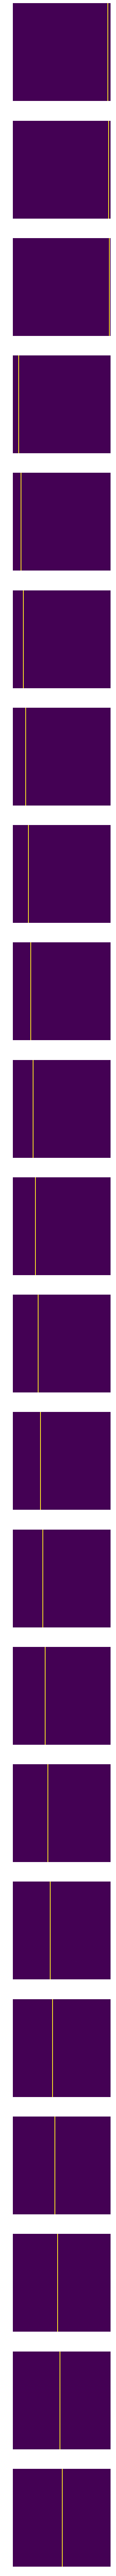

In [28]:
i = 1
fig = plt.figure(figsize=(121,121))
for image in gen_img_temp_train:
    fig.add_subplot(22, 1, i)
    plt.imshow(image)
    plt.xlim(0, data.shape[-1])
    plt.ylim(0, data.shape[-1])
    plt.axis('off')
    i += 1
plt.show()

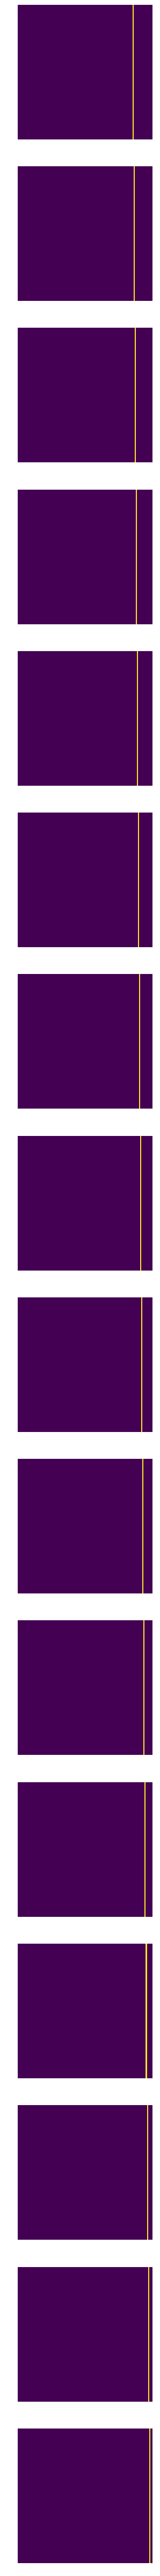

In [29]:
i = 1
fig = plt.figure(figsize=(121,121))
for image in gen_img_temp_val:
    fig.add_subplot(22, 1, i)
    plt.imshow(image)
    plt.xlim(0, data.shape[-1])
    plt.ylim(0, data.shape[-1])
    plt.axis('off')
    i += 1
plt.show()